## Import libraries

In [1]:
!python -V

Python 3.7.6


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
#import keras
from sklearn import preprocessing

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.18.1
Pandas version: 1.0.1


In [4]:
import sklearn as sk
sk.__version__

'0.22.1'

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## Import dataset

In [6]:
df=pd.read_csv('dengue data-1070801codedSM.csv')
df=df.drop(['date'],  axis=1)
df=df.dropna(how='any')

In [7]:
train_df, test_df = train_test_split(df, test_size=.1, 
                                         stratify=df.Severity, random_state=42)

In [8]:
pd.set_option('display.max_columns', train_df.shape[1])
pd.set_option('max_colwidth', 1000)

In [9]:
train_df.head()

Severity  sex  age        RNA  NS1  IgM  IgG
397         0    1   45  2220000.0  1.0  0.0  0.0
252         0    0   62      198.0  1.0  1.0  0.0
420         0    1   31   816000.0  1.0  0.0  0.0
638         0    0   89        0.0  0.0  0.0  1.0
374         0    0   27      744.0  0.0  0.0  0.0

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 397 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Severity  718 non-null    int64  
 1   sex       718 non-null    int64  
 2   age       718 non-null    int64  
 3   RNA       718 non-null    float64
 4   NS1       718 non-null    float64
 5   IgM       718 non-null    float64
 6   IgG       718 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 44.9 KB


## Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

**Transform data in a pipeline** 

 
For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

In [11]:
def PreprocessData (raw_df):
    ndarray=raw_df.values
    Label=ndarray[:,0]
    Features=raw_df.drop(['Severity'], axis=1)
    
    minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    scaleFeatures=minmax_scale.fit_transform(Features)
    
    return scaleFeatures, Label
    #return Features, Label

In [12]:
train_Features, train_Label=PreprocessData(train_df)
test_Features, test_Label=PreprocessData(test_df)

In [13]:
np.random.seed(10)

## Fitting classifiers

In [14]:
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score
import numpy as np
import scipy.stats as stats

In [15]:
train_df['Severity'].value_counts()

0    594
1    124
Name: Severity, dtype: int64

This is an unbalanced dataset(i.e., the number of positive and negative cases are not the same), and we'll use recall as our metric to optimise the model performance.

**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [16]:
def plot_learning_curves(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Average_precision")
    plt.title('{} learning curve'.format(model.__class__.__name__))

In [17]:
from sklearn.metrics import precision_recall_curve, make_scorer, auc, average_precision_score

def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score[:, 1])
    return auc(recall, precision, reorder=True)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,needs_proba=True)

In [18]:
sk.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Logistic Regression
Our first model is logistic regression

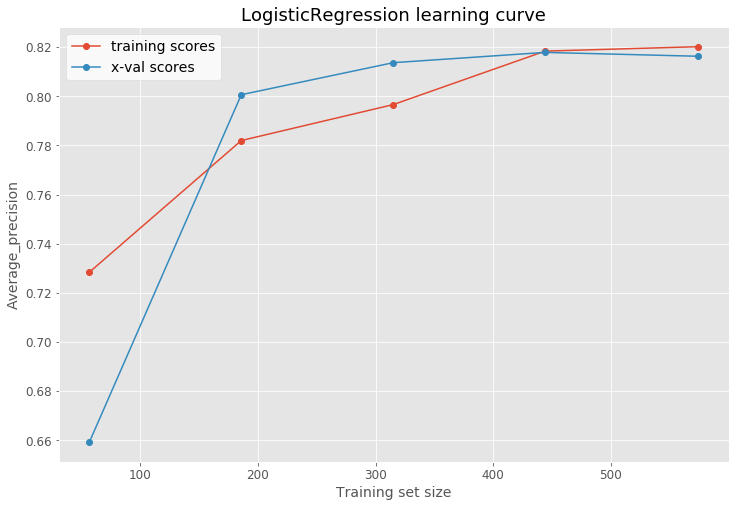

In [19]:
lr_clf = LogisticRegression(n_jobs = -1, 
                           class_weight='balanced'
                           )
plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

Let's see if we can squeeze some more performance out by optimising C.

In [20]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
   'class_weight': ['balanced', None]
    }
lr_clf = LogisticRegression(random_state=42)
#scorings ={'precision', 'recall', 'roc_auc'}
#scoring = {make_scorer(auc)}
#make_scorer(accuracy_score)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [21]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                   Params
0       0.818712      0.823378          {'C': 10, 'class_weight': None}
1       0.818008      0.823329         {'C': 100, 'class_weight': None}
2       0.817728      0.823240        {'C': 1000, 'class_weight': None}
3       0.816989      0.820326           {'C': 1, 'class_weight': None}
4       0.816531      0.822245    {'C': 10, 'class_weight': 'balanced'}
5       0.816517      0.822369   {'C': 100, 'class_weight': 'balanced'}
6       0.816446      0.822335  {'C': 1000, 'class_weight': 'balanced'}
7       0.816337      0.820162     {'C': 1, 'class_weight': 'balanced'}
8       0.801710      0.808615   {'C': 0.1, 'class_weight': 'balanced'}
9       0.798840      0.802154         {'C': 0.1, 'class_weight': None}
10      0.784272      0.792643  {'C': 0.01, 'class_weight': 'balanced'}
11      0.779169      0.788495        {'C': 0.01, 'class_weight': None}

Looks like C=1000 is our best value.

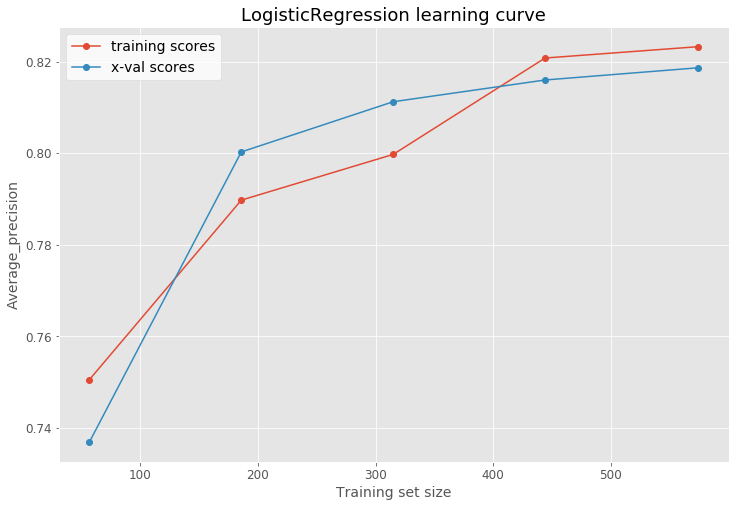

In [22]:
lr_clf = grid_search.best_estimator_

plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

In [23]:
with open('20200225lr_clf_final_round.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

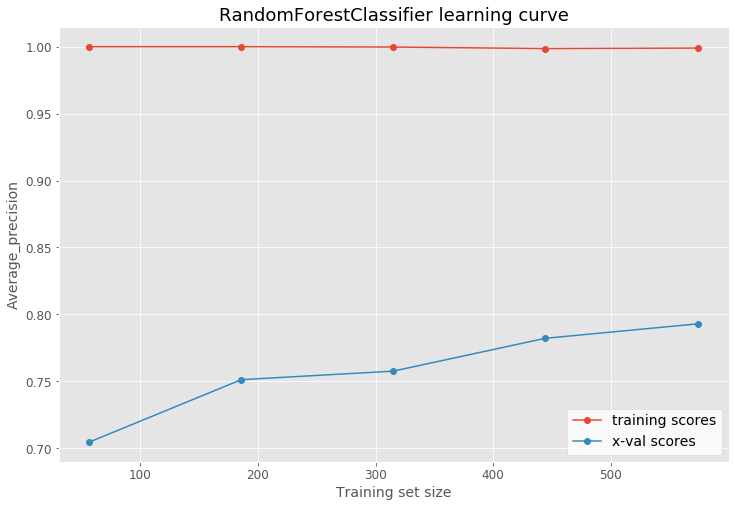

In [24]:
rf_clf = RandomForestClassifier(random_state=42, 
                              class_weight='balanced'
                               )
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

This is a typical overfitting curve. The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [25]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
        'class_weight': ['balanced', None]
    }
#rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [26]:
cv_rlt = rnd_search.cv_results_
rf_clf = rnd_search.best_estimator_

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.819532      0.883825   
1       0.816304      0.962899   
2       0.815028      0.871185   
3       0.814414      0.887339   
4       0.812928      0.911873   
..           ...           ...   
95      0.727754      0.797511   
96      0.713791      0.754124   
97      0.705213      0.750909   
98      0.697522      0.783475   
99      0.692188      0.746698   

                                                                                                                                        Params  
0   {'class_weight': 'balanced', 'max_depth': 74, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 35, 'n_estimators': 33}  
1     {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 24}  
2    {'class_weight': 'balanced', 'max_depth': 74, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 5, 'n_estimators': 25}  
3    {'class_weight': 'balanced', 'max_depth': 34, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 42, 'n_estimators': 28}  
4    {'class_weight': 'balanced', 'max_depth': 95, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 26}  
..                                                                                                                                         ...  
95    {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 25, 'min_samples_split': 81, 'n_estimators': 2}  
96         {'class_weight': None, 'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 93, 'min_samples_split': 99, 'n_estimators': 2}  
97    {'class_weight': 'balanced', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 62, 'min_samples_split': 65, 'n_estimators': 5}  
98         {'class_weight': None, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 91, 'n_estimators': 2}  
99          {'class_weight': None, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 97, 'min_samples_split': 2, 'n_estimators': 5}  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

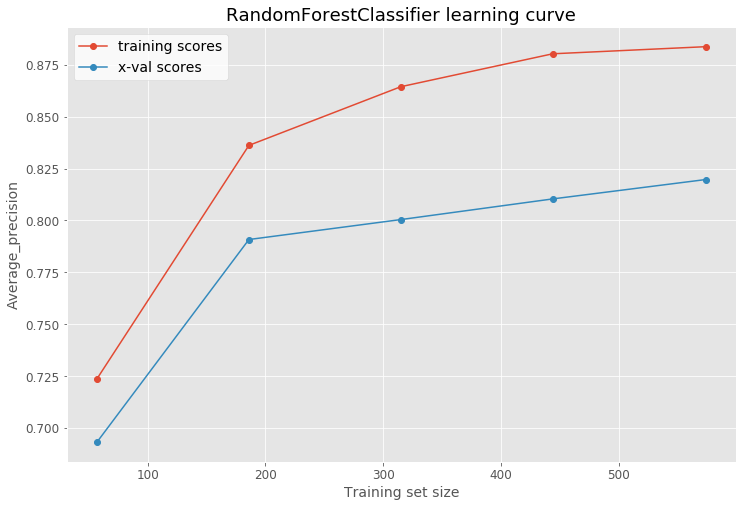

In [27]:
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

In [28]:
#rf_clf = rnd_search.best_estimator_
rf_clf.fit(train_Features, train_df['Severity'], )
with open('20200225rf_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

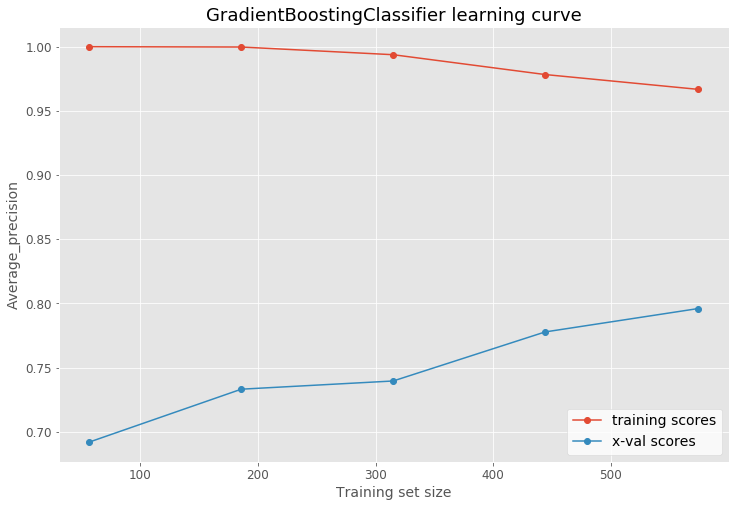

In [29]:
plot_learning_curves(GradientBoostingClassifier(random_state=42), train_Features, train_df['Severity'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [30]:
param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [31]:
cv_rlt = rnd_search.cv_results_
gbm_clf = rnd_search.best_estimator_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.808022      0.884936   
1       0.807457      0.885382   
2       0.807358      0.895238   
3       0.806725      0.874743   
4       0.806483      0.895704   
..           ...           ...   
95      0.773949      0.999921   
96      0.773188      0.999758   
97      0.770591      0.999852   
98      0.768566      0.999881   
99      0.755509      0.999921   

                                                                                     Params  
0   {'max_depth': 20, 'min_samples_leaf': 91, 'min_samples_split': 45, 'n_estimators': 113}  
1   {'max_depth': 18, 'min_samples_leaf': 98, 'min_samples_split': 74, 'n_estimators': 138}  
2   {'max_depth': 32, 'min_samples_leaf': 98, 'min_samples_split': 29, 'n_estimators': 190}  
3    {'max_depth': 11, 'min_samples_leaf': 91, 'min_samples_split': 54, 'n_estimators': 81}  
4   {'max_depth': 17, 'min_samples_leaf': 91, 'min_samples_split': 43, 'n_estimators': 156}  
..                                                                                      ...  
95   {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 28, 'n_estimators': 141}  
96   {'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 54, 'n_estimators': 123}  
97   {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 55, 'n_estimators': 172}  
98     {'max_depth': 42, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 85}  
99   {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 171}  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

In [32]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(train_Features, train_df['Severity'])
with open('20200225gbm_clf_final_round.pkl', 'wb') as f:
    pickle.dump(gbm_clf, f)

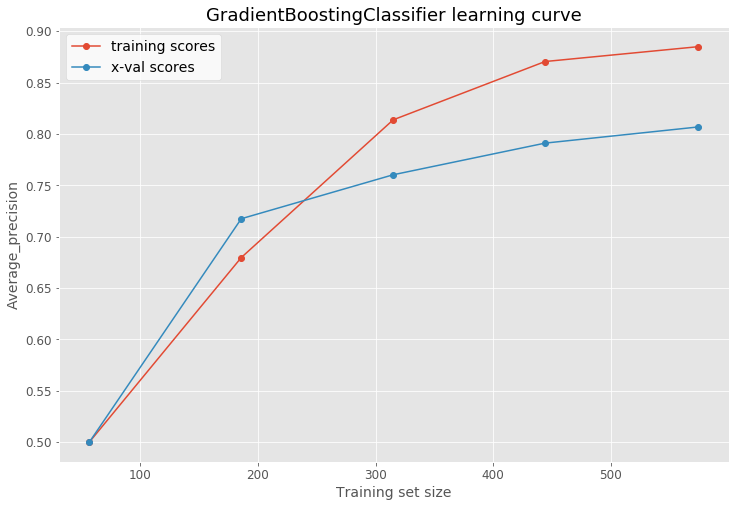

In [33]:
plot_learning_curves(gbm_clf, train_Features, train_df['Severity'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model might continue to increase with more traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

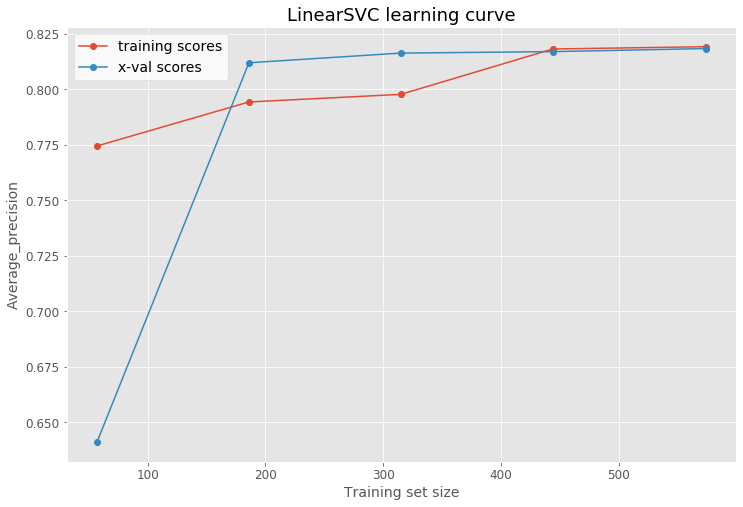

In [34]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'] )

Try Polynomial kernel

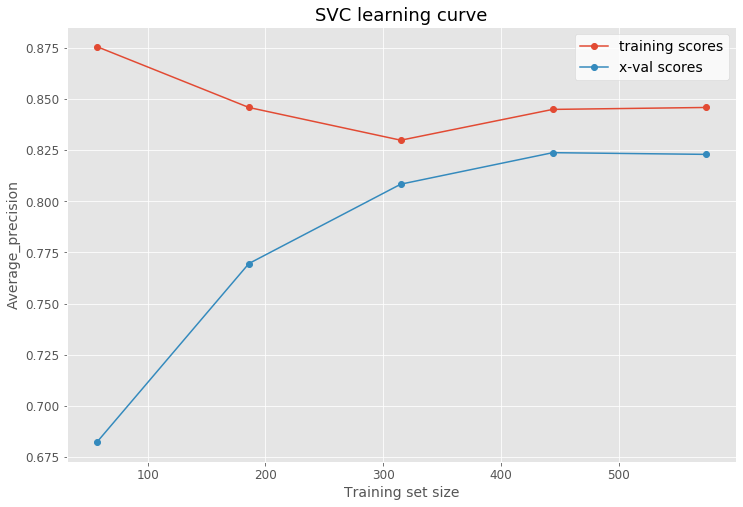

In [35]:
plot_learning_curves(SVC(kernel='poly', random_state=42,class_weight= 'balanced'), train_Features, train_df['Severity'])

Try Gaussian RBF kernel

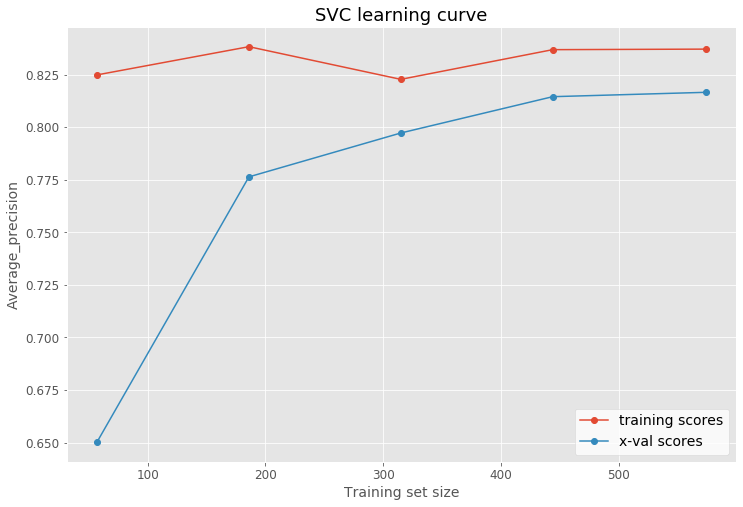

In [36]:
plot_learning_curves(SVC(random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'])

The learning curve of the Linear SVC shows sign of underfitting, and provide evidence that the data set is not linearly seperatable.  

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [37]:
rbf_gamma = [1/len(train_df.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9],  'class_weight': ['balanced']},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9],  'class_weight': ['balanced', None]},
    
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 3, 9], 'class_weight': ['balanced'],
                          'degree': [3, 9, 15], 'kernel': ['poly']},
                         {'C': [1, 3, 9], 'class_weight': ['balanced', None],
                          'gamma': [0.14285714285714285, 0.8571428571428571,
                                    1.5714285714285714]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [38]:
cv_rlt = grid_search.cv_results_
svc_clf = grid_search.best_estimator_

In [39]:
cv_rlt

{'mean_fit_time': array([3.89181137e-02, 5.62553024e-01, 5.99528606e+01, 5.28819561e-02,
        1.15916672e+00, 8.18725058e+01, 6.68464184e-02, 2.47943292e+00,
        1.31879987e+02, 9.64306831e-02, 8.15388203e-02, 8.18229198e-02,
        6.13347054e-02, 5.92940807e-02, 6.17264271e-02, 7.65329361e-02,
        8.05338383e-02, 8.04462433e-02, 6.26044750e-02, 6.92048073e-02,
        7.60837555e-02, 8.36799145e-02, 8.50770950e-02, 8.21913242e-02,
        6.79404259e-02, 6.91277027e-02, 7.08521843e-02]),
 'std_fit_time': array([4.86504994e-03, 9.68762739e-02, 1.70109465e+01, 9.42507646e-03,
        1.90944380e-01, 1.24906406e+01, 1.23264302e-02, 7.88719683e-01,
        1.28730496e+01, 1.11006670e-03, 2.78041279e-03, 1.74871452e-03,
        9.87681165e-03, 3.31756741e-03, 9.05844013e-03, 9.69308119e-03,
        6.61277225e-03, 2.91180163e-03, 3.39042589e-03, 5.81784270e-03,
        6.23922276e-03, 3.90598435e-03, 7.70614997e-03, 4.41980918e-03,
        2.15390399e-03, 1.31343059e-02, 1.462

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

SVM training is very computationaly expensive, making it not scalable to big data sets. As it turns out the default RBF SVM results the best cross-validation score.

In [40]:
svc_clf.fit(train_Features, train_df['Severity'])
with open('20200225svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

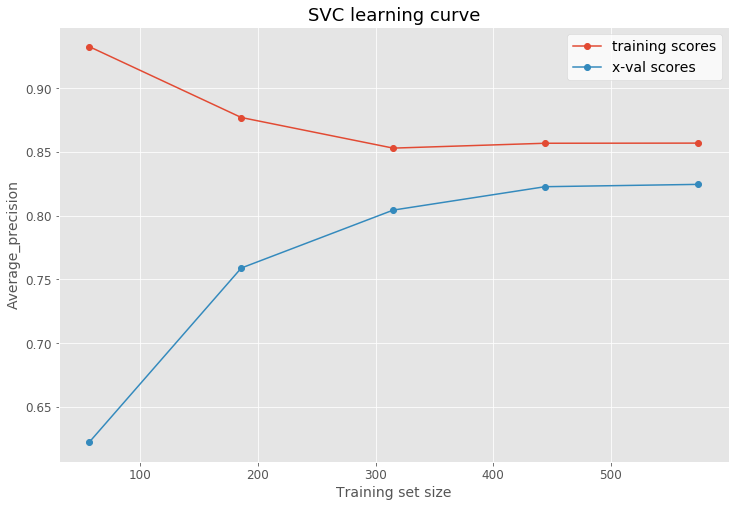

In [41]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, train_Features, train_df['Severity']) 

### Ensemble classifier
Scikit-learn offers a voting classifier which aggregates the prediction of multiple predictors and is a flexible ensemble technique that allows an ensemble of different models.  
For the final classifier, simply aggregate the predictions of the three best models, i.e. logistic regression, random forests, and the support vector machine.

In [42]:
ensemble_clf = VotingClassifier(estimators=[
                                            ('lr', lr_clf),
                                            ('rf', rf_clf),
                                            ('gbm', gbm_clf),
                                            ('svc', svc_clf)
                                           ],
                             voting='soft')
ensemble_clf.fit(train_Features, train_df['Severity'])

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced'...
                                        

Check out its learning curve.

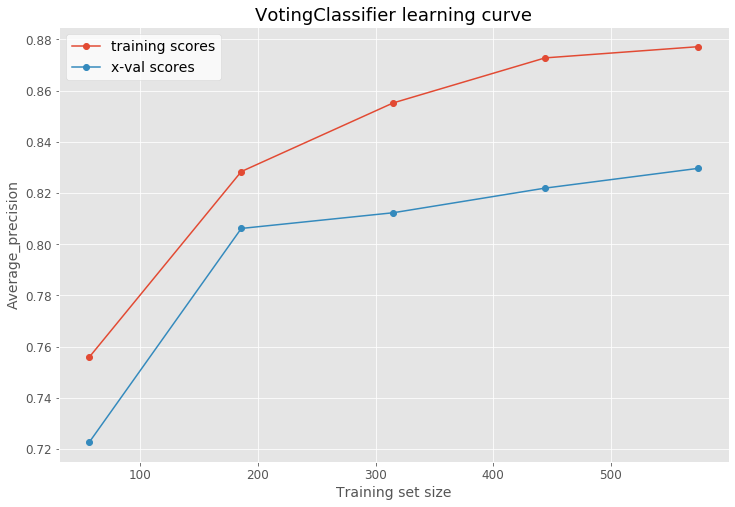

In [43]:
plot_learning_curves(ensemble_clf, train_Features, train_df['Severity'])

This learning curve looks quite promising. It presents a good curve that is out of a right model. And the model might be benefit from more training data.

In [44]:
with open('20200225ensemble_clf_final_round.pkl', 'wb') as f:
    pickle.dump(ensemble_clf, f)

In [45]:
# Import model and retrain
with open('20200225ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(train_Features, train_df['Severity'])

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced'...
                                        

In [46]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [47]:
test_df.iloc[0,1:]

sex     0.0
age    60.0
RNA     0.0
NS1     1.0
IgM     1.0
IgG     1.0
Name: 519, dtype: float64

In [48]:
explainer = shap.KernelExplainer(ensemble_clf.predict_proba, train_Features)
shap_values = explainer.shap_values(test_Features[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], test_df.iloc[0,1:])


Using 718 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [49]:
shap_values = explainer.shap_values(test_Features)
shap.force_plot(explainer.expected_value[1], shap_values[1], test_df.iloc[:, 1:])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


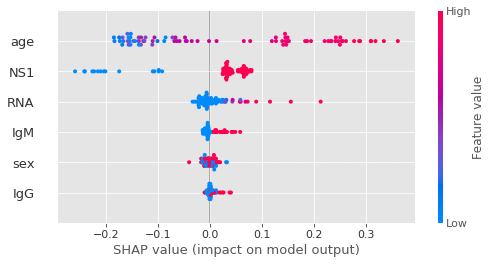

In [50]:
shap.summary_plot(shap_values[1], test_df.iloc[:,1:])

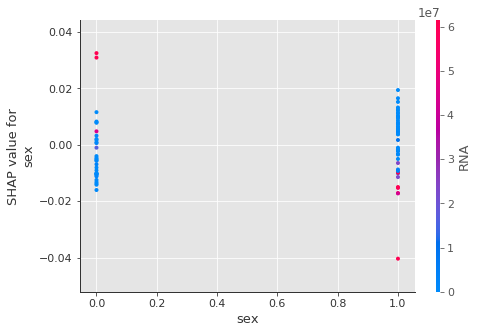

In [51]:
shap.dependence_plot("sex", shap_values[1], test_df.iloc[:,1:])

## Compute and compare test metrics

**Compute test accuracy score**

In [52]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

### _Logistic Regression model_

In [53]:
# Import model and retrain
with open('20200225lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(train_Features, train_df['Severity'])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy scores

In [54]:
accu_lr = accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))

In [55]:
accu_lr

0.8625

In [56]:
pd.crosstab(test_df['Severity'], lr_clf.predict(test_Features))

col_0      0  1
Severity       
0         63  3
1          8  6

ROC and AUC

In [57]:
pred_proba_lr = lr_clf.predict_proba(test_Features)

In [58]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(test_df['Severity'], pred_proba_lr[:, 1])

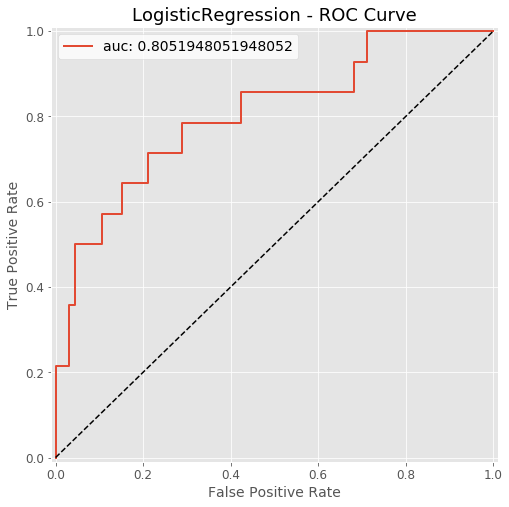

In [59]:
plot_roc_curve(fpr, tpr, auc_lr, lr_clf)

In [60]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

In [61]:
def plot_precision_recall_curve(fpr, tpr, ap, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, linewidth=2, label='average_precision: {}'.format(ap))
    plt.plot([0, 1], [0.1, 0.1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - PR Curve'.format(title))

f1=0.522 auc_lr=0.580 ap_lr=0.592


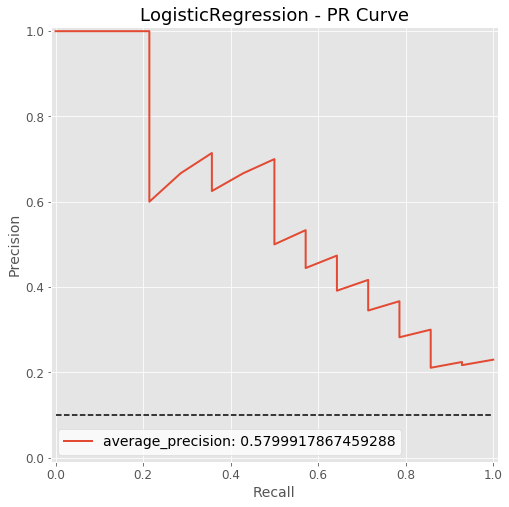

In [62]:
# predict probabilities
pred_proba_lr = lr_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_lr = pred_proba_lr[:, 1]
# predict class values
yhat = lr_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_lr)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_lr_pr=auc(recall, precision)
# calculate average precision score
ap_lr_pr = average_precision_score(test_Label, pred_proba_lr)
print('f1=%.3f auc_lr=%.3f ap_lr=%.3f' % (f1, auc_lr_pr, ap_lr_pr))

plot_precision_recall_curve(recall, precision, auc_lr_pr, lr_clf)

### _Random forests model_

In [63]:
# Import model and retrain
with open('20200225rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_df['Severity'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=74, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=35,
                       min_weight_fraction_leaf=0.0, n_estimators=33,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy scores

In [64]:
accu_rf = accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))

In [65]:
accu_rf

0.7375

In [66]:
pd.crosstab(test_df['Severity'], rf_clf.predict(test_Features))

col_0      0   1
Severity        
0         48  18
1          3  11

ROC and AUC

In [67]:
pred_proba_rf = rf_clf.predict_proba(test_Features)

In [68]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(test_df['Severity'], pred_proba_rf[:, 1])

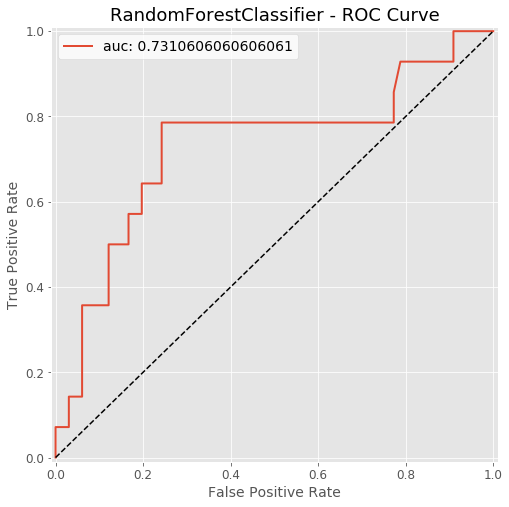

In [69]:
plot_roc_curve(fpr, tpr, auc_rf, rf_clf)

f1=0.512 auc_rf=0.731 ap_rf=0.436


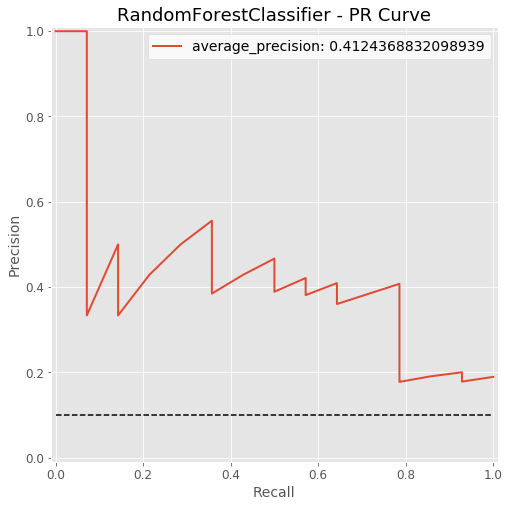

In [70]:
# predict probabilities
pred_proba_rf = rf_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_rf = pred_proba_rf[:, 1]
# predict class values
yhat = rf_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_rf)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_rf_pr=auc(recall, precision)
# calculate average precision score
ap_rf_pr = average_precision_score(test_Label, pred_proba_rf)
print('f1=%.3f auc_rf=%.3f ap_rf=%.3f' % (f1, auc_rf, ap_rf_pr))

plot_precision_recall_curve(recall, precision, auc_rf_pr, rf_clf)

### _Gradient boosting machine model_

In [71]:
# Import model and retrain
with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(train_Features, train_df['Severity'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=20,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=91, min_samples_split=45,
                           min_weight_fraction_leaf=0.0, n_estimators=113,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy scores

In [72]:
accu_gbm = accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))

In [73]:
accu_gbm

0.8

In [74]:
pd.crosstab(test_df['Severity'], gbm_clf.predict(test_Features))

col_0      0  1
Severity       
0         58  8
1          8  6

ROC and AUC

In [75]:
pred_proba_gbm = gbm_clf.predict_proba(test_Features)

In [76]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(test_df['Severity'], pred_proba_gbm[:, 1])

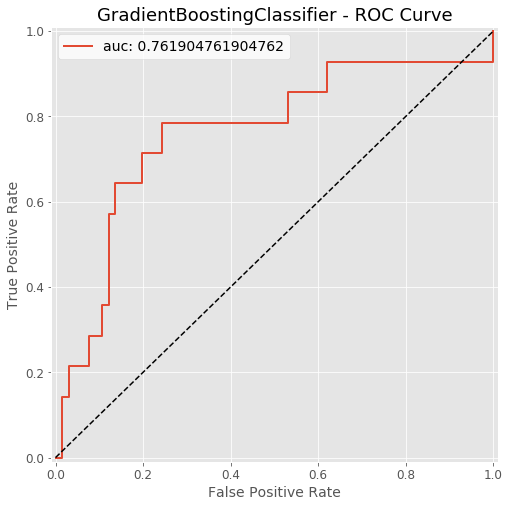

In [77]:
plot_roc_curve(fpr, tpr, auc_gbm, gbm_clf)

f1=0.429 auc_gbm=0.391 ap_gbm=0.434


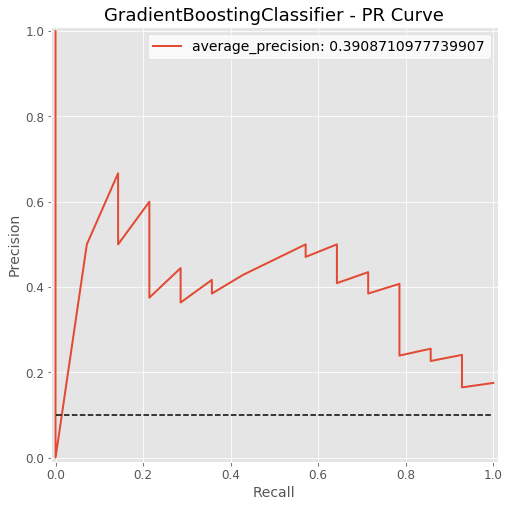

In [78]:
# predict probabilities
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_gbm = pred_proba_gbm[:, 1]
# predict class values
yhat = gbm_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_gbm)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_gbm_pr=auc(recall, precision)
# calculate average precision score
ap_gbm_pr = average_precision_score(test_Label, pred_proba_gbm)
print('f1=%.3f auc_gbm=%.3f ap_gbm=%.3f' % (f1, auc_gbm_pr, ap_gbm_pr))

plot_precision_recall_curve(recall, precision, auc_gbm_pr, gbm_clf)

### _Support vector machine model_

In [79]:
# Import model and retrain
with open('20200225svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(train_Features, train_df['Severity'])

SVC(C=9, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Accuracy scores

In [80]:
accu_svc = accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))

In [81]:
accu_svc

0.65

In [82]:
pd.crosstab(test_df['Severity'], svc_clf.predict(test_Features))

col_0      0   1
Severity        
0         41  25
1          3  11

ROC and AUC

In [83]:
pred_proba_svc = svc_clf.predict_proba(test_Features)

In [84]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(test_df['Severity'], pred_proba_svc[:, 1])

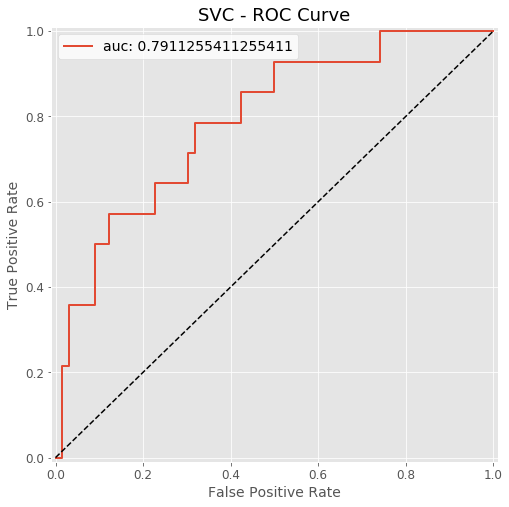

In [85]:
plot_roc_curve(fpr, tpr, auc_svc, svc_clf)

f1=0.440 auc_svc=0.439 ap_svc=0.478


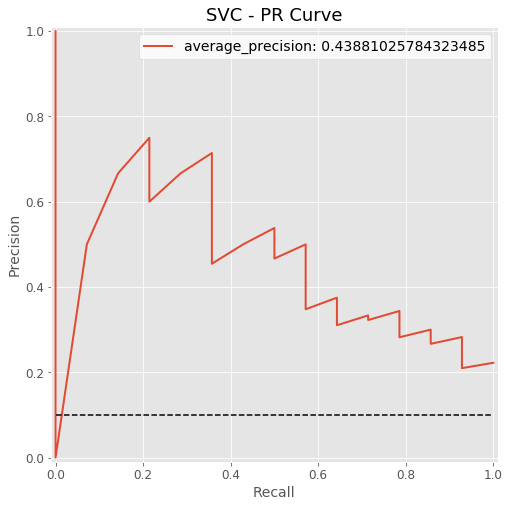

In [86]:
# predict probabilities
pred_proba_svc = svc_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_svc = pred_proba_svc[:, 1]
# predict class values
yhat = svc_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_svc)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_svc_pr=auc(recall, precision)
# calculate average precision score
ap_svc_pr = average_precision_score(test_Label, pred_proba_svc)
print('f1=%.3f auc_svc=%.3f ap_svc=%.3f' % (f1, auc_svc_pr, ap_svc_pr))

plot_precision_recall_curve(recall, precision, auc_svc_pr, svc_clf)

### _The ensemble model_

In [87]:
# Import model and retrain
with open('20200225ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(train_Features, train_df['Severity'])

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced'...
                                        

Accuracy scores

In [88]:
accu_ensemble = accuracy_score(test_df['Severity'], ensemble_clf.predict(test_Features))

In [89]:
accu_ensemble

0.8

In [90]:
pd.crosstab(test_df['Severity'], ensemble_clf.predict(test_Features))

col_0      0   1
Severity        
0         55  11
1          5   9

ROC and AUC

In [91]:
pred_proba_ensemble = ensemble_clf.predict_proba(test_Features)

In [92]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_ensemble[:, 1])
auc_ensemble = roc_auc_score(test_df['Severity'], pred_proba_ensemble[:, 1])

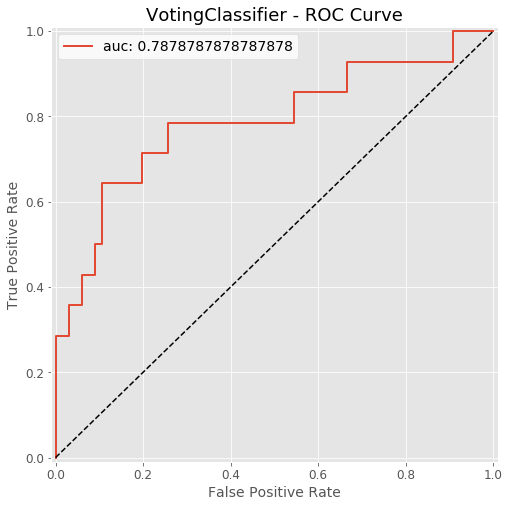

In [93]:
plot_roc_curve(fpr, tpr, auc_ensemble, ensemble_clf)

f1=0.529 auc_ensemble=0.593 ap_ensemble=0.603


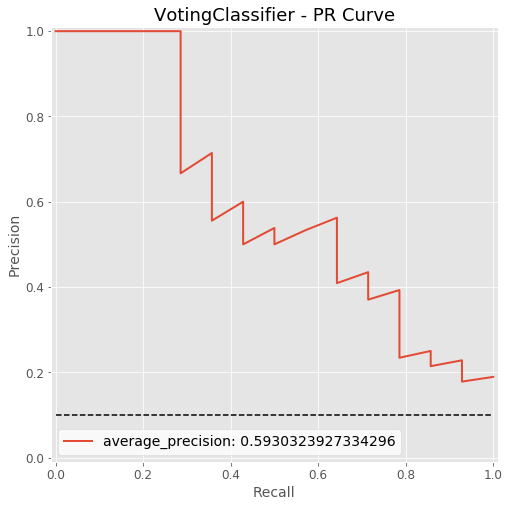

In [94]:
# predict probabilities
pred_proba_ensemble = ensemble_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_ensemble = pred_proba_ensemble[:, 1]
# predict class values
yhat = ensemble_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_ensemble)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_ensemble_pr=auc(recall, precision)
# calculate average precision score
ap_ensemble_pr = average_precision_score(test_Label, pred_proba_ensemble)
print('f1=%.3f auc_ensemble=%.3f ap_ensemble=%.3f' % (f1, auc_ensemble_pr, ap_ensemble_pr))

plot_precision_recall_curve(recall, precision, auc_ensemble_pr, ensemble_clf)

### Deep Learning

In [95]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [96]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [97]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [98]:
file = tf.keras.utils

In [99]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(200, activation='relu',input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      #metrics=[tf.keras.metrics.BinaryAccuracy()]
      metrics=[tf.keras.metrics.AUC()]
  )

  return model

EPOCHS = 700
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=2,
    patience=50,
    mode='max',
    restore_best_weights=True)


In [100]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1400      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 41,801
Trainable params: 41,801
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.fit(train_Features,train_Label, 
          #class_weight=class_weights,
          epochs=700, batch_size=100, verbose=2)

Train on 718 samples
Epoch 1/700
718/718 - 1s - loss: 0.4626 - auc: 0.5013
Epoch 2/700
718/718 - 0s - loss: 0.4522 - auc: 0.6322
Epoch 3/700
718/718 - 0s - loss: 0.4439 - auc: 0.7071
Epoch 4/700
718/718 - 0s - loss: 0.4317 - auc: 0.7549
Epoch 5/700
718/718 - 0s - loss: 0.4261 - auc: 0.7568
Epoch 6/700
718/718 - 0s - loss: 0.4196 - auc: 0.7509
Epoch 7/700
718/718 - 0s - loss: 0.4098 - auc: 0.7793
Epoch 8/700
718/718 - 0s - loss: 0.4060 - auc: 0.7651
Epoch 9/700
718/718 - 0s - loss: 0.3959 - auc: 0.7857
Epoch 10/700
718/718 - 0s - loss: 0.3874 - auc: 0.7987
Epoch 11/700
718/718 - 0s - loss: 0.3809 - auc: 0.8024
Epoch 12/700
718/718 - 0s - loss: 0.3792 - auc: 0.8017
Epoch 13/700
718/718 - 0s - loss: 0.3757 - auc: 0.8033
Epoch 14/700
718/718 - 0s - loss: 0.3711 - auc: 0.8099
Epoch 15/700
718/718 - 0s - loss: 0.3703 - auc: 0.8057
Epoch 16/700
718/718 - 0s - loss: 0.3642 - auc: 0.8216
Epoch 17/700
718/718 - 0s - loss: 0.3659 - auc: 0.8178
Epoch 18/700
718/718 - 0s - loss: 0.3658 - auc: 0.811

Epoch 149/700
718/718 - 0s - loss: 0.3297 - auc: 0.8550
Epoch 150/700
718/718 - 0s - loss: 0.3310 - auc: 0.8545
Epoch 151/700
718/718 - 0s - loss: 0.3306 - auc: 0.8520
Epoch 152/700
718/718 - 0s - loss: 0.3364 - auc: 0.8517
Epoch 153/700
718/718 - 0s - loss: 0.3339 - auc: 0.8508
Epoch 154/700
718/718 - 0s - loss: 0.3274 - auc: 0.8571
Epoch 155/700
718/718 - 0s - loss: 0.3294 - auc: 0.8562
Epoch 156/700
718/718 - 0s - loss: 0.3303 - auc: 0.8512
Epoch 157/700
718/718 - 0s - loss: 0.3396 - auc: 0.8452
Epoch 158/700
718/718 - 0s - loss: 0.3356 - auc: 0.8470
Epoch 159/700
718/718 - 0s - loss: 0.3374 - auc: 0.8495
Epoch 160/700
718/718 - 0s - loss: 0.3388 - auc: 0.8466
Epoch 161/700
718/718 - 0s - loss: 0.3378 - auc: 0.8452
Epoch 162/700
718/718 - 0s - loss: 0.3307 - auc: 0.8547
Epoch 163/700
718/718 - 0s - loss: 0.3291 - auc: 0.8527
Epoch 164/700
718/718 - 0s - loss: 0.3277 - auc: 0.8613
Epoch 165/700
718/718 - 0s - loss: 0.3211 - auc: 0.8610
Epoch 166/700
718/718 - 0s - loss: 0.3238 - auc:

Epoch 296/700
718/718 - 0s - loss: 0.3189 - auc: 0.8680
Epoch 297/700
718/718 - 0s - loss: 0.3196 - auc: 0.8651
Epoch 298/700
718/718 - 0s - loss: 0.3208 - auc: 0.8653
Epoch 299/700
718/718 - 0s - loss: 0.3184 - auc: 0.8667
Epoch 300/700
718/718 - 0s - loss: 0.3184 - auc: 0.8686
Epoch 301/700
718/718 - 0s - loss: 0.3174 - auc: 0.8674
Epoch 302/700
718/718 - 0s - loss: 0.3236 - auc: 0.8617
Epoch 303/700
718/718 - 0s - loss: 0.3160 - auc: 0.8714
Epoch 304/700
718/718 - 0s - loss: 0.3138 - auc: 0.8732
Epoch 305/700
718/718 - 0s - loss: 0.3221 - auc: 0.8642
Epoch 306/700
718/718 - 0s - loss: 0.3153 - auc: 0.8695
Epoch 307/700
718/718 - 0s - loss: 0.3163 - auc: 0.8686
Epoch 308/700
718/718 - 0s - loss: 0.3167 - auc: 0.8688
Epoch 309/700
718/718 - 0s - loss: 0.3225 - auc: 0.8633
Epoch 310/700
718/718 - 0s - loss: 0.3145 - auc: 0.8690
Epoch 311/700
718/718 - 0s - loss: 0.3225 - auc: 0.8660
Epoch 312/700
718/718 - 0s - loss: 0.3136 - auc: 0.8743
Epoch 313/700
718/718 - 0s - loss: 0.3250 - auc:

Epoch 443/700
718/718 - 0s - loss: 0.3139 - auc: 0.8711
Epoch 444/700
718/718 - 0s - loss: 0.3068 - auc: 0.8767
Epoch 445/700
718/718 - 0s - loss: 0.3082 - auc: 0.8749
Epoch 446/700
718/718 - 0s - loss: 0.3081 - auc: 0.8771
Epoch 447/700
718/718 - 0s - loss: 0.3055 - auc: 0.8789
Epoch 448/700
718/718 - 0s - loss: 0.3112 - auc: 0.8756
Epoch 449/700
718/718 - 0s - loss: 0.3093 - auc: 0.8777
Epoch 450/700
718/718 - 0s - loss: 0.3151 - auc: 0.8739
Epoch 451/700
718/718 - 0s - loss: 0.2985 - auc: 0.8885
Epoch 452/700
718/718 - 0s - loss: 0.3111 - auc: 0.8741
Epoch 453/700
718/718 - 0s - loss: 0.3069 - auc: 0.8821
Epoch 454/700
718/718 - 0s - loss: 0.3148 - auc: 0.8676
Epoch 455/700
718/718 - 0s - loss: 0.3132 - auc: 0.8724
Epoch 456/700
718/718 - 0s - loss: 0.3085 - auc: 0.8770
Epoch 457/700
718/718 - 0s - loss: 0.3049 - auc: 0.8815
Epoch 458/700
718/718 - 0s - loss: 0.3105 - auc: 0.8753
Epoch 459/700
718/718 - 0s - loss: 0.3068 - auc: 0.8772
Epoch 460/700
718/718 - 0s - loss: 0.3094 - auc:

Epoch 590/700
718/718 - 0s - loss: 0.3078 - auc: 0.8752
Epoch 591/700
718/718 - 0s - loss: 0.3012 - auc: 0.8852
Epoch 592/700
718/718 - 0s - loss: 0.2972 - auc: 0.8878
Epoch 593/700
718/718 - 0s - loss: 0.3077 - auc: 0.8756
Epoch 594/700
718/718 - 0s - loss: 0.3012 - auc: 0.8842
Epoch 595/700
718/718 - 0s - loss: 0.3025 - auc: 0.8820
Epoch 596/700
718/718 - 0s - loss: 0.3058 - auc: 0.8815
Epoch 597/700
718/718 - 0s - loss: 0.2986 - auc: 0.8858
Epoch 598/700
718/718 - 0s - loss: 0.3048 - auc: 0.8789
Epoch 599/700
718/718 - 0s - loss: 0.2982 - auc: 0.8872
Epoch 600/700
718/718 - 0s - loss: 0.3057 - auc: 0.8797
Epoch 601/700
718/718 - 0s - loss: 0.3011 - auc: 0.8861
Epoch 602/700
718/718 - 0s - loss: 0.3075 - auc: 0.8799
Epoch 603/700
718/718 - 0s - loss: 0.3089 - auc: 0.8765
Epoch 604/700
718/718 - 0s - loss: 0.2948 - auc: 0.8884
Epoch 605/700
718/718 - 0s - loss: 0.3090 - auc: 0.8748
Epoch 606/700
718/718 - 0s - loss: 0.2958 - auc: 0.8906
Epoch 607/700
718/718 - 0s - loss: 0.2982 - auc:

In [102]:
model.predict(train_Features[:10])

array([[4.6716794e-02],
       [1.3498212e-02],
       [2.8055551e-02],
       [8.9346200e-02],
       [1.7974773e-04],
       [2.6027000e-02],
       [3.0321670e-01],
       [2.4470102e-02],
       [3.8194332e-02],
       [9.8040033e-08]], dtype=float32)

In [103]:
train_Label[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [104]:
test_probability=model.predict(test_Features)

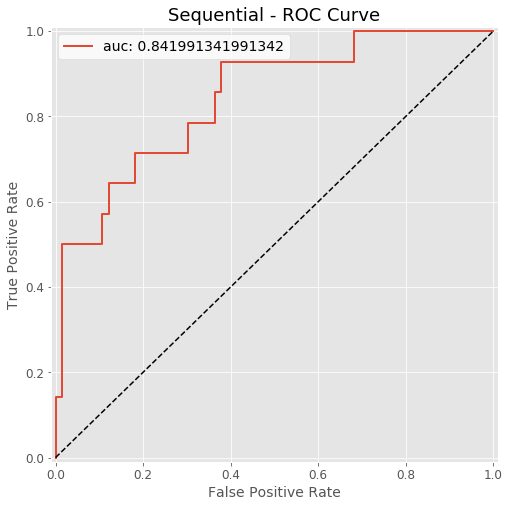

In [105]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)
plot_roc_curve(fpr, tpr, auc_NL, model)

In [106]:
test_class=model.predict_classes(test_Features)

In [107]:
pd.crosstab(test_df['Severity'], test_class[:,0])

col_0      0  1
Severity       
0         60  6
1          7  7

# Hyperparameters

In [108]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd


import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [109]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [110]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [111]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [112]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([100, 150, 200, 250, 300])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([100, 150, 200, 250, 300]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.3, 0.5]))
#HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'ROC_AUC'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='ROC_AUC')],
  )


In [113]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.AUC()]
  )

  model.fit(train_Features, train_Label, epochs=300) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_Features, test_Label)
  return accuracy

In [114]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [115]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
  for num_units2 in HP_NUM_UNITS2.domain.values:
    #for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
     for dropout_rate in HP_DROPOUT.domain.values:
      #for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
          
          hparams = {
              HP_NUM_UNITS1: num_units1,
              HP_NUM_UNITS2: num_units2,
              HP_DROPOUT: dropout_rate,
              #HP_L2: l2,
              HP_OPTIMIZER: optimizer
              
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units 1': 100, 'num_units 2': 100, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 1ms/sample - loss: 0.6644 - auc_1: 0.4337
Epoch 2/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5809 - auc_1: 0.3640
Epoch 3/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5478 - auc_1: 0.5091
Epoch 4/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5115 - auc_1: 0.6718
Epoch 5/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4886 - auc_1: 0.7529
Epoch 6/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4701 - auc_1: 0.7764
Epoch 7/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4524 - auc_1: 0.7979
Epoch 8/300
718/718 [==============================] - 0s 170us/sample - loss: 0.4388 - auc_1: 0.8145
Epoch 9/300
718/718 [==============================] - 0s 179

718/718 [==============================] - 0s 180us/sample - loss: 0.3585 - auc_1: 0.8356
Epoch 158/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3547 - auc_1: 0.8411
Epoch 159/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3567 - auc_1: 0.8417
Epoch 160/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3518 - auc_1: 0.8438
Epoch 161/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3581 - auc_1: 0.8368
Epoch 162/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3607 - auc_1: 0.8343
Epoch 163/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3597 - auc_1: 0.8358
Epoch 164/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3500 - auc_1: 0.8472
Epoch 165/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3568 - auc_1: 0.8397
Epoch 166/300
718/718 [==============================] - 0s 183us/sample - los

718/718 [==============================] - 0s 177us/sample - loss: 0.5935 - auc_2: 0.3525
Epoch 13/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5910 - auc_2: 0.3745
Epoch 14/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5906 - auc_2: 0.3586
Epoch 15/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5904 - auc_2: 0.3702
Epoch 16/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5893 - auc_2: 0.3648
Epoch 17/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5861 - auc_2: 0.4043
Epoch 18/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5847 - auc_2: 0.4123
Epoch 19/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5838 - auc_2: 0.4169
Epoch 20/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5867 - auc_2: 0.3787
Epoch 21/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5832

Epoch 170/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4749 - auc_2: 0.8124
Epoch 171/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4751 - auc_2: 0.8084
Epoch 172/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4756 - auc_2: 0.8163
Epoch 173/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4799 - auc_2: 0.8016
Epoch 174/300
718/718 [==============================] - 0s 189us/sample - loss: 0.4795 - auc_2: 0.8032
Epoch 175/300
718/718 [==============================] - 0s 188us/sample - loss: 0.4770 - auc_2: 0.8096
Epoch 176/300
718/718 [==============================] - 0s 182us/sample - loss: 0.4714 - auc_2: 0.8178
Epoch 177/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4731 - auc_2: 0.8119
Epoch 178/300
718/718 [==============================] - 0s 187us/sample - loss: 0.4752 - auc_2: 0.8099
Epoch 179/300
718/718 [==============================] - 0s 187u

718/718 [==============================] - 0s 184us/sample - loss: 0.3942 - auc_3: 0.8179
Epoch 26/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3943 - auc_3: 0.8165
Epoch 27/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3879 - auc_3: 0.8235
Epoch 28/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3908 - auc_3: 0.8206
Epoch 29/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3871 - auc_3: 0.8236
Epoch 30/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3871 - auc_3: 0.8249
Epoch 31/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3896 - auc_3: 0.8187
Epoch 32/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3925 - auc_3: 0.8125
Epoch 33/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3829 - auc_3: 0.8293
Epoch 34/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3802

718/718 [==============================] - 0s 196us/sample - loss: 0.3612 - auc_3: 0.8355
Epoch 183/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3661 - auc_3: 0.8252
Epoch 184/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3596 - auc_3: 0.8381
Epoch 185/300
718/718 [==============================] - 0s 206us/sample - loss: 0.3598 - auc_3: 0.8343
Epoch 186/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3613 - auc_3: 0.8345
Epoch 187/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3549 - auc_3: 0.8422
Epoch 188/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3494 - auc_3: 0.8485
Epoch 189/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3578 - auc_3: 0.8390
Epoch 190/300
718/718 [==============================] - 0s 201us/sample - loss: 0.3569 - auc_3: 0.8390
Epoch 191/300
718/718 [==============================] - 0s 202us/sample - los

718/718 [==============================] - 0s 171us/sample - loss: 0.5716 - auc_4: 0.4904
Epoch 38/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5713 - auc_4: 0.4874
Epoch 39/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5709 - auc_4: 0.4936
Epoch 40/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5714 - auc_4: 0.4797
Epoch 41/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5700 - auc_4: 0.4967
Epoch 42/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5709 - auc_4: 0.4887
Epoch 43/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5689 - auc_4: 0.5178
Epoch 44/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5659 - auc_4: 0.5486
Epoch 45/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5681 - auc_4: 0.5148
Epoch 46/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5676

718/718 [==============================] - 0s 180us/sample - loss: 0.4919 - auc_4: 0.7773
Epoch 195/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4918 - auc_4: 0.7775
Epoch 196/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4960 - auc_4: 0.7651
Epoch 197/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4914 - auc_4: 0.7845
Epoch 198/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4885 - auc_4: 0.7897
Epoch 199/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4907 - auc_4: 0.7825
Epoch 200/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4905 - auc_4: 0.7807
Epoch 201/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4917 - auc_4: 0.7786
Epoch 202/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4880 - auc_4: 0.7828
Epoch 203/300
718/718 [==============================] - 0s 170us/sample - los

718/718 [==============================] - 0s 184us/sample - loss: 0.3871 - auc_5: 0.8106
Epoch 50/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3796 - auc_5: 0.8212
Epoch 51/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3770 - auc_5: 0.8245
Epoch 52/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3788 - auc_5: 0.8200
Epoch 53/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3819 - auc_5: 0.8144
Epoch 54/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3733 - auc_5: 0.8303
Epoch 55/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3750 - auc_5: 0.8235
Epoch 56/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3752 - auc_5: 0.8284
Epoch 57/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3803 - auc_5: 0.8176
Epoch 58/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3725

718/718 [==============================] - 0s 201us/sample - loss: 0.3625 - auc_5: 0.8354
Epoch 207/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3666 - auc_5: 0.8260
Epoch 208/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3622 - auc_5: 0.8363
Epoch 209/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3571 - auc_5: 0.8393
Epoch 210/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3640 - auc_5: 0.8265
Epoch 211/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3551 - auc_5: 0.8388
Epoch 212/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3598 - auc_5: 0.8328
Epoch 213/300
718/718 [==============================] - 0s 201us/sample - loss: 0.3628 - auc_5: 0.8335
Epoch 214/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3607 - auc_5: 0.8333
Epoch 215/300
718/718 [==============================] - 0s 197us/sample - los

718/718 [==============================] - 0s 165us/sample - loss: 0.5647 - auc_6: 0.5745
Epoch 62/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5656 - auc_6: 0.5469
Epoch 63/300
718/718 [==============================] - 0s 164us/sample - loss: 0.5608 - auc_6: 0.5724
Epoch 64/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5613 - auc_6: 0.5729
Epoch 65/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5619 - auc_6: 0.5816
Epoch 66/300
718/718 [==============================] - 0s 163us/sample - loss: 0.5602 - auc_6: 0.5888
Epoch 67/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5585 - auc_6: 0.6036
Epoch 68/300
718/718 [==============================] - 0s 166us/sample - loss: 0.5585 - auc_6: 0.6004
Epoch 69/300
718/718 [==============================] - 0s 155us/sample - loss: 0.5636 - auc_6: 0.5472
Epoch 70/300
718/718 [==============================] - 0s 165us/sample - loss: 0.5587

718/718 [==============================] - 0s 181us/sample - loss: 0.4906 - auc_6: 0.7765
Epoch 219/300
718/718 [==============================] - 0s 186us/sample - loss: 0.4860 - auc_6: 0.7869
Epoch 220/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4851 - auc_6: 0.7824
Epoch 221/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4878 - auc_6: 0.7793
Epoch 222/300
718/718 [==============================] - 0s 186us/sample - loss: 0.4828 - auc_6: 0.7915
Epoch 223/300
718/718 [==============================] - 0s 187us/sample - loss: 0.4917 - auc_6: 0.7689
Epoch 224/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4792 - auc_6: 0.7991
Epoch 225/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4867 - auc_6: 0.7850
Epoch 226/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4825 - auc_6: 0.7932
Epoch 227/300
718/718 [==============================] - 0s 189us/sample - los

718/718 [==============================] - 0s 184us/sample - loss: 0.3640 - auc_7: 0.8348
Epoch 74/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3620 - auc_7: 0.8378
Epoch 75/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3603 - auc_7: 0.8391
Epoch 76/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3613 - auc_7: 0.8376
Epoch 77/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3641 - auc_7: 0.8360
Epoch 78/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3647 - auc_7: 0.8337
Epoch 79/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3632 - auc_7: 0.8359
Epoch 80/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3619 - auc_7: 0.8393
Epoch 81/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3627 - auc_7: 0.8360
Epoch 82/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3625

718/718 [==============================] - 0s 203us/sample - loss: 0.3503 - auc_7: 0.8471
Epoch 231/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3472 - auc_7: 0.8535
Epoch 232/300
718/718 [==============================] - 0s 204us/sample - loss: 0.3558 - auc_7: 0.8397
Epoch 233/300
718/718 [==============================] - 0s 206us/sample - loss: 0.3519 - auc_7: 0.8462
Epoch 234/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3492 - auc_7: 0.8485
Epoch 235/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3495 - auc_7: 0.8475
Epoch 236/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3482 - auc_7: 0.8493
Epoch 237/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3488 - auc_7: 0.8486
Epoch 238/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3511 - auc_7: 0.8446
Epoch 239/300
718/718 [==============================] - 0s 197us/sample - los

718/718 [==============================] - 0s 176us/sample - loss: 0.6317 - auc_8: 0.2671
Epoch 8/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6259 - auc_8: 0.2775
Epoch 9/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6228 - auc_8: 0.2612
Epoch 10/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6165 - auc_8: 0.3184
Epoch 11/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6168 - auc_8: 0.2930
Epoch 12/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6154 - auc_8: 0.2830
Epoch 13/300
718/718 [==============================] - 0s 181us/sample - loss: 0.6145 - auc_8: 0.2954
Epoch 14/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6126 - auc_8: 0.3064
Epoch 15/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6107 - auc_8: 0.3210
Epoch 16/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6086 -

718/718 [==============================] - 0s 183us/sample - loss: 0.5095 - auc_8: 0.8026
Epoch 166/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5140 - auc_8: 0.7870
Epoch 167/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5114 - auc_8: 0.7928
Epoch 168/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5068 - auc_8: 0.8068
Epoch 169/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5084 - auc_8: 0.7997
Epoch 170/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5055 - auc_8: 0.8095
Epoch 171/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5070 - auc_8: 0.8003
Epoch 172/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5066 - auc_8: 0.8004
Epoch 173/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5066 - auc_8: 0.8036
Epoch 174/300
718/718 [==============================] - 0s 174us/sample - los

718/718 [==============================] - 0s 202us/sample - loss: 0.3929 - auc_9: 0.8255
Epoch 21/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3926 - auc_9: 0.8211
Epoch 22/300
718/718 [==============================] - 0s 204us/sample - loss: 0.4019 - auc_9: 0.8084
Epoch 23/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3997 - auc_9: 0.8061
Epoch 24/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3953 - auc_9: 0.8137
Epoch 25/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3837 - auc_9: 0.8299
Epoch 26/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3910 - auc_9: 0.8156
Epoch 27/300
718/718 [==============================] - 0s 204us/sample - loss: 0.3936 - auc_9: 0.8104
Epoch 28/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3907 - auc_9: 0.8167
Epoch 29/300
718/718 [==============================] - 0s 216us/sample - loss: 0.3910

718/718 [==============================] - 0s 186us/sample - loss: 0.3620 - auc_9: 0.8324
Epoch 178/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3595 - auc_9: 0.8360
Epoch 179/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3519 - auc_9: 0.8442
Epoch 180/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3587 - auc_9: 0.8377
Epoch 181/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3519 - auc_9: 0.8457
Epoch 182/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3593 - auc_9: 0.8376
Epoch 183/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3581 - auc_9: 0.8379
Epoch 184/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3606 - auc_9: 0.8363
Epoch 185/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3557 - auc_9: 0.8430
Epoch 186/300
718/718 [==============================] - 0s 188us/sample - los

Epoch 32/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5968 - auc_10: 0.4233
Epoch 33/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5961 - auc_10: 0.4441
Epoch 34/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5949 - auc_10: 0.4252
Epoch 35/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5937 - auc_10: 0.4542
Epoch 36/300
718/718 [==============================] - 0s 158us/sample - loss: 0.5936 - auc_10: 0.4534
Epoch 37/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5924 - auc_10: 0.4693
Epoch 38/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5908 - auc_10: 0.4796
Epoch 39/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5896 - auc_10: 0.4945
Epoch 40/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5894 - auc_10: 0.5091
Epoch 41/300
718/718 [==============================] - 0s 175us

718/718 [==============================] - 0s 173us/sample - loss: 0.4976 - auc_10: 0.8058
Epoch 189/300
718/718 [==============================] - 0s 171us/sample - loss: 0.4979 - auc_10: 0.8005
Epoch 190/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4984 - auc_10: 0.7993
Epoch 191/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4967 - auc_10: 0.8124
Epoch 192/300
718/718 [==============================] - 0s 176us/sample - loss: 0.4986 - auc_10: 0.8031
Epoch 193/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5004 - auc_10: 0.7917
Epoch 194/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4999 - auc_10: 0.7969
Epoch 195/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5015 - auc_10: 0.7894
Epoch 196/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4978 - auc_10: 0.7984
Epoch 197/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3811 - auc_11: 0.8230
Epoch 43/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3868 - auc_11: 0.8164
Epoch 44/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3879 - auc_11: 0.8143
Epoch 45/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3793 - auc_11: 0.8320
Epoch 46/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3883 - auc_11: 0.8135
Epoch 47/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3859 - auc_11: 0.8153
Epoch 48/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3836 - auc_11: 0.8189
Epoch 49/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3875 - auc_11: 0.8078
Epoch 50/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3825 - auc_11: 0.8195
Epoch 51/300
718/718 [==============================] - 0s 178us/sample - los

718/718 [==============================] - 0s 175us/sample - loss: 0.3564 - auc_11: 0.8409
Epoch 199/300
718/718 [==============================] - 0s 168us/sample - loss: 0.3634 - auc_11: 0.8339
Epoch 200/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3562 - auc_11: 0.8416
Epoch 201/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3582 - auc_11: 0.8389
Epoch 202/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3608 - auc_11: 0.8325
Epoch 203/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3634 - auc_11: 0.8318
Epoch 204/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3590 - auc_11: 0.8374
Epoch 205/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3624 - auc_11: 0.8333
Epoch 206/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3569 - auc_11: 0.8364
Epoch 207/300
718/718 [==============================] - 0s 198us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5790 - auc_12: 0.5833
Epoch 53/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5817 - auc_12: 0.5454
Epoch 54/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5820 - auc_12: 0.5422
Epoch 55/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5797 - auc_12: 0.5811
Epoch 56/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5798 - auc_12: 0.5690
Epoch 57/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5762 - auc_12: 0.6120
Epoch 58/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5817 - auc_12: 0.5388
Epoch 59/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5791 - auc_12: 0.5628
Epoch 60/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5804 - auc_12: 0.5558
Epoch 61/300
718/718 [==============================] - 0s 177us/sample - los

718/718 [==============================] - 0s 172us/sample - loss: 0.5090 - auc_12: 0.7753
Epoch 209/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5094 - auc_12: 0.7745
Epoch 210/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5021 - auc_12: 0.7859
Epoch 211/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5058 - auc_12: 0.7796
Epoch 212/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5087 - auc_12: 0.7713
Epoch 213/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5069 - auc_12: 0.7766
Epoch 214/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5027 - auc_12: 0.7850
Epoch 215/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5007 - auc_12: 0.7858
Epoch 216/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5065 - auc_12: 0.7713
Epoch 217/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.3680 - auc_13: 0.8320
Epoch 63/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3616 - auc_13: 0.8402
Epoch 64/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3631 - auc_13: 0.8366
Epoch 65/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3697 - auc_13: 0.8278
Epoch 66/300
718/718 [==============================] - 0s 170us/sample - loss: 0.3662 - auc_13: 0.8349
Epoch 67/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3677 - auc_13: 0.8335
Epoch 68/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3690 - auc_13: 0.8293
Epoch 69/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3650 - auc_13: 0.8351
Epoch 70/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3767 - auc_13: 0.8191
Epoch 71/300
718/718 [==============================] - 0s 181us/sample - los

718/718 [==============================] - 0s 193us/sample - loss: 0.3488 - auc_13: 0.8485
Epoch 218/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3602 - auc_13: 0.8383
Epoch 219/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3591 - auc_13: 0.8360
Epoch 220/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3523 - auc_13: 0.8470
Epoch 221/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3508 - auc_13: 0.8481
Epoch 222/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3488 - auc_13: 0.8474
Epoch 223/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3542 - auc_13: 0.8417
Epoch 224/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3539 - auc_13: 0.8438
Epoch 225/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3489 - auc_13: 0.8498
Epoch 226/300
718/718 [==============================] - 0s 199us/sam

Epoch 72/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5778 - auc_14: 0.7277
Epoch 73/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5771 - auc_14: 0.7293
Epoch 74/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5778 - auc_14: 0.7220
Epoch 75/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5749 - auc_14: 0.7374
Epoch 76/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5708 - auc_14: 0.7723
Epoch 77/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5731 - auc_14: 0.7379
Epoch 78/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5725 - auc_14: 0.7435
Epoch 79/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5733 - auc_14: 0.7324
Epoch 80/300
718/718 [==============================] - 0s 164us/sample - loss: 0.5703 - auc_14: 0.7583
Epoch 81/300
718/718 [==============================] - 0s 172us

718/718 [==============================] - 0s 173us/sample - loss: 0.4879 - auc_14: 0.8182
Epoch 229/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4850 - auc_14: 0.8252
Epoch 230/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4900 - auc_14: 0.8162
Epoch 231/300
718/718 [==============================] - 0s 167us/sample - loss: 0.4851 - auc_14: 0.8229
Epoch 232/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4859 - auc_14: 0.8221
Epoch 233/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4858 - auc_14: 0.8193
Epoch 234/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4864 - auc_14: 0.8170
Epoch 235/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4865 - auc_14: 0.8198
Epoch 236/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4826 - auc_14: 0.8247
Epoch 237/300
718/718 [==============================] - 0s 172us/sam

Epoch 83/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3648 - auc_15: 0.8310
Epoch 84/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3694 - auc_15: 0.8284
Epoch 85/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3631 - auc_15: 0.8361
Epoch 86/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3629 - auc_15: 0.8386
Epoch 87/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3630 - auc_15: 0.8364
Epoch 88/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3718 - auc_15: 0.8255
Epoch 89/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3683 - auc_15: 0.8306
Epoch 90/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3669 - auc_15: 0.8271
Epoch 91/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3665 - auc_15: 0.8335
Epoch 92/300
718/718 [==============================] - 0s 177us

718/718 [==============================] - 0s 180us/sample - loss: 0.3517 - auc_15: 0.8466
Epoch 240/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3503 - auc_15: 0.8468
Epoch 241/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3568 - auc_15: 0.8394
Epoch 242/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3574 - auc_15: 0.8383
Epoch 243/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3443 - auc_15: 0.8538
Epoch 244/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3529 - auc_15: 0.8436
Epoch 245/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3507 - auc_15: 0.8475
Epoch 246/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3537 - auc_15: 0.8441
Epoch 247/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3594 - auc_15: 0.8384
Epoch 248/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.5652 - auc_16: 0.7473
Epoch 94/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5641 - auc_16: 0.7547
Epoch 95/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5665 - auc_16: 0.7306
Epoch 96/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5580 - auc_16: 0.7912
Epoch 97/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5623 - auc_16: 0.7583
Epoch 98/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5629 - auc_16: 0.7443
Epoch 99/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5609 - auc_16: 0.7617
Epoch 100/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5625 - auc_16: 0.7561
Epoch 101/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5596 - auc_16: 0.7599
Epoch 102/300
718/718 [==============================] - 0s 185us/sample - 

718/718 [==============================] - 0s 182us/sample - loss: 0.4931 - auc_16: 0.8053
Epoch 250/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4836 - auc_16: 0.8191
Epoch 251/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4891 - auc_16: 0.8068
Epoch 252/300
718/718 [==============================] - 0s 182us/sample - loss: 0.4786 - auc_16: 0.8294
Epoch 253/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4922 - auc_16: 0.8053
Epoch 254/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4820 - auc_16: 0.8230
Epoch 255/300
718/718 [==============================] - 0s 183us/sample - loss: 0.4967 - auc_16: 0.7944
Epoch 256/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4789 - auc_16: 0.8272
Epoch 257/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4837 - auc_16: 0.8141
Epoch 258/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.3696 - auc_17: 0.8262
Epoch 104/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3638 - auc_17: 0.8336
Epoch 105/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3690 - auc_17: 0.8232
Epoch 106/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3618 - auc_17: 0.8364
Epoch 107/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3673 - auc_17: 0.8292
Epoch 108/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3630 - auc_17: 0.8349
Epoch 109/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3719 - auc_17: 0.8236
Epoch 110/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3673 - auc_17: 0.8251
Epoch 111/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3573 - auc_17: 0.8418
Epoch 112/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3545 - auc_17: 0.8436
Epoch 260/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3500 - auc_17: 0.8478
Epoch 261/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3611 - auc_17: 0.8361
Epoch 262/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3600 - auc_17: 0.8364
Epoch 263/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3578 - auc_17: 0.8378
Epoch 264/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3505 - auc_17: 0.8485
Epoch 265/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3567 - auc_17: 0.8377
Epoch 266/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3560 - auc_17: 0.8390
Epoch 267/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3611 - auc_17: 0.8299
Epoch 268/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.5585 - auc_18: 0.7363
Epoch 114/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5581 - auc_18: 0.7504
Epoch 115/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5574 - auc_18: 0.7510
Epoch 116/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5609 - auc_18: 0.7313
Epoch 117/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5589 - auc_18: 0.7487
Epoch 118/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5599 - auc_18: 0.7229
Epoch 119/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5570 - auc_18: 0.7426
Epoch 120/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5573 - auc_18: 0.7356
Epoch 121/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5495 - auc_18: 0.7789
Epoch 122/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.4915 - auc_18: 0.8075
Epoch 270/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4927 - auc_18: 0.8087
Epoch 271/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4945 - auc_18: 0.7981
Epoch 272/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4962 - auc_18: 0.7946
Epoch 273/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4953 - auc_18: 0.7977
Epoch 274/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4948 - auc_18: 0.8011
Epoch 275/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5023 - auc_18: 0.7903
Epoch 276/300
718/718 [==============================] - 0s 188us/sample - loss: 0.4913 - auc_18: 0.8006
Epoch 277/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4832 - auc_18: 0.8176
Epoch 278/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3611 - auc_19: 0.8357
Epoch 124/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3599 - auc_19: 0.8381
Epoch 125/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3563 - auc_19: 0.8403
Epoch 126/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3538 - auc_19: 0.8461
Epoch 127/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3556 - auc_19: 0.8434
Epoch 128/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3593 - auc_19: 0.8355
Epoch 129/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3592 - auc_19: 0.8360
Epoch 130/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3540 - auc_19: 0.8441
Epoch 131/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3582 - auc_19: 0.8411
Epoch 132/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3534 - auc_19: 0.8427
Epoch 279/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3507 - auc_19: 0.8473
Epoch 280/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3457 - auc_19: 0.8505
Epoch 281/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3428 - auc_19: 0.8546
Epoch 282/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3486 - auc_19: 0.8479
Epoch 283/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3551 - auc_19: 0.8404
Epoch 284/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3483 - auc_19: 0.8506
Epoch 285/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3533 - auc_19: 0.8424
Epoch 286/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3474 - auc_19: 0.8532
Epoch 287/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 187us/sample - loss: 0.5408 - auc_20: 0.8010
Epoch 133/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5393 - auc_20: 0.8128
Epoch 134/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5440 - auc_20: 0.7890
Epoch 135/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5412 - auc_20: 0.8006
Epoch 136/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5414 - auc_20: 0.7918
Epoch 137/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5399 - auc_20: 0.7976
Epoch 138/300
718/718 [==============================] - 0s 191us/sample - loss: 0.5371 - auc_20: 0.8040
Epoch 139/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5361 - auc_20: 0.8070
Epoch 140/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5349 - auc_20: 0.8074
Epoch 141/300
718/718 [==============================] - 0s 193us/sam

718/718 [==============================] - 0s 197us/sample - loss: 0.4851 - auc_20: 0.8227
Epoch 289/300
718/718 [==============================] - 0s 198us/sample - loss: 0.4864 - auc_20: 0.8173
Epoch 290/300
718/718 [==============================] - 0s 197us/sample - loss: 0.4823 - auc_20: 0.8256
Epoch 291/300
718/718 [==============================] - 0s 199us/sample - loss: 0.4887 - auc_20: 0.8142
Epoch 292/300
718/718 [==============================] - 0s 194us/sample - loss: 0.4793 - auc_20: 0.8307
Epoch 293/300
718/718 [==============================] - 0s 195us/sample - loss: 0.4765 - auc_20: 0.8352
Epoch 294/300
718/718 [==============================] - 0s 190us/sample - loss: 0.4832 - auc_20: 0.8242
Epoch 295/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4873 - auc_20: 0.8160
Epoch 296/300
718/718 [==============================] - 0s 186us/sample - loss: 0.4841 - auc_20: 0.8214
Epoch 297/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 171us/sample - loss: 0.3534 - auc_21: 0.8422
Epoch 143/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3558 - auc_21: 0.8412
Epoch 144/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3606 - auc_21: 0.8328
Epoch 145/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3570 - auc_21: 0.8366
Epoch 146/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3553 - auc_21: 0.8435
Epoch 147/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3569 - auc_21: 0.8393
Epoch 148/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3605 - auc_21: 0.8350
Epoch 149/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3611 - auc_21: 0.8349
Epoch 150/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3549 - auc_21: 0.8422
Epoch 151/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 192us/sample - loss: 0.3479 - auc_21: 0.8532
Epoch 299/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3515 - auc_21: 0.8481
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.3823 - auc_21: 0.8295
--- Starting trial: run-21
{'num_units 1': 100, 'num_units 2': 250, 'dropout': 0.3, 'optimizer': 'sgd'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 795us/sample - loss: 0.8047 - auc_22: 0.5347
Epoch 2/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7458 - auc_22: 0.4536
Epoch 3/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7098 - auc_22: 0.3881
Epoch 4/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6831 - auc_22: 0.3873
Epoch 5/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6651 - auc_22: 0.4032
Epoch 6/300
718/718 [==============================] - 0s 172us

Epoch 75/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5851 - auc_22: 0.7263
Epoch 76/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5838 - auc_22: 0.7250
Epoch 77/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5819 - auc_22: 0.7473
Epoch 78/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5798 - auc_22: 0.7495
Epoch 79/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5806 - auc_22: 0.7581
Epoch 80/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5823 - auc_22: 0.7178
Epoch 81/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5805 - auc_22: 0.7450
Epoch 82/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5786 - auc_22: 0.7622
Epoch 83/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5813 - auc_22: 0.7231
Epoch 84/300
718/718 [==============================] - 0s 172us

718/718 [==============================] - 0s 176us/sample - loss: 0.5095 - auc_22: 0.7960
Epoch 232/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5024 - auc_22: 0.8077
Epoch 233/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5032 - auc_22: 0.8049
Epoch 234/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5021 - auc_22: 0.8052
Epoch 235/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5032 - auc_22: 0.8063
Epoch 236/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4962 - auc_22: 0.8172
Epoch 237/300
718/718 [==============================] - 0s 169us/sample - loss: 0.4995 - auc_22: 0.8114
Epoch 238/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4973 - auc_22: 0.8116
Epoch 239/300
718/718 [==============================] - 0s 171us/sample - loss: 0.4993 - auc_22: 0.8080
Epoch 240/300
718/718 [==============================] - 0s 172us/sam

Epoch 86/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3686 - auc_23: 0.8295
Epoch 87/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3701 - auc_23: 0.8276
Epoch 88/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3713 - auc_23: 0.8221
Epoch 89/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3670 - auc_23: 0.8341
Epoch 90/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3694 - auc_23: 0.8275
Epoch 91/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3764 - auc_23: 0.8178
Epoch 92/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3737 - auc_23: 0.8221
Epoch 93/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3770 - auc_23: 0.8164
Epoch 94/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3709 - auc_23: 0.8234
Epoch 95/300
718/718 [==============================] - 0s 183us

718/718 [==============================] - 0s 192us/sample - loss: 0.3611 - auc_23: 0.8378
Epoch 243/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3672 - auc_23: 0.8265
Epoch 244/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3548 - auc_23: 0.8454
Epoch 245/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3592 - auc_23: 0.8346
Epoch 246/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3630 - auc_23: 0.8292
Epoch 247/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3547 - auc_23: 0.8433
Epoch 248/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3612 - auc_23: 0.8391
Epoch 249/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3571 - auc_23: 0.8398
Epoch 250/300
718/718 [==============================] - 0s 201us/sample - loss: 0.3566 - auc_23: 0.8400
Epoch 251/300
718/718 [==============================] - 0s 196us/sam

718/718 [==============================] - 0s 171us/sample - loss: 0.5819 - auc_24: 0.6962
Epoch 97/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5792 - auc_24: 0.7224
Epoch 98/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5782 - auc_24: 0.7179
Epoch 99/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5724 - auc_24: 0.7540
Epoch 100/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5764 - auc_24: 0.7311
Epoch 101/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5797 - auc_24: 0.7171
Epoch 102/300
718/718 [==============================] - 0s 155us/sample - loss: 0.5816 - auc_24: 0.6886
Epoch 103/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5763 - auc_24: 0.7234
Epoch 104/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5730 - auc_24: 0.7402
Epoch 105/300
718/718 [==============================] - 0s 170us/sample

718/718 [==============================] - 0s 165us/sample - loss: 0.5068 - auc_24: 0.8024
Epoch 253/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5123 - auc_24: 0.7881
Epoch 254/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5056 - auc_24: 0.8019
Epoch 255/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5050 - auc_24: 0.8114
Epoch 256/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5091 - auc_24: 0.7912
Epoch 257/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5066 - auc_24: 0.8004
Epoch 258/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5040 - auc_24: 0.8012
Epoch 259/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5122 - auc_24: 0.7890
Epoch 260/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5055 - auc_24: 0.8001
Epoch 261/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.3629 - auc_25: 0.8317
Epoch 107/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3564 - auc_25: 0.8416
Epoch 108/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3587 - auc_25: 0.8424
Epoch 109/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3703 - auc_25: 0.8238
Epoch 110/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3581 - auc_25: 0.8391
Epoch 111/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3596 - auc_25: 0.8337
Epoch 112/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3596 - auc_25: 0.8384
Epoch 113/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3567 - auc_25: 0.8377
Epoch 114/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3584 - auc_25: 0.8403
Epoch 115/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.3523 - auc_25: 0.8440
Epoch 263/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3459 - auc_25: 0.8512
Epoch 264/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3478 - auc_25: 0.8514
Epoch 265/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3498 - auc_25: 0.8455
Epoch 266/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3549 - auc_25: 0.8408
Epoch 267/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3489 - auc_25: 0.8467
Epoch 268/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3482 - auc_25: 0.8490
Epoch 269/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3535 - auc_25: 0.8429
Epoch 270/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3486 - auc_25: 0.8486
Epoch 271/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.5580 - auc_26: 0.7975
Epoch 117/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5587 - auc_26: 0.7952
Epoch 118/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5569 - auc_26: 0.7958
Epoch 119/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5575 - auc_26: 0.7930
Epoch 120/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5583 - auc_26: 0.7860
Epoch 121/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5601 - auc_26: 0.7794
Epoch 122/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5533 - auc_26: 0.7978
Epoch 123/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5537 - auc_26: 0.7974
Epoch 124/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5550 - auc_26: 0.7918
Epoch 125/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 170us/sample - loss: 0.4926 - auc_26: 0.8249
Epoch 272/300
718/718 [==============================] - 0s 170us/sample - loss: 0.4917 - auc_26: 0.8267
Epoch 273/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4917 - auc_26: 0.8253
Epoch 274/300
718/718 [==============================] - 0s 176us/sample - loss: 0.4966 - auc_26: 0.8135
Epoch 275/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4910 - auc_26: 0.8240
Epoch 276/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4919 - auc_26: 0.8229
Epoch 277/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4910 - auc_26: 0.8270
Epoch 278/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4947 - auc_26: 0.8184
Epoch 279/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4911 - auc_26: 0.8242
Epoch 280/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 195us/sample - loss: 0.3603 - auc_27: 0.8345
Epoch 126/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3667 - auc_27: 0.8293
Epoch 127/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3592 - auc_27: 0.8380
Epoch 128/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3568 - auc_27: 0.8406
Epoch 129/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3608 - auc_27: 0.8359
Epoch 130/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3653 - auc_27: 0.8254
Epoch 131/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3626 - auc_27: 0.8309
Epoch 132/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3588 - auc_27: 0.8376
Epoch 133/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3621 - auc_27: 0.8323
Epoch 134/300
718/718 [==============================] - 0s 195us/sam

718/718 [==============================] - 0s 183us/sample - loss: 0.3535 - auc_27: 0.8439
Epoch 282/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3551 - auc_27: 0.8410
Epoch 283/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3499 - auc_27: 0.8503
Epoch 284/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3519 - auc_27: 0.8430
Epoch 285/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3557 - auc_27: 0.8396
Epoch 286/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3511 - auc_27: 0.8450
Epoch 287/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3514 - auc_27: 0.8460
Epoch 288/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3516 - auc_27: 0.8500
Epoch 289/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3549 - auc_27: 0.8421
Epoch 290/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 185us/sample - loss: 0.5599 - auc_28: 0.7577
Epoch 136/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5524 - auc_28: 0.7846
Epoch 137/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5521 - auc_28: 0.7788
Epoch 138/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5528 - auc_28: 0.7823
Epoch 139/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5532 - auc_28: 0.7712
Epoch 140/300
718/718 [==============================] - 0s 191us/sample - loss: 0.5572 - auc_28: 0.7591
Epoch 141/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5542 - auc_28: 0.7676
Epoch 142/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5532 - auc_28: 0.7702
Epoch 143/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5464 - auc_28: 0.7955
Epoch 144/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 170us/sample - loss: 0.4962 - auc_28: 0.8146
Epoch 292/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5003 - auc_28: 0.8055
Epoch 293/300
718/718 [==============================] - 0s 171us/sample - loss: 0.4997 - auc_28: 0.8068
Epoch 294/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4970 - auc_28: 0.8070
Epoch 295/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4936 - auc_28: 0.8168
Epoch 296/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4942 - auc_28: 0.8182
Epoch 297/300
718/718 [==============================] - 0s 170us/sample - loss: 0.4946 - auc_28: 0.8135
Epoch 298/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4959 - auc_28: 0.8132
Epoch 299/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4997 - auc_28: 0.8029
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample 

718/718 [==============================] - 0s 181us/sample - loss: 0.3607 - auc_29: 0.8374
Epoch 146/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3532 - auc_29: 0.8485
Epoch 147/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3674 - auc_29: 0.8291
Epoch 148/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3570 - auc_29: 0.8410
Epoch 149/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3605 - auc_29: 0.8370
Epoch 150/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3592 - auc_29: 0.8403
Epoch 151/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3590 - auc_29: 0.8350
Epoch 152/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3573 - auc_29: 0.8415
Epoch 153/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3621 - auc_29: 0.8346
Epoch 154/300
718/718 [==============================] - 0s 176us/sam

80/80 [==============================] - 0s 3ms/sample - loss: 0.3891 - auc_29: 0.8231
--- Starting trial: run-29
{'num_units 1': 100, 'num_units 2': 300, 'dropout': 0.5, 'optimizer': 'sgd'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 803us/sample - loss: 0.8149 - auc_30: 0.4679
Epoch 2/300
718/718 [==============================] - 0s 173us/sample - loss: 0.7516 - auc_30: 0.3855
Epoch 3/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7161 - auc_30: 0.3727
Epoch 4/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6905 - auc_30: 0.3668
Epoch 5/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6792 - auc_30: 0.3521
Epoch 6/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6686 - auc_30: 0.3641
Epoch 7/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6634 - auc_30: 0.3670
Epoch 8/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.5608 - auc_30: 0.7437
Epoch 156/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5541 - auc_30: 0.7715
Epoch 157/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5555 - auc_30: 0.7532
Epoch 158/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5545 - auc_30: 0.7609
Epoch 159/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5545 - auc_30: 0.7499
Epoch 160/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5573 - auc_30: 0.7415
Epoch 161/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5609 - auc_30: 0.7294
Epoch 162/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5575 - auc_30: 0.7461
Epoch 163/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5598 - auc_30: 0.7311
Epoch 164/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.4194 - auc_31: 0.8171
Epoch 10/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4159 - auc_31: 0.8159
Epoch 11/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4084 - auc_31: 0.8231
Epoch 12/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4043 - auc_31: 0.8246
Epoch 13/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4035 - auc_31: 0.8226
Epoch 14/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3975 - auc_31: 0.8268
Epoch 15/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3982 - auc_31: 0.8225
Epoch 16/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3998 - auc_31: 0.8132
Epoch 17/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3912 - auc_31: 0.8276
Epoch 18/300
718/718 [==============================] - 0s 178us/sample - los

718/718 [==============================] - 0s 196us/sample - loss: 0.3535 - auc_31: 0.8445
Epoch 166/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3556 - auc_31: 0.8419
Epoch 167/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3588 - auc_31: 0.8371
Epoch 168/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3587 - auc_31: 0.8371
Epoch 169/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3566 - auc_31: 0.8389
Epoch 170/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3598 - auc_31: 0.8351
Epoch 171/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3616 - auc_31: 0.8356
Epoch 172/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3588 - auc_31: 0.8382
Epoch 173/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3562 - auc_31: 0.8422
Epoch 174/300
718/718 [==============================] - 0s 189us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.6040 - auc_32: 0.3542
Epoch 19/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6001 - auc_32: 0.3860
Epoch 20/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5994 - auc_32: 0.4038
Epoch 21/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5981 - auc_32: 0.4157
Epoch 22/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5969 - auc_32: 0.4254
Epoch 23/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5971 - auc_32: 0.4161
Epoch 24/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5958 - auc_32: 0.4375
Epoch 25/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5931 - auc_32: 0.4689
Epoch 26/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5922 - auc_32: 0.4767
Epoch 27/300
718/718 [==============================] - 0s 173us/sample - los

718/718 [==============================] - 0s 169us/sample - loss: 0.4846 - auc_32: 0.8208
Epoch 175/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4867 - auc_32: 0.8169
Epoch 176/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4852 - auc_32: 0.8172
Epoch 177/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4856 - auc_32: 0.8189
Epoch 178/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4822 - auc_32: 0.8231
Epoch 179/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4809 - auc_32: 0.8282
Epoch 180/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4836 - auc_32: 0.8196
Epoch 181/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4828 - auc_32: 0.8215
Epoch 182/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4822 - auc_32: 0.8211
Epoch 183/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3981 - auc_33: 0.8055
Epoch 29/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3858 - auc_33: 0.8262
Epoch 30/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3803 - auc_33: 0.8295
Epoch 31/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3854 - auc_33: 0.8240
Epoch 32/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3929 - auc_33: 0.8119
Epoch 33/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3833 - auc_33: 0.8251
Epoch 34/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3866 - auc_33: 0.8177
Epoch 35/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3779 - auc_33: 0.8315
Epoch 36/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3860 - auc_33: 0.8185
Epoch 37/300
718/718 [==============================] - 0s 179us/sample - los

718/718 [==============================] - 0s 183us/sample - loss: 0.3660 - auc_33: 0.8331
Epoch 107/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3710 - auc_33: 0.8237
Epoch 108/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3623 - auc_33: 0.8370
Epoch 109/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3622 - auc_33: 0.8378
Epoch 110/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3608 - auc_33: 0.8381
Epoch 111/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3613 - auc_33: 0.8382
Epoch 112/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3604 - auc_33: 0.8385
Epoch 113/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3659 - auc_33: 0.8297
Epoch 114/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3675 - auc_33: 0.8305
Epoch 115/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 185us/sample - loss: 0.3563 - auc_33: 0.8399
Epoch 263/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3484 - auc_33: 0.8479
Epoch 264/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3540 - auc_33: 0.8443
Epoch 265/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3545 - auc_33: 0.8450
Epoch 266/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3538 - auc_33: 0.8456
Epoch 267/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3518 - auc_33: 0.8452
Epoch 268/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3511 - auc_33: 0.8467
Epoch 269/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3534 - auc_33: 0.8438
Epoch 270/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3515 - auc_33: 0.8475
Epoch 271/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5293 - auc_34: 0.7810
Epoch 117/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5348 - auc_34: 0.7564
Epoch 118/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5281 - auc_34: 0.7794
Epoch 119/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5289 - auc_34: 0.7771
Epoch 120/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5310 - auc_34: 0.7617
Epoch 121/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5291 - auc_34: 0.7761
Epoch 122/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5261 - auc_34: 0.7841
Epoch 123/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5288 - auc_34: 0.7716
Epoch 124/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5292 - auc_34: 0.7712
Epoch 125/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.4691 - auc_34: 0.8217
Epoch 273/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4704 - auc_34: 0.8166
Epoch 274/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4663 - auc_34: 0.8273
Epoch 275/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4756 - auc_34: 0.8101
Epoch 276/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4750 - auc_34: 0.8113
Epoch 277/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4695 - auc_34: 0.8202
Epoch 278/300
718/718 [==============================] - 0s 171us/sample - loss: 0.4755 - auc_34: 0.8096
Epoch 279/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4716 - auc_34: 0.8153
Epoch 280/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4716 - auc_34: 0.8147
Epoch 281/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3648 - auc_35: 0.8298
Epoch 127/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3664 - auc_35: 0.8312
Epoch 128/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3698 - auc_35: 0.8227
Epoch 129/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3684 - auc_35: 0.8283
Epoch 130/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3633 - auc_35: 0.8375
Epoch 131/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3608 - auc_35: 0.8351
Epoch 132/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3694 - auc_35: 0.8262
Epoch 133/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3651 - auc_35: 0.8333
Epoch 134/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3610 - auc_35: 0.8362
Epoch 135/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3550 - auc_35: 0.8413
Epoch 283/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3627 - auc_35: 0.8364
Epoch 284/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3559 - auc_35: 0.8431
Epoch 285/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3604 - auc_35: 0.8364
Epoch 286/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3592 - auc_35: 0.8381
Epoch 287/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3541 - auc_35: 0.8435
Epoch 288/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3559 - auc_35: 0.8447
Epoch 289/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3545 - auc_35: 0.8422
Epoch 290/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3568 - auc_35: 0.8381
Epoch 291/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.5301 - auc_36: 0.7671
Epoch 137/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5329 - auc_36: 0.7616
Epoch 138/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5330 - auc_36: 0.7563
Epoch 139/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5352 - auc_36: 0.7431
Epoch 140/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5326 - auc_36: 0.7555
Epoch 141/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5212 - auc_36: 0.7984
Epoch 142/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5277 - auc_36: 0.7720
Epoch 143/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5244 - auc_36: 0.7751
Epoch 144/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5295 - auc_36: 0.7655
Epoch 145/300
718/718 [==============================] - 0s 177us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.4748 - auc_36: 0.8085
Epoch 292/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4754 - auc_36: 0.8122
Epoch 293/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4725 - auc_36: 0.8128
Epoch 294/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4771 - auc_36: 0.8069
Epoch 295/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4770 - auc_36: 0.8042
Epoch 296/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4768 - auc_36: 0.8053
Epoch 297/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4742 - auc_36: 0.8100
Epoch 298/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4710 - auc_36: 0.8189
Epoch 299/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4728 - auc_36: 0.8142
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample 

718/718 [==============================] - 0s 176us/sample - loss: 0.3517 - auc_37: 0.8483
Epoch 146/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3609 - auc_37: 0.8345
Epoch 147/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3570 - auc_37: 0.8402
Epoch 148/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3592 - auc_37: 0.8352
Epoch 149/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3604 - auc_37: 0.8360
Epoch 150/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3565 - auc_37: 0.8398
Epoch 151/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3552 - auc_37: 0.8412
Epoch 152/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3569 - auc_37: 0.8417
Epoch 153/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3543 - auc_37: 0.8442
Epoch 154/300
718/718 [==============================] - 0s 182us/sam

80/80 [==============================] - 0s 3ms/sample - loss: 0.4001 - auc_37: 0.8019
--- Starting trial: run-37
{'num_units 1': 150, 'num_units 2': 150, 'dropout': 0.1, 'optimizer': 'sgd'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 801us/sample - loss: 0.7688 - auc_38: 0.4831
Epoch 2/300
718/718 [==============================] - 0s 178us/sample - loss: 0.7205 - auc_38: 0.4214
Epoch 3/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6903 - auc_38: 0.3903
Epoch 4/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6712 - auc_38: 0.4007
Epoch 5/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6601 - auc_38: 0.3715
Epoch 6/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6536 - auc_38: 0.3753
Epoch 7/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6493 - auc_38: 0.3746
Epoch 8/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.5230 - auc_38: 0.8136
Epoch 156/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5256 - auc_38: 0.8056
Epoch 157/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5199 - auc_38: 0.8193
Epoch 158/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5243 - auc_38: 0.8103
Epoch 159/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5215 - auc_38: 0.8113
Epoch 160/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5227 - auc_38: 0.8121
Epoch 161/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5188 - auc_38: 0.8176
Epoch 162/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5174 - auc_38: 0.8226
Epoch 163/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5169 - auc_38: 0.8222
Epoch 164/300
718/718 [==============================] - 0s 178us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.4301 - auc_39: 0.8187
Epoch 10/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4252 - auc_39: 0.8138
Epoch 11/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4168 - auc_39: 0.8189
Epoch 12/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4168 - auc_39: 0.8169
Epoch 13/300
718/718 [==============================] - 0s 182us/sample - loss: 0.4181 - auc_39: 0.8032
Epoch 14/300
718/718 [==============================] - 0s 194us/sample - loss: 0.4122 - auc_39: 0.8123
Epoch 15/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4055 - auc_39: 0.8190
Epoch 16/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4032 - auc_39: 0.8171
Epoch 17/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4040 - auc_39: 0.8137
Epoch 18/300
718/718 [==============================] - 0s 180us/sample - los

718/718 [==============================] - 0s 188us/sample - loss: 0.3584 - auc_39: 0.8381
Epoch 166/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3614 - auc_39: 0.8357
Epoch 167/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3557 - auc_39: 0.8411
Epoch 168/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3545 - auc_39: 0.8415
Epoch 169/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3582 - auc_39: 0.8392
Epoch 170/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3622 - auc_39: 0.8359
Epoch 171/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3570 - auc_39: 0.8382
Epoch 172/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3640 - auc_39: 0.8319
Epoch 173/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3650 - auc_39: 0.8284
Epoch 174/300
718/718 [==============================] - 0s 188us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.6345 - auc_40: 0.3754
Epoch 20/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6379 - auc_40: 0.3566
Epoch 21/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6358 - auc_40: 0.3625
Epoch 22/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6335 - auc_40: 0.3936
Epoch 23/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6326 - auc_40: 0.3856
Epoch 24/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6318 - auc_40: 0.4034
Epoch 25/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6316 - auc_40: 0.3901
Epoch 26/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6283 - auc_40: 0.4266
Epoch 27/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6286 - auc_40: 0.4087
Epoch 28/300
718/718 [==============================] - 0s 173us/sample - los

718/718 [==============================] - 0s 190us/sample - loss: 0.5242 - auc_40: 0.7957
Epoch 176/300
718/718 [==============================] - 0s 192us/sample - loss: 0.5235 - auc_40: 0.8042
Epoch 177/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5255 - auc_40: 0.7961
Epoch 178/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5193 - auc_40: 0.8096
Epoch 179/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5232 - auc_40: 0.7975
Epoch 180/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5217 - auc_40: 0.7992
Epoch 181/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5152 - auc_40: 0.8149
Epoch 182/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5149 - auc_40: 0.8149
Epoch 183/300
718/718 [==============================] - 0s 192us/sample - loss: 0.5272 - auc_40: 0.7858
Epoch 184/300
718/718 [==============================] - 0s 188us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3927 - auc_41: 0.8168
Epoch 30/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3847 - auc_41: 0.8256
Epoch 31/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3915 - auc_41: 0.8148
Epoch 32/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3888 - auc_41: 0.8219
Epoch 33/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3946 - auc_41: 0.8111
Epoch 34/300
718/718 [==============================] - 0s 170us/sample - loss: 0.3898 - auc_41: 0.8176
Epoch 35/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3912 - auc_41: 0.8136
Epoch 36/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3869 - auc_41: 0.8201
Epoch 37/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3877 - auc_41: 0.8163
Epoch 38/300
718/718 [==============================] - 0s 176us/sample - los

718/718 [==============================] - 0s 181us/sample - loss: 0.3636 - auc_41: 0.8339
Epoch 186/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3616 - auc_41: 0.8318
Epoch 187/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3590 - auc_41: 0.8392
Epoch 188/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3557 - auc_41: 0.8428
Epoch 189/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3679 - auc_41: 0.8264
Epoch 190/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3613 - auc_41: 0.8364
Epoch 191/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3628 - auc_41: 0.8326
Epoch 192/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3638 - auc_41: 0.8305
Epoch 193/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3672 - auc_41: 0.8275
Epoch 194/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.6151 - auc_42: 0.5545
Epoch 40/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6213 - auc_42: 0.4755
Epoch 41/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6247 - auc_42: 0.4598
Epoch 42/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6227 - auc_42: 0.4697
Epoch 43/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6222 - auc_42: 0.4716
Epoch 44/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6164 - auc_42: 0.5269
Epoch 45/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6151 - auc_42: 0.5475
Epoch 46/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6167 - auc_42: 0.5242
Epoch 47/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6167 - auc_42: 0.5077
Epoch 48/300
718/718 [==============================] - 0s 176us/sample - los

718/718 [==============================] - 0s 167us/sample - loss: 0.5266 - auc_42: 0.7909
Epoch 196/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5299 - auc_42: 0.7864
Epoch 197/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5226 - auc_42: 0.8056
Epoch 198/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5311 - auc_42: 0.7849
Epoch 199/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5223 - auc_42: 0.7975
Epoch 200/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5258 - auc_42: 0.7881
Epoch 201/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5320 - auc_42: 0.7747
Epoch 202/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5222 - auc_42: 0.7945
Epoch 203/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5269 - auc_42: 0.7805
Epoch 204/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.3673 - auc_43: 0.8360
Epoch 50/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3712 - auc_43: 0.8288
Epoch 51/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3711 - auc_43: 0.8302
Epoch 52/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3740 - auc_43: 0.8238
Epoch 53/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3660 - auc_43: 0.8357
Epoch 54/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3639 - auc_43: 0.8383
Epoch 55/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3671 - auc_43: 0.8348
Epoch 56/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3648 - auc_43: 0.8366
Epoch 57/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3753 - auc_43: 0.8244
Epoch 58/300
718/718 [==============================] - 0s 174us/sample - los

718/718 [==============================] - 0s 180us/sample - loss: 0.3532 - auc_43: 0.8434
Epoch 206/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3520 - auc_43: 0.8454
Epoch 207/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3508 - auc_43: 0.8461
Epoch 208/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3516 - auc_43: 0.8438
Epoch 209/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3498 - auc_43: 0.8488
Epoch 210/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3623 - auc_43: 0.8346
Epoch 211/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3503 - auc_43: 0.8479
Epoch 212/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3548 - auc_43: 0.8456
Epoch 213/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3550 - auc_43: 0.8418
Epoch 214/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.6285 - auc_44: 0.6223
Epoch 60/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6274 - auc_44: 0.6418
Epoch 61/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6266 - auc_44: 0.6481
Epoch 62/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6259 - auc_44: 0.6599
Epoch 63/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6264 - auc_44: 0.6453
Epoch 64/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6247 - auc_44: 0.6708
Epoch 65/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6241 - auc_44: 0.6658
Epoch 66/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6241 - auc_44: 0.6689
Epoch 67/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6228 - auc_44: 0.6881
Epoch 68/300
718/718 [==============================] - 0s 177us/sample - los

718/718 [==============================] - 0s 171us/sample - loss: 0.5266 - auc_44: 0.8200
Epoch 216/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5254 - auc_44: 0.8222
Epoch 217/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5297 - auc_44: 0.8100
Epoch 218/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5255 - auc_44: 0.8174
Epoch 219/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5250 - auc_44: 0.8210
Epoch 220/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5240 - auc_44: 0.8232
Epoch 221/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5252 - auc_44: 0.8176
Epoch 222/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5237 - auc_44: 0.8213
Epoch 223/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5257 - auc_44: 0.8184
Epoch 224/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 192us/sample - loss: 0.3717 - auc_45: 0.8235
Epoch 69/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3595 - auc_45: 0.8420
Epoch 70/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3628 - auc_45: 0.8369
Epoch 71/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3653 - auc_45: 0.8329
Epoch 72/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3666 - auc_45: 0.8295
Epoch 73/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3660 - auc_45: 0.8350
Epoch 74/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3627 - auc_45: 0.8386
Epoch 75/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3659 - auc_45: 0.8354
Epoch 76/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3641 - auc_45: 0.8353
Epoch 77/300
718/718 [==============================] - 0s 198us/sample - los

718/718 [==============================] - 0s 180us/sample - loss: 0.3557 - auc_45: 0.8420
Epoch 225/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3560 - auc_45: 0.8403
Epoch 226/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3590 - auc_45: 0.8382
Epoch 227/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3503 - auc_45: 0.8476
Epoch 228/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3545 - auc_45: 0.8444
Epoch 229/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3539 - auc_45: 0.8478
Epoch 230/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3540 - auc_45: 0.8454
Epoch 231/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3542 - auc_45: 0.8435
Epoch 232/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3519 - auc_45: 0.8513
Epoch 233/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 1s 790us/sample - loss: 0.8358 - auc_46: 0.5344
Epoch 2/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7746 - auc_46: 0.4262
Epoch 3/300
718/718 [==============================] - 0s 188us/sample - loss: 0.7363 - auc_46: 0.3657
Epoch 4/300
718/718 [==============================] - 0s 182us/sample - loss: 0.7089 - auc_46: 0.4007
Epoch 5/300
718/718 [==============================] - 0s 187us/sample - loss: 0.6941 - auc_46: 0.4023
Epoch 6/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6832 - auc_46: 0.3705
Epoch 7/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6751 - auc_46: 0.3868
Epoch 8/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6713 - auc_46: 0.3717
Epoch 9/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6669 - auc_46: 0.3803
Epoch 10/300
718/718 [==============================] - 0s 181us/sample - loss: 0.663

Epoch 80/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5978 - auc_46: 0.7834
Epoch 81/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5988 - auc_46: 0.7684
Epoch 82/300
718/718 [==============================] - 0s 165us/sample - loss: 0.5970 - auc_46: 0.7778
Epoch 83/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5976 - auc_46: 0.7737
Epoch 84/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5960 - auc_46: 0.7782
Epoch 85/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5976 - auc_46: 0.7590
Epoch 86/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5990 - auc_46: 0.7528
Epoch 87/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5941 - auc_46: 0.7768
Epoch 88/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5921 - auc_46: 0.7766
Epoch 89/300
718/718 [==============================] - 0s 174us

718/718 [==============================] - 0s 174us/sample - loss: 0.5237 - auc_46: 0.8056
Epoch 237/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5102 - auc_46: 0.8281
Epoch 238/300
718/718 [==============================] - 0s 166us/sample - loss: 0.5140 - auc_46: 0.8232
Epoch 239/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5237 - auc_46: 0.8090
Epoch 240/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5127 - auc_46: 0.8218
Epoch 241/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5195 - auc_46: 0.8109
Epoch 242/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5209 - auc_46: 0.8126
Epoch 243/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5205 - auc_46: 0.8119
Epoch 244/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5243 - auc_46: 0.8042
Epoch 245/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3693 - auc_47: 0.8302
Epoch 91/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3668 - auc_47: 0.8300
Epoch 92/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3774 - auc_47: 0.8135
Epoch 93/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3716 - auc_47: 0.8252
Epoch 94/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3628 - auc_47: 0.8383
Epoch 95/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3703 - auc_47: 0.8268
Epoch 96/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3673 - auc_47: 0.8292
Epoch 97/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3734 - auc_47: 0.8187
Epoch 98/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3645 - auc_47: 0.8326
Epoch 99/300
718/718 [==============================] - 0s 177us/sample - los

718/718 [==============================] - 0s 194us/sample - loss: 0.3501 - auc_47: 0.8470
Epoch 247/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3593 - auc_47: 0.8379
Epoch 248/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3598 - auc_47: 0.8365
Epoch 249/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3557 - auc_47: 0.8432
Epoch 250/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3600 - auc_47: 0.8354
Epoch 251/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3585 - auc_47: 0.8376
Epoch 252/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3680 - auc_47: 0.8274
Epoch 253/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3568 - auc_47: 0.8386
Epoch 254/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3573 - auc_47: 0.8440
Epoch 255/300
718/718 [==============================] - 0s 196us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.5888 - auc_48: 0.7834
Epoch 101/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5918 - auc_48: 0.7584
Epoch 102/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5913 - auc_48: 0.7549
Epoch 103/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5850 - auc_48: 0.7866
Epoch 104/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5894 - auc_48: 0.7646
Epoch 105/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5934 - auc_48: 0.7439
Epoch 106/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5926 - auc_48: 0.7365
Epoch 107/300
718/718 [==============================] - ETA: 0s - loss: 0.5887 - auc_48: 0.73 - 0s 184us/sample - loss: 0.5922 - auc_48: 0.7392
Epoch 108/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5932 - auc_48: 0.7465
Epoch 109/300
718/718 [======

718/718 [==============================] - 0s 176us/sample - loss: 0.5257 - auc_48: 0.8002
Epoch 256/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5228 - auc_48: 0.8082
Epoch 257/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5247 - auc_48: 0.7998
Epoch 258/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5294 - auc_48: 0.7883
Epoch 259/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5252 - auc_48: 0.7999
Epoch 260/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5246 - auc_48: 0.8010
Epoch 261/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5231 - auc_48: 0.8060
Epoch 262/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5197 - auc_48: 0.8110
Epoch 263/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5187 - auc_48: 0.8090
Epoch 264/300
718/718 [==============================] - 0s 171us/sam

718/718 [==============================] - 0s 183us/sample - loss: 0.3605 - auc_49: 0.8360
Epoch 110/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3548 - auc_49: 0.8404
Epoch 111/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3594 - auc_49: 0.8373
Epoch 112/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3549 - auc_49: 0.8445
Epoch 113/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3588 - auc_49: 0.8363
Epoch 114/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3624 - auc_49: 0.8350
Epoch 115/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3578 - auc_49: 0.8388
Epoch 116/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3534 - auc_49: 0.8455
Epoch 117/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3550 - auc_49: 0.8407
Epoch 118/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.3479 - auc_49: 0.8468
Epoch 266/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3523 - auc_49: 0.8426
Epoch 267/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3469 - auc_49: 0.8490
Epoch 268/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3472 - auc_49: 0.8498
Epoch 269/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3505 - auc_49: 0.8434
Epoch 270/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3493 - auc_49: 0.8495
Epoch 271/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3519 - auc_49: 0.8453
Epoch 272/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3471 - auc_49: 0.8486
Epoch 273/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3463 - auc_49: 0.8513
Epoch 274/300
718/718 [==============================] - 0s 186us/sam

718/718 [==============================] - 0s 185us/sample - loss: 0.5859 - auc_50: 0.7917
Epoch 120/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5825 - auc_50: 0.8078
Epoch 121/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5841 - auc_50: 0.7994
Epoch 122/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5845 - auc_50: 0.7915
Epoch 123/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5839 - auc_50: 0.7929
Epoch 124/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5820 - auc_50: 0.8011
Epoch 125/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5830 - auc_50: 0.7947
Epoch 126/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5799 - auc_50: 0.7999
Epoch 127/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5782 - auc_50: 0.8031
Epoch 128/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.5168 - auc_50: 0.8286
Epoch 276/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5200 - auc_50: 0.8211
Epoch 277/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5207 - auc_50: 0.8217
Epoch 278/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5226 - auc_50: 0.8167
Epoch 279/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5142 - auc_50: 0.8303
Epoch 280/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5119 - auc_50: 0.8351
Epoch 281/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5219 - auc_50: 0.8181
Epoch 282/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5138 - auc_50: 0.8305
Epoch 283/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5184 - auc_50: 0.8225
Epoch 284/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.3553 - auc_51: 0.8437
Epoch 130/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3588 - auc_51: 0.8374
Epoch 131/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3628 - auc_51: 0.8325
Epoch 132/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3636 - auc_51: 0.8303
Epoch 133/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3634 - auc_51: 0.8348
Epoch 134/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3609 - auc_51: 0.8352
Epoch 135/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3607 - auc_51: 0.8355
Epoch 136/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3616 - auc_51: 0.8365
Epoch 137/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3516 - auc_51: 0.8483
Epoch 138/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 194us/sample - loss: 0.3440 - auc_51: 0.8582
Epoch 286/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3474 - auc_51: 0.8499
Epoch 287/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3496 - auc_51: 0.8503
Epoch 288/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3561 - auc_51: 0.8423
Epoch 289/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3476 - auc_51: 0.8512
Epoch 290/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3447 - auc_51: 0.8606
Epoch 291/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3509 - auc_51: 0.8491
Epoch 292/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3525 - auc_51: 0.8475
Epoch 293/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3699 - auc_51: 0.8281
Epoch 294/300
718/718 [==============================] - 0s 192us/sam

718/718 [==============================] - 0s 189us/sample - loss: 0.5773 - auc_52: 0.7957
Epoch 140/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5821 - auc_52: 0.7816
Epoch 141/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5806 - auc_52: 0.7891
Epoch 142/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5782 - auc_52: 0.7909
Epoch 143/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5788 - auc_52: 0.7963
Epoch 144/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5773 - auc_52: 0.7893
Epoch 145/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5793 - auc_52: 0.7774
Epoch 146/300
718/718 [==============================] - 0s 188us/sample - loss: 0.5778 - auc_52: 0.7790
Epoch 147/300
718/718 [==============================] - 0s 196us/sample - loss: 0.5793 - auc_52: 0.7788
Epoch 148/300
718/718 [==============================] - 0s 195us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.5236 - auc_52: 0.8130
Epoch 295/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5216 - auc_52: 0.8132
Epoch 296/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5240 - auc_52: 0.8099
Epoch 297/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5177 - auc_52: 0.8178
Epoch 298/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5160 - auc_52: 0.8225
Epoch 299/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5143 - auc_52: 0.8286
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5492 - auc_52: 0.7808
--- Starting trial: run-52
{'num_units 1': 150, 'num_units 2': 250, 'dropout': 0.5, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 1ms/sample - loss: 0.7495 - auc_53: 0.4583
Epoch 2/300
718/718 [==============================] - 0

718/718 [==============================] - 0s 177us/sample - loss: 0.3641 - auc_53: 0.8336
Epoch 149/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3637 - auc_53: 0.8374
Epoch 150/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3638 - auc_53: 0.8333
Epoch 151/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3628 - auc_53: 0.8310
Epoch 152/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3661 - auc_53: 0.8307
Epoch 153/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3561 - auc_53: 0.8434
Epoch 154/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3593 - auc_53: 0.8379
Epoch 155/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3652 - auc_53: 0.8279
Epoch 156/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3597 - auc_53: 0.8381
Epoch 157/300
718/718 [==============================] - 0s 177us/sam

718/718 [==============================] - 1s 826us/sample - loss: 0.8720 - auc_54: 0.5176
Epoch 2/300
718/718 [==============================] - 0s 183us/sample - loss: 0.7987 - auc_54: 0.4457
Epoch 3/300
718/718 [==============================] - 0s 178us/sample - loss: 0.7543 - auc_54: 0.4303
Epoch 4/300
718/718 [==============================] - 0s 188us/sample - loss: 0.7271 - auc_54: 0.4254
Epoch 5/300
718/718 [==============================] - 0s 181us/sample - loss: 0.7123 - auc_54: 0.4078
Epoch 6/300
718/718 [==============================] - 0s 183us/sample - loss: 0.7047 - auc_54: 0.4137
Epoch 7/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6932 - auc_54: 0.4149
Epoch 8/300
718/718 [==============================] - 0s 185us/sample - loss: 0.6893 - auc_54: 0.4146
Epoch 9/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6902 - auc_54: 0.3911
Epoch 10/300
718/718 [==============================] - 0s 179us/sample - loss: 0.687

Epoch 80/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6257 - auc_54: 0.7177
Epoch 81/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6288 - auc_54: 0.6711
Epoch 82/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6269 - auc_54: 0.6996
Epoch 83/300
718/718 [==============================] - 0s 184us/sample - loss: 0.6320 - auc_54: 0.6513
Epoch 84/300
718/718 [==============================] - 0s 192us/sample - loss: 0.6266 - auc_54: 0.6985
Epoch 85/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6225 - auc_54: 0.7243
Epoch 86/300
718/718 [==============================] - 0s 196us/sample - loss: 0.6242 - auc_54: 0.7148
Epoch 87/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6258 - auc_54: 0.6953
Epoch 88/300
718/718 [==============================] - 0s 201us/sample - loss: 0.6195 - auc_54: 0.7353
Epoch 89/300
718/718 [==============================] - 0s 188us

718/718 [==============================] - 0s 169us/sample - loss: 0.5459 - auc_54: 0.8011
Epoch 237/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5429 - auc_54: 0.7978
Epoch 238/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5469 - auc_54: 0.7950
Epoch 239/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5454 - auc_54: 0.7917
Epoch 240/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5450 - auc_54: 0.7944
Epoch 241/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5428 - auc_54: 0.7972
Epoch 242/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5462 - auc_54: 0.7953
Epoch 243/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5426 - auc_54: 0.7984
Epoch 244/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5470 - auc_54: 0.7937
Epoch 245/300
718/718 [==============================] - 0s 170us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3646 - auc_55: 0.8322
Epoch 91/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3619 - auc_55: 0.8352
Epoch 92/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3624 - auc_55: 0.8333
Epoch 93/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3598 - auc_55: 0.8392
Epoch 94/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3564 - auc_55: 0.8431
Epoch 95/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3676 - auc_55: 0.8281
Epoch 96/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3598 - auc_55: 0.8369
Epoch 97/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3641 - auc_55: 0.8322
Epoch 98/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3582 - auc_55: 0.8410
Epoch 99/300
718/718 [==============================] - 0s 183us/sample - los

718/718 [==============================] - 0s 182us/sample - loss: 0.3476 - auc_55: 0.8497
Epoch 247/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3518 - auc_55: 0.8438
Epoch 248/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3517 - auc_55: 0.8467
Epoch 249/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3519 - auc_55: 0.8457
Epoch 250/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3544 - auc_55: 0.8440
Epoch 251/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3497 - auc_55: 0.8491
Epoch 252/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3501 - auc_55: 0.8470
Epoch 253/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3497 - auc_55: 0.8456
Epoch 254/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3466 - auc_55: 0.8522
Epoch 255/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.6262 - auc_56: 0.7845
Epoch 101/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6254 - auc_56: 0.7791
Epoch 102/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6257 - auc_56: 0.7743
Epoch 103/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6221 - auc_56: 0.7949
Epoch 104/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6214 - auc_56: 0.8013
Epoch 105/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6218 - auc_56: 0.7872
Epoch 106/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6199 - auc_56: 0.7941
Epoch 107/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6192 - auc_56: 0.7961
Epoch 108/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6196 - auc_56: 0.7918
Epoch 109/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.5348 - auc_56: 0.8281
Epoch 257/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5352 - auc_56: 0.8256
Epoch 258/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5368 - auc_56: 0.8218
Epoch 259/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5345 - auc_56: 0.8265
Epoch 260/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5383 - auc_56: 0.8180
Epoch 261/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5328 - auc_56: 0.8258
Epoch 262/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5354 - auc_56: 0.8212
Epoch 263/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5347 - auc_56: 0.8222
Epoch 264/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5350 - auc_56: 0.8217
Epoch 265/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.3558 - auc_57: 0.8406
Epoch 111/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3542 - auc_57: 0.8467
Epoch 112/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3826 - auc_57: 0.8123
Epoch 113/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3711 - auc_57: 0.8306
Epoch 114/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3687 - auc_57: 0.8290
Epoch 115/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3657 - auc_57: 0.8317
Epoch 116/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3588 - auc_57: 0.8380
Epoch 117/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3583 - auc_57: 0.8406
Epoch 118/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3560 - auc_57: 0.8430
Epoch 119/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3531 - auc_57: 0.8437
Epoch 267/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3564 - auc_57: 0.8394
Epoch 268/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3521 - auc_57: 0.8447
Epoch 269/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3499 - auc_57: 0.8496
Epoch 270/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3488 - auc_57: 0.8526
Epoch 271/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3549 - auc_57: 0.8435
Epoch 272/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3562 - auc_57: 0.8434
Epoch 273/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3535 - auc_57: 0.8451
Epoch 274/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3513 - auc_57: 0.8474
Epoch 275/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.6055 - auc_58: 0.7771
Epoch 121/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6055 - auc_58: 0.7847
Epoch 122/300
718/718 [==============================] - 0s 188us/sample - loss: 0.6083 - auc_58: 0.7652
Epoch 123/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5988 - auc_58: 0.8038
Epoch 124/300
718/718 [==============================] - 0s 184us/sample - loss: 0.6027 - auc_58: 0.7777
Epoch 125/300
718/718 [==============================] - 0s 185us/sample - loss: 0.6005 - auc_58: 0.7906
Epoch 126/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5996 - auc_58: 0.7872
Epoch 127/300
718/718 [==============================] - 0s 192us/sample - loss: 0.6043 - auc_58: 0.7713
Epoch 128/300
718/718 [==============================] - 0s 189us/sample - loss: 0.6049 - auc_58: 0.7657
Epoch 129/300
718/718 [==============================] - 0s 195us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5371 - auc_58: 0.8105
Epoch 277/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5342 - auc_58: 0.8172
Epoch 278/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5338 - auc_58: 0.8209
Epoch 279/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5307 - auc_58: 0.8228
Epoch 280/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5393 - auc_58: 0.8099
Epoch 281/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5400 - auc_58: 0.8053
Epoch 282/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5360 - auc_58: 0.8097
Epoch 283/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5376 - auc_58: 0.8102
Epoch 284/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5248 - auc_58: 0.8310
Epoch 285/300
718/718 [==============================] - 0s 187us/sam

718/718 [==============================] - 0s 180us/sample - loss: 0.3756 - auc_59: 0.8205
Epoch 131/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3655 - auc_59: 0.8289
Epoch 132/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3646 - auc_59: 0.8292
Epoch 133/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3693 - auc_59: 0.8273
Epoch 134/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3618 - auc_59: 0.8346
Epoch 135/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3693 - auc_59: 0.8264
Epoch 136/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3596 - auc_59: 0.8380
Epoch 137/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3585 - auc_59: 0.8393
Epoch 138/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3633 - auc_59: 0.8355
Epoch 139/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3623 - auc_59: 0.8352
Epoch 287/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3612 - auc_59: 0.8375
Epoch 288/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3547 - auc_59: 0.8437
Epoch 289/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3561 - auc_59: 0.8412
Epoch 290/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3506 - auc_59: 0.8491
Epoch 291/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3555 - auc_59: 0.8400
Epoch 292/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3578 - auc_59: 0.8376
Epoch 293/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3582 - auc_59: 0.8367
Epoch 294/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3571 - auc_59: 0.8403
Epoch 295/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.6071 - auc_60: 0.7418
Epoch 141/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6006 - auc_60: 0.7673
Epoch 142/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6003 - auc_60: 0.7710
Epoch 143/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5989 - auc_60: 0.7719
Epoch 144/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5978 - auc_60: 0.7794
Epoch 145/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5972 - auc_60: 0.7823
Epoch 146/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5997 - auc_60: 0.7766
Epoch 147/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5990 - auc_60: 0.7682
Epoch 148/300
718/718 [==============================] - 0s 192us/sample - loss: 0.6013 - auc_60: 0.7581
Epoch 149/300
718/718 [==============================] - 0s 189us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.5337 - auc_60: 0.8109
Epoch 297/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5453 - auc_60: 0.7891
Epoch 298/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5287 - auc_60: 0.8215
Epoch 299/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5401 - auc_60: 0.8023
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5543 - auc_60: 0.7868
--- Starting trial: run-60
{'num_units 1': 200, 'num_units 2': 100, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 876us/sample - loss: 0.6634 - auc_61: 0.4820
Epoch 2/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5976 - auc_61: 0.3825
Epoch 3/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5573 - auc_61: 0.5164
Epoch 4/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 191us/sample - loss: 0.3592 - auc_61: 0.8373
Epoch 151/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3549 - auc_61: 0.8424
Epoch 152/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3580 - auc_61: 0.8401
Epoch 153/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3543 - auc_61: 0.8423
Epoch 154/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3541 - auc_61: 0.8409
Epoch 155/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3567 - auc_61: 0.8408
Epoch 156/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3545 - auc_61: 0.8422
Epoch 157/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3591 - auc_61: 0.8380
Epoch 158/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3549 - auc_61: 0.8405
Epoch 159/300
718/718 [==============================] - 0s 190us/sam

Epoch 4/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6716 - auc_62: 0.2944
Epoch 5/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6566 - auc_62: 0.3065
Epoch 6/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6493 - auc_62: 0.2687
Epoch 7/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6428 - auc_62: 0.2905
Epoch 8/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6369 - auc_62: 0.3166
Epoch 9/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6360 - auc_62: 0.2905
Epoch 10/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6316 - auc_62: 0.3060
Epoch 11/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6316 - auc_62: 0.2971
Epoch 12/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6288 - auc_62: 0.3100
Epoch 13/300
718/718 [==============================] - 0s 171us/sampl

718/718 [==============================] - 0s 173us/sample - loss: 0.5091 - auc_62: 0.8086
Epoch 161/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5061 - auc_62: 0.8133
Epoch 162/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5055 - auc_62: 0.8186
Epoch 163/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4993 - auc_62: 0.8292
Epoch 164/300
718/718 [==============================] - 0s 167us/sample - loss: 0.4991 - auc_62: 0.8277
Epoch 165/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5003 - auc_62: 0.8284
Epoch 166/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5026 - auc_62: 0.8174
Epoch 167/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5009 - auc_62: 0.8235
Epoch 168/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5014 - auc_62: 0.8204
Epoch 169/300
718/718 [==============================] - 0s 172us/sam

718/718 [==============================] - 0s 180us/sample - loss: 0.4097 - auc_63: 0.8119
Epoch 15/300
718/718 [==============================] - 0s 176us/sample - loss: 0.4012 - auc_63: 0.8233
Epoch 16/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3911 - auc_63: 0.8336
Epoch 17/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3970 - auc_63: 0.8231
Epoch 18/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3978 - auc_63: 0.8150
Epoch 19/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3954 - auc_63: 0.8227
Epoch 20/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3914 - auc_63: 0.8233
Epoch 21/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3882 - auc_63: 0.8264
Epoch 22/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4000 - auc_63: 0.8077 - loss: 0.3815 - auc_63: 0.
Epoch 23/300
718/718 [===========================

718/718 [==============================] - 0s 180us/sample - loss: 0.3576 - auc_63: 0.8375
Epoch 171/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3592 - auc_63: 0.8356
Epoch 172/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3705 - auc_63: 0.8254
Epoch 173/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3631 - auc_63: 0.8315
Epoch 174/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3565 - auc_63: 0.8410
Epoch 175/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3597 - auc_63: 0.8363
Epoch 176/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3550 - auc_63: 0.8444
Epoch 177/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3553 - auc_63: 0.8410
Epoch 178/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3579 - auc_63: 0.8386
Epoch 179/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 171us/sample - loss: 0.6112 - auc_64: 0.4647
Epoch 25/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6121 - auc_64: 0.4509
Epoch 26/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6064 - auc_64: 0.4989
Epoch 27/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6079 - auc_64: 0.4828
Epoch 28/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6082 - auc_64: 0.4764
Epoch 29/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6086 - auc_64: 0.4707
Epoch 30/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6085 - auc_64: 0.4643
Epoch 31/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6081 - auc_64: 0.4781
Epoch 32/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6068 - auc_64: 0.4763
Epoch 33/300
718/718 [==============================] - 0s 178us/sample - los

718/718 [==============================] - 0s 177us/sample - loss: 0.5039 - auc_64: 0.8109
Epoch 181/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5087 - auc_64: 0.8049
Epoch 182/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5014 - auc_64: 0.8147
Epoch 183/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5106 - auc_64: 0.7961
Epoch 184/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5081 - auc_64: 0.8022
Epoch 185/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5018 - auc_64: 0.8165
Epoch 186/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5051 - auc_64: 0.8058
Epoch 187/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5065 - auc_64: 0.8027
Epoch 188/300
718/718 [==============================] - 0s 184us/sample - loss: 0.5026 - auc_64: 0.8099
Epoch 189/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3879 - auc_65: 0.8220
Epoch 35/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3858 - auc_65: 0.8193
Epoch 36/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3917 - auc_65: 0.8110
Epoch 37/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3832 - auc_65: 0.8228
Epoch 38/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3832 - auc_65: 0.8214 - loss: 0.3651 - auc_65: 0.
Epoch 39/300
718/718 [==============================] - 0s 166us/sample - loss: 0.3775 - auc_65: 0.8290
Epoch 40/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3894 - auc_65: 0.8119
Epoch 41/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3829 - auc_65: 0.8198
Epoch 42/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3729 - auc_65: 0.8355
Epoch 43/300
718/718 [===========================

718/718 [==============================] - 0s 195us/sample - loss: 0.3644 - auc_65: 0.8299
Epoch 190/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3657 - auc_65: 0.8300
Epoch 191/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3558 - auc_65: 0.8438
Epoch 192/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3728 - auc_65: 0.8218
Epoch 193/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3536 - auc_65: 0.8460
Epoch 194/300
718/718 [==============================] - 0s 205us/sample - loss: 0.3645 - auc_65: 0.8327
Epoch 195/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3589 - auc_65: 0.8376
Epoch 196/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3655 - auc_65: 0.8277
Epoch 197/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3607 - auc_65: 0.8347
Epoch 198/300
718/718 [==============================] - 0s 204us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.6030 - auc_66: 0.5111
Epoch 44/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5988 - auc_66: 0.5488
Epoch 45/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5939 - auc_66: 0.5984
Epoch 46/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5968 - auc_66: 0.5608
Epoch 47/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5964 - auc_66: 0.5618
Epoch 48/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5964 - auc_66: 0.5642
Epoch 49/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5952 - auc_66: 0.5717
Epoch 50/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5932 - auc_66: 0.6003
Epoch 51/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5931 - auc_66: 0.5815
Epoch 52/300
718/718 [==============================] - 0s 186us/sample - los

718/718 [==============================] - 0s 170us/sample - loss: 0.5157 - auc_66: 0.7818
Epoch 200/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5068 - auc_66: 0.7988
Epoch 201/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5059 - auc_66: 0.8005
Epoch 202/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5066 - auc_66: 0.7996
Epoch 203/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5055 - auc_66: 0.8007
Epoch 204/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5042 - auc_66: 0.8024
Epoch 205/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5119 - auc_66: 0.7855
Epoch 206/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5130 - auc_66: 0.7860
Epoch 207/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5054 - auc_66: 0.7971
Epoch 208/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 198us/sample - loss: 0.3719 - auc_67: 0.8238
Epoch 54/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3731 - auc_67: 0.8214
Epoch 55/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3659 - auc_67: 0.8345
Epoch 56/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3613 - auc_67: 0.8423
Epoch 57/300
718/718 [==============================] - 0s 206us/sample - loss: 0.3738 - auc_67: 0.8225
Epoch 58/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3669 - auc_67: 0.8352
Epoch 59/300
718/718 [==============================] - 0s 205us/sample - loss: 0.3739 - auc_67: 0.8242
Epoch 60/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3667 - auc_67: 0.8314
Epoch 61/300
718/718 [==============================] - 0s 206us/sample - loss: 0.3680 - auc_67: 0.8297
Epoch 62/300
718/718 [==============================] - 0s 212us/sample - los

718/718 [==============================] - 0s 177us/sample - loss: 0.3542 - auc_67: 0.8409
Epoch 210/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3483 - auc_67: 0.8498
Epoch 211/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3555 - auc_67: 0.8399
Epoch 212/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3525 - auc_67: 0.8452
Epoch 213/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3529 - auc_67: 0.8437
Epoch 214/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3527 - auc_67: 0.8436
Epoch 215/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3574 - auc_67: 0.8401
Epoch 216/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3522 - auc_67: 0.8443
Epoch 217/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3476 - auc_67: 0.8526
Epoch 218/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.6161 - auc_68: 0.7350
Epoch 64/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6161 - auc_68: 0.7328
Epoch 65/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6131 - auc_68: 0.7582
Epoch 66/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6128 - auc_68: 0.7686
Epoch 67/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6132 - auc_68: 0.7564
Epoch 68/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6130 - auc_68: 0.7506
Epoch 69/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6121 - auc_68: 0.7584
Epoch 70/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6104 - auc_68: 0.7727
Epoch 71/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6097 - auc_68: 0.7753
Epoch 72/300
718/718 [==============================] - 0s 170us/sample - los

718/718 [==============================] - 0s 185us/sample - loss: 0.5174 - auc_68: 0.8248
Epoch 220/300
718/718 [==============================] - 0s 192us/sample - loss: 0.5162 - auc_68: 0.8290
Epoch 221/300
718/718 [==============================] - 0s 191us/sample - loss: 0.5197 - auc_68: 0.8200
Epoch 222/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5225 - auc_68: 0.8131
Epoch 223/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5192 - auc_68: 0.8208
Epoch 224/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5166 - auc_68: 0.8252
Epoch 225/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5172 - auc_68: 0.8233
Epoch 226/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5137 - auc_68: 0.8290
Epoch 227/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5136 - auc_68: 0.8297
Epoch 228/300
718/718 [==============================] - 0s 187us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3712 - auc_69: 0.8248
Epoch 74/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3726 - auc_69: 0.8230
Epoch 75/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3691 - auc_69: 0.8294
Epoch 76/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3677 - auc_69: 0.8305
Epoch 77/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3681 - auc_69: 0.8320
Epoch 78/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3704 - auc_69: 0.8267
Epoch 79/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3643 - auc_69: 0.8354
Epoch 80/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3573 - auc_69: 0.8416
Epoch 81/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3646 - auc_69: 0.8349
Epoch 82/300
718/718 [==============================] - 0s 178us/sample - los

718/718 [==============================] - 0s 188us/sample - loss: 0.3532 - auc_69: 0.8458
Epoch 229/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3536 - auc_69: 0.8431
Epoch 230/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3488 - auc_69: 0.8489
Epoch 231/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3525 - auc_69: 0.8485
Epoch 232/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3633 - auc_69: 0.8301
Epoch 233/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3517 - auc_69: 0.8470
Epoch 234/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3521 - auc_69: 0.8474
Epoch 235/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3526 - auc_69: 0.8473
Epoch 236/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3604 - auc_69: 0.8359
Epoch 237/300
718/718 [==============================] - 0s 182us/sam

Epoch 83/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6006 - auc_70: 0.7664
Epoch 84/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6013 - auc_70: 0.7630
Epoch 85/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5991 - auc_70: 0.7703
Epoch 86/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5980 - auc_70: 0.7827
Epoch 87/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5972 - auc_70: 0.7672
Epoch 88/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5981 - auc_70: 0.7651
Epoch 89/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5963 - auc_70: 0.7767
Epoch 90/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5979 - auc_70: 0.7589
Epoch 91/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5966 - auc_70: 0.7642
Epoch 92/300
718/718 [==============================] - 0s 182us

718/718 [==============================] - 0s 179us/sample - loss: 0.5176 - auc_70: 0.8216
Epoch 240/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5216 - auc_70: 0.8116
Epoch 241/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5197 - auc_70: 0.8106
Epoch 242/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5209 - auc_70: 0.8111
Epoch 243/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5208 - auc_70: 0.8136
Epoch 244/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5201 - auc_70: 0.8132
Epoch 245/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5226 - auc_70: 0.8095
Epoch 246/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5198 - auc_70: 0.8143
Epoch 247/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5166 - auc_70: 0.8165
Epoch 248/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3778 - auc_71: 0.8171
Epoch 94/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3603 - auc_71: 0.8340
Epoch 95/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3665 - auc_71: 0.8344
Epoch 96/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3676 - auc_71: 0.8328
Epoch 97/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3674 - auc_71: 0.8324
Epoch 98/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3685 - auc_71: 0.8307
Epoch 99/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3643 - auc_71: 0.8320
Epoch 100/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3687 - auc_71: 0.8284
Epoch 101/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3740 - auc_71: 0.8207
Epoch 102/300
718/718 [==============================] - 0s 190us/sample - 

718/718 [==============================] - 0s 180us/sample - loss: 0.3530 - auc_71: 0.8471
Epoch 250/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3582 - auc_71: 0.8422
Epoch 251/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3580 - auc_71: 0.8421
Epoch 252/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3560 - auc_71: 0.8418
Epoch 253/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3528 - auc_71: 0.8478
Epoch 254/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3576 - auc_71: 0.8422
Epoch 255/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3604 - auc_71: 0.8377
Epoch 256/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3596 - auc_71: 0.8383
Epoch 257/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3608 - auc_71: 0.8364
Epoch 258/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 171us/sample - loss: 0.5923 - auc_72: 0.7571
Epoch 104/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5952 - auc_72: 0.7500
Epoch 105/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5923 - auc_72: 0.7587
Epoch 106/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5879 - auc_72: 0.7676
Epoch 107/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5899 - auc_72: 0.7626
Epoch 108/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5908 - auc_72: 0.7586
Epoch 109/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5888 - auc_72: 0.7667
Epoch 110/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5863 - auc_72: 0.7747
Epoch 111/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5892 - auc_72: 0.7536
Epoch 112/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 170us/sample - loss: 0.5112 - auc_72: 0.8277
Epoch 260/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5188 - auc_72: 0.8113
Epoch 261/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5202 - auc_72: 0.8050
Epoch 262/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5222 - auc_72: 0.8036
Epoch 263/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5159 - auc_72: 0.8129
Epoch 264/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5098 - auc_72: 0.8244
Epoch 265/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5207 - auc_72: 0.8048
Epoch 266/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5172 - auc_72: 0.8092
Epoch 267/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5200 - auc_72: 0.8056
Epoch 268/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.3561 - auc_73: 0.8400
Epoch 114/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3565 - auc_73: 0.8397
Epoch 115/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3661 - auc_73: 0.8300
Epoch 116/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3584 - auc_73: 0.8388
Epoch 117/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3556 - auc_73: 0.8426
Epoch 118/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3584 - auc_73: 0.8385
Epoch 119/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3544 - auc_73: 0.8435
Epoch 120/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3560 - auc_73: 0.8394
Epoch 121/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3544 - auc_73: 0.8451
Epoch 122/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.3521 - auc_73: 0.8444
Epoch 269/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3472 - auc_73: 0.8493
Epoch 270/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3483 - auc_73: 0.8493
Epoch 271/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3482 - auc_73: 0.8497
Epoch 272/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3468 - auc_73: 0.8523
Epoch 273/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3539 - auc_73: 0.8432
Epoch 274/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3500 - auc_73: 0.8475
Epoch 275/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3448 - auc_73: 0.8535
Epoch 276/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3498 - auc_73: 0.8494
Epoch 277/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 180us/sample - loss: 0.5848 - auc_74: 0.8110
Epoch 123/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5869 - auc_74: 0.8055
Epoch 124/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5848 - auc_74: 0.8118
Epoch 125/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5815 - auc_74: 0.8166
Epoch 126/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5842 - auc_74: 0.8062
Epoch 127/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5803 - auc_74: 0.8166
Epoch 128/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5819 - auc_74: 0.8091
Epoch 129/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5793 - auc_74: 0.8149 - loss: 0.5943 - auc_74: 0.
Epoch 130/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5778 - auc_74: 0.8187
Epoch 131/300
718/718 [==================

718/718 [==============================] - 0s 202us/sample - loss: 0.5276 - auc_74: 0.8276
Epoch 277/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5246 - auc_74: 0.8304
Epoch 278/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5262 - auc_74: 0.8254
Epoch 279/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5233 - auc_74: 0.8296
Epoch 280/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5251 - auc_74: 0.8284
Epoch 281/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5271 - auc_74: 0.8241
Epoch 282/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5247 - auc_74: 0.8303
Epoch 283/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5268 - auc_74: 0.8242
Epoch 284/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5239 - auc_74: 0.8305
Epoch 285/300
718/718 [==============================] - 0s 172us/sam

718/718 [==============================] - 0s 209us/sample - loss: 0.3615 - auc_75: 0.8336
Epoch 131/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3606 - auc_75: 0.8342
Epoch 132/300
718/718 [==============================] - 0s 208us/sample - loss: 0.3660 - auc_75: 0.8273
Epoch 133/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3570 - auc_75: 0.8404
Epoch 134/300
718/718 [==============================] - 0s 201us/sample - loss: 0.3614 - auc_75: 0.8369
Epoch 135/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3625 - auc_75: 0.8323
Epoch 136/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3570 - auc_75: 0.8407
Epoch 137/300
718/718 [==============================] - 0s 205us/sample - loss: 0.3650 - auc_75: 0.8298
Epoch 138/300
718/718 [==============================] - 0s 206us/sample - loss: 0.3566 - auc_75: 0.8406
Epoch 139/300
718/718 [==============================] - 0s 199us/sam

718/718 [==============================] - 0s 180us/sample - loss: 0.3570 - auc_75: 0.8391
Epoch 287/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3518 - auc_75: 0.8492
Epoch 288/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3569 - auc_75: 0.8423
Epoch 289/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3464 - auc_75: 0.8512
Epoch 290/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3500 - auc_75: 0.8480
Epoch 291/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3567 - auc_75: 0.8403
Epoch 292/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3494 - auc_75: 0.8502
Epoch 293/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3521 - auc_75: 0.8451
Epoch 294/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3647 - auc_75: 0.8339
Epoch 295/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 187us/sample - loss: 0.5865 - auc_76: 0.7952
Epoch 141/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5868 - auc_76: 0.7977
Epoch 142/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5914 - auc_76: 0.7828
Epoch 143/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5856 - auc_76: 0.7959
Epoch 144/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5842 - auc_76: 0.7991
Epoch 145/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5873 - auc_76: 0.7815
Epoch 146/300
718/718 [==============================] - 0s 191us/sample - loss: 0.5888 - auc_76: 0.7843
Epoch 147/300
718/718 [==============================] - 0s 190us/sample - loss: 0.5836 - auc_76: 0.7915
Epoch 148/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5844 - auc_76: 0.7882
Epoch 149/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.5234 - auc_76: 0.8271
Epoch 297/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5306 - auc_76: 0.8181
Epoch 298/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5289 - auc_76: 0.8192
Epoch 299/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5266 - auc_76: 0.8211
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5473 - auc_76: 0.7927
--- Starting trial: run-76
{'num_units 1': 200, 'num_units 2': 200, 'dropout': 0.5, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 852us/sample - loss: 0.7361 - auc_77: 0.5141
Epoch 2/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6242 - auc_77: 0.4862
Epoch 3/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5684 - auc_77: 0.5957
Epoch 4/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 183us/sample - loss: 0.3589 - auc_77: 0.8437
Epoch 151/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3730 - auc_77: 0.8223
Epoch 152/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3643 - auc_77: 0.8332
Epoch 153/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3650 - auc_77: 0.8327
Epoch 154/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3651 - auc_77: 0.8316
Epoch 155/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3544 - auc_77: 0.8445
Epoch 156/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3753 - auc_77: 0.8231
Epoch 157/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3630 - auc_77: 0.8365
Epoch 158/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3667 - auc_77: 0.8311
Epoch 159/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.7595 - auc_78: 0.3947
Epoch 5/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7364 - auc_78: 0.4079
Epoch 6/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7241 - auc_78: 0.3857
Epoch 7/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7110 - auc_78: 0.4055
Epoch 8/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7123 - auc_78: 0.3534
Epoch 9/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7025 - auc_78: 0.3959
Epoch 10/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6985 - auc_78: 0.4140
Epoch 11/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6948 - auc_78: 0.3998
Epoch 12/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6946 - auc_78: 0.4104
Epoch 13/300
718/718 [==============================] - 0s 174us/sample - loss: 0.

Epoch 83/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6350 - auc_78: 0.7456
Epoch 84/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6354 - auc_78: 0.7314
Epoch 85/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6381 - auc_78: 0.7094
Epoch 86/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6353 - auc_78: 0.7352
Epoch 87/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6341 - auc_78: 0.7438
Epoch 88/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6349 - auc_78: 0.7266
Epoch 89/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6308 - auc_78: 0.7582
Epoch 90/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6337 - auc_78: 0.7338
Epoch 91/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6337 - auc_78: 0.7354
Epoch 92/300
718/718 [==============================] - 0s 172us

718/718 [==============================] - 0s 196us/sample - loss: 0.5514 - auc_78: 0.8015 - loss: 0.5538 - auc_78: 0.79
Epoch 239/300
718/718 [==============================] - 0s 196us/sample - loss: 0.5448 - auc_78: 0.8185
Epoch 240/300
718/718 [==============================] - 0s 196us/sample - loss: 0.5560 - auc_78: 0.7994
Epoch 241/300
718/718 [==============================] - 0s 195us/sample - loss: 0.5596 - auc_78: 0.7858
Epoch 242/300
718/718 [==============================] - 0s 193us/sample - loss: 0.5502 - auc_78: 0.8020
Epoch 243/300
718/718 [==============================] - 0s 195us/sample - loss: 0.5518 - auc_78: 0.8044
Epoch 244/300
718/718 [==============================] - 0s 194us/sample - loss: 0.5477 - auc_78: 0.8061
Epoch 245/300
718/718 [==============================] - 0s 196us/sample - loss: 0.5441 - auc_78: 0.8099
Epoch 246/300
718/718 [==============================] - 0s 194us/sample - loss: 0.5526 - auc_78: 0.8027
Epoch 247/300
718/718 [================

718/718 [==============================] - 0s 189us/sample - loss: 0.3562 - auc_79: 0.8412
Epoch 92/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3648 - auc_79: 0.8307
Epoch 93/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3647 - auc_79: 0.8301
Epoch 94/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3626 - auc_79: 0.8325
Epoch 95/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3592 - auc_79: 0.8369
Epoch 96/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3536 - auc_79: 0.8437
Epoch 97/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3552 - auc_79: 0.8433
Epoch 98/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3597 - auc_79: 0.8370
Epoch 99/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3561 - auc_79: 0.8440
Epoch 100/300
718/718 [==============================] - 0s 186us/sample - lo

718/718 [==============================] - 0s 179us/sample - loss: 0.3539 - auc_79: 0.8443
Epoch 248/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3508 - auc_79: 0.8510
Epoch 249/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3531 - auc_79: 0.8488
Epoch 250/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3506 - auc_79: 0.8502
Epoch 251/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3628 - auc_79: 0.8318
Epoch 252/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3515 - auc_79: 0.8470
Epoch 253/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3508 - auc_79: 0.8504
Epoch 254/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3526 - auc_79: 0.8446
Epoch 255/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3515 - auc_79: 0.8464
Epoch 256/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.6226 - auc_80: 0.8186
Epoch 102/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6237 - auc_80: 0.8058
Epoch 103/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6236 - auc_80: 0.8099
Epoch 104/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6237 - auc_80: 0.8026
Epoch 105/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6230 - auc_80: 0.8035
Epoch 106/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6203 - auc_80: 0.8084
Epoch 107/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6220 - auc_80: 0.7982
Epoch 108/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6201 - auc_80: 0.7999
Epoch 109/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6177 - auc_80: 0.8076
Epoch 110/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.5496 - auc_80: 0.8233
Epoch 258/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5483 - auc_80: 0.8280
Epoch 259/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5494 - auc_80: 0.8300
Epoch 260/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5517 - auc_80: 0.8226
Epoch 261/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5507 - auc_80: 0.8224
Epoch 262/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5496 - auc_80: 0.8257
Epoch 263/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5475 - auc_80: 0.8297
Epoch 264/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5471 - auc_80: 0.8281
Epoch 265/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5472 - auc_80: 0.8274
Epoch 266/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3598 - auc_81: 0.8366
Epoch 112/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3620 - auc_81: 0.8358
Epoch 113/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3567 - auc_81: 0.8414
Epoch 114/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3572 - auc_81: 0.8438
Epoch 115/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3609 - auc_81: 0.8421
Epoch 116/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3594 - auc_81: 0.8392
Epoch 117/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3612 - auc_81: 0.8346
Epoch 118/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3605 - auc_81: 0.8352
Epoch 119/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3629 - auc_81: 0.8366
Epoch 120/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 196us/sample - loss: 0.3479 - auc_81: 0.8515
Epoch 268/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3603 - auc_81: 0.8373
Epoch 269/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3571 - auc_81: 0.8433
Epoch 270/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3491 - auc_81: 0.8541
Epoch 271/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3591 - auc_81: 0.8373
Epoch 272/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3471 - auc_81: 0.8535
Epoch 273/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3582 - auc_81: 0.8456
Epoch 274/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3583 - auc_81: 0.8423
Epoch 275/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3508 - auc_81: 0.8483
Epoch 276/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.6133 - auc_82: 0.7983
Epoch 122/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6166 - auc_82: 0.7793
Epoch 123/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6091 - auc_82: 0.8097
Epoch 124/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6149 - auc_82: 0.7816
Epoch 125/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6099 - auc_82: 0.8013
Epoch 126/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6113 - auc_82: 0.7926
Epoch 127/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6135 - auc_82: 0.7858
Epoch 128/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6125 - auc_82: 0.7857
Epoch 129/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6108 - auc_82: 0.7900
Epoch 130/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 191us/sample - loss: 0.5479 - auc_82: 0.8250
Epoch 278/300
718/718 [==============================] - 0s 196us/sample - loss: 0.5535 - auc_82: 0.8101
Epoch 279/300
718/718 [==============================] - 0s 195us/sample - loss: 0.5466 - auc_82: 0.8242
Epoch 280/300
718/718 [==============================] - 0s 194us/sample - loss: 0.5428 - auc_82: 0.8289
Epoch 281/300
718/718 [==============================] - 0s 197us/sample - loss: 0.5463 - auc_82: 0.8225
Epoch 282/300
718/718 [==============================] - 0s 192us/sample - loss: 0.5446 - auc_82: 0.8270
Epoch 283/300
718/718 [==============================] - 0s 201us/sample - loss: 0.5468 - auc_82: 0.8229
Epoch 284/300
718/718 [==============================] - 0s 192us/sample - loss: 0.5401 - auc_82: 0.8322
Epoch 285/300
718/718 [==============================] - 0s 194us/sample - loss: 0.5407 - auc_82: 0.8269
Epoch 286/300
718/718 [==============================] - 0s 200us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3526 - auc_83: 0.8464
Epoch 132/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3660 - auc_83: 0.8325
Epoch 133/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3659 - auc_83: 0.8300
Epoch 134/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3625 - auc_83: 0.8367
Epoch 135/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3615 - auc_83: 0.8356
Epoch 136/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3670 - auc_83: 0.8299
Epoch 137/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3650 - auc_83: 0.8297
Epoch 138/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3590 - auc_83: 0.8388
Epoch 139/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3649 - auc_83: 0.8326
Epoch 140/300
718/718 [==============================] - 0s 178us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.3529 - auc_83: 0.8453
Epoch 288/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3521 - auc_83: 0.8451
Epoch 289/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3613 - auc_83: 0.8364
Epoch 290/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3597 - auc_83: 0.8392
Epoch 291/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3599 - auc_83: 0.8407
Epoch 292/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3509 - auc_83: 0.8478
Epoch 293/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3595 - auc_83: 0.8382
Epoch 294/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3771 - auc_83: 0.8181
Epoch 295/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3610 - auc_83: 0.8377
Epoch 296/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.6154 - auc_84: 0.7776
Epoch 142/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6148 - auc_84: 0.7811
Epoch 143/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6095 - auc_84: 0.7980
Epoch 144/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6171 - auc_84: 0.7589
Epoch 145/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6206 - auc_84: 0.7584
Epoch 146/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6189 - auc_84: 0.7568
Epoch 147/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6117 - auc_84: 0.7800
Epoch 148/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6125 - auc_84: 0.7851
Epoch 149/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6086 - auc_84: 0.7926
Epoch 150/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.5514 - auc_84: 0.8125
Epoch 298/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5528 - auc_84: 0.8088
Epoch 299/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5540 - auc_84: 0.8093
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5686 - auc_84: 0.7846
--- Starting trial: run-84
{'num_units 1': 200, 'num_units 2': 300, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 857us/sample - loss: 0.7539 - auc_85: 0.4431
Epoch 2/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6228 - auc_85: 0.5122
Epoch 3/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5533 - auc_85: 0.6981
Epoch 4/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4967 - auc_85: 0.8070
Epoch 5/300
718/718 [==============================] - 0s 17

718/718 [==============================] - 0s 195us/sample - loss: 0.3571 - auc_85: 0.8405
Epoch 152/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3542 - auc_85: 0.8426
Epoch 153/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3567 - auc_85: 0.8397
Epoch 154/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3616 - auc_85: 0.8329
Epoch 155/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3523 - auc_85: 0.8443
Epoch 156/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3586 - auc_85: 0.8413
Epoch 157/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3665 - auc_85: 0.8284
Epoch 158/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3532 - auc_85: 0.8436
Epoch 159/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3545 - auc_85: 0.8429
Epoch 160/300
718/718 [==============================] - 0s 200us/sam

718/718 [==============================] - 0s 173us/sample - loss: 0.7681 - auc_86: 0.2967
Epoch 6/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7565 - auc_86: 0.3126
Epoch 7/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7495 - auc_86: 0.3072
Epoch 8/300
718/718 [==============================] - 0s 170us/sample - loss: 0.7444 - auc_86: 0.2867
Epoch 9/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7420 - auc_86: 0.2877
Epoch 10/300
718/718 [==============================] - 0s 173us/sample - loss: 0.7377 - auc_86: 0.3025
Epoch 11/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7367 - auc_86: 0.2913
Epoch 12/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7342 - auc_86: 0.3067
Epoch 13/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7316 - auc_86: 0.3172
Epoch 14/300
718/718 [==============================] - 0s 175us/sample - loss: 0

Epoch 84/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6711 - auc_86: 0.7917
Epoch 85/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6709 - auc_86: 0.7853
Epoch 86/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6676 - auc_86: 0.8212
Epoch 87/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6675 - auc_86: 0.8043
Epoch 88/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6673 - auc_86: 0.8023
Epoch 89/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6669 - auc_86: 0.8008
Epoch 90/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6665 - auc_86: 0.7962
Epoch 91/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6671 - auc_86: 0.7830
Epoch 92/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6636 - auc_86: 0.8139
Epoch 93/300
718/718 [==============================] - 0s 171us

718/718 [==============================] - 0s 175us/sample - loss: 0.5693 - auc_86: 0.8237
Epoch 241/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5692 - auc_86: 0.8238
Epoch 242/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5731 - auc_86: 0.8155
Epoch 243/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5655 - auc_86: 0.8277
Epoch 244/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5698 - auc_86: 0.8187
Epoch 245/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5654 - auc_86: 0.8276
Epoch 246/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5640 - auc_86: 0.8289
Epoch 247/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5642 - auc_86: 0.8274
Epoch 248/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5674 - auc_86: 0.8234
Epoch 249/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3599 - auc_87: 0.8402
Epoch 95/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3645 - auc_87: 0.8328
Epoch 96/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3643 - auc_87: 0.8305
Epoch 97/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3578 - auc_87: 0.8392
Epoch 98/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3626 - auc_87: 0.8332
Epoch 99/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3591 - auc_87: 0.8391
Epoch 100/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3593 - auc_87: 0.8372
Epoch 101/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3654 - auc_87: 0.8318
Epoch 102/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3654 - auc_87: 0.8339
Epoch 103/300
718/718 [==============================] - 0s 182us/sample -

718/718 [==============================] - 0s 198us/sample - loss: 0.3529 - auc_87: 0.8451
Epoch 251/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3507 - auc_87: 0.8466
Epoch 252/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3497 - auc_87: 0.8487
Epoch 253/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3528 - auc_87: 0.8438
Epoch 254/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3565 - auc_87: 0.8409
Epoch 255/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3556 - auc_87: 0.8442
Epoch 256/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3511 - auc_87: 0.8497
Epoch 257/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3554 - auc_87: 0.8417
Epoch 258/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3522 - auc_87: 0.8463
Epoch 259/300
718/718 [==============================] - 0s 195us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.6499 - auc_88: 0.7704
Epoch 105/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6479 - auc_88: 0.7766
Epoch 106/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6498 - auc_88: 0.7677
Epoch 107/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6478 - auc_88: 0.7788
Epoch 108/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6481 - auc_88: 0.7707
Epoch 109/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6421 - auc_88: 0.7920
Epoch 110/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6416 - auc_88: 0.7930
Epoch 111/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6416 - auc_88: 0.7909
Epoch 112/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6423 - auc_88: 0.7887
Epoch 113/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5591 - auc_88: 0.8314
Epoch 260/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5687 - auc_88: 0.8167
Epoch 261/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5670 - auc_88: 0.8173
Epoch 262/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5694 - auc_88: 0.8141
Epoch 263/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5646 - auc_88: 0.8237
Epoch 264/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5627 - auc_88: 0.8223
Epoch 265/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5643 - auc_88: 0.8243
Epoch 266/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5656 - auc_88: 0.8197
Epoch 267/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5629 - auc_88: 0.8259
Epoch 268/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 198us/sample - loss: 0.3671 - auc_89: 0.8272
Epoch 114/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3657 - auc_89: 0.8311
Epoch 115/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3676 - auc_89: 0.8281
Epoch 116/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3656 - auc_89: 0.8348
Epoch 117/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3682 - auc_89: 0.8259
Epoch 118/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3602 - auc_89: 0.8373
Epoch 119/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3689 - auc_89: 0.8276
Epoch 120/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3626 - auc_89: 0.8359
Epoch 121/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3707 - auc_89: 0.8245
Epoch 122/300
718/718 [==============================] - 0s 197us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3636 - auc_89: 0.8347
Epoch 269/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3511 - auc_89: 0.8502
Epoch 270/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3517 - auc_89: 0.8459
Epoch 271/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3538 - auc_89: 0.8430
Epoch 272/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3566 - auc_89: 0.8421
Epoch 273/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3616 - auc_89: 0.8376
Epoch 274/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3562 - auc_89: 0.8415
Epoch 275/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3582 - auc_89: 0.8438
Epoch 276/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3535 - auc_89: 0.8465
Epoch 277/300
718/718 [==============================] - 0s 179us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.6346 - auc_90: 0.7865
Epoch 123/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6355 - auc_90: 0.7780
Epoch 124/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6384 - auc_90: 0.7690
Epoch 125/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6338 - auc_90: 0.7854
Epoch 126/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6363 - auc_90: 0.7728
Epoch 127/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6380 - auc_90: 0.7639
Epoch 128/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6336 - auc_90: 0.7781
Epoch 129/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6264 - auc_90: 0.8022
Epoch 130/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6334 - auc_90: 0.7743
Epoch 131/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5715 - auc_90: 0.8063
Epoch 278/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5732 - auc_90: 0.8024
Epoch 279/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5672 - auc_90: 0.8109
Epoch 280/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5559 - auc_90: 0.8317
Epoch 281/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5699 - auc_90: 0.8072
Epoch 282/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5672 - auc_90: 0.8101
Epoch 283/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5615 - auc_90: 0.8213
Epoch 284/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5654 - auc_90: 0.8121
Epoch 285/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5688 - auc_90: 0.8066
Epoch 286/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3597 - auc_91: 0.8373
Epoch 132/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3598 - auc_91: 0.8364
Epoch 133/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3593 - auc_91: 0.8373
Epoch 134/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3578 - auc_91: 0.8379
Epoch 135/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3665 - auc_91: 0.8290
Epoch 136/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3680 - auc_91: 0.8295
Epoch 137/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3580 - auc_91: 0.8372
Epoch 138/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3583 - auc_91: 0.8374
Epoch 139/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3555 - auc_91: 0.8420
Epoch 140/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 197us/sample - loss: 0.3471 - auc_91: 0.8512
Epoch 288/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3508 - auc_91: 0.8471
Epoch 289/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3511 - auc_91: 0.8474
Epoch 290/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3506 - auc_91: 0.8439
Epoch 291/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3503 - auc_91: 0.8472
Epoch 292/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3492 - auc_91: 0.8493
Epoch 293/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3574 - auc_91: 0.8369
Epoch 294/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3460 - auc_91: 0.8528
Epoch 295/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3469 - auc_91: 0.8513
Epoch 296/300
718/718 [==============================] - 0s 193us/sam

718/718 [==============================] - 0s 171us/sample - loss: 0.5271 - auc_92: 0.8135
Epoch 142/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5268 - auc_92: 0.8106
Epoch 143/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5251 - auc_92: 0.8184
Epoch 144/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5239 - auc_92: 0.8188
Epoch 145/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5223 - auc_92: 0.8178
Epoch 146/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5270 - auc_92: 0.8053
Epoch 147/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5204 - auc_92: 0.8235
Epoch 148/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5227 - auc_92: 0.8200
Epoch 149/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5203 - auc_92: 0.8189
Epoch 150/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.4785 - auc_92: 0.8284
Epoch 298/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4788 - auc_92: 0.8280
Epoch 299/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4773 - auc_92: 0.8283
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5062 - auc_92: 0.7960
--- Starting trial: run-92
{'num_units 1': 250, 'num_units 2': 100, 'dropout': 0.3, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 856us/sample - loss: 0.6796 - auc_93: 0.4580
Epoch 2/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5947 - auc_93: 0.4448
Epoch 3/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5532 - auc_93: 0.5379
Epoch 4/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5202 - auc_93: 0.6652
Epoch 5/300
718/718 [==============================] - 0s 18

718/718 [==============================] - 0s 200us/sample - loss: 0.3641 - auc_93: 0.8315
Epoch 152/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3541 - auc_93: 0.8436
Epoch 153/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3577 - auc_93: 0.8387
Epoch 154/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3589 - auc_93: 0.8373
Epoch 155/300
718/718 [==============================] - 0s 202us/sample - loss: 0.3597 - auc_93: 0.8369
Epoch 156/300
718/718 [==============================] - 0s 198us/sample - loss: 0.3606 - auc_93: 0.8347
Epoch 157/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3605 - auc_93: 0.8384
Epoch 158/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3589 - auc_93: 0.8386
Epoch 159/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3678 - auc_93: 0.8278
Epoch 160/300
718/718 [==============================] - 0s 200us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.6647 - auc_94: 0.3297
Epoch 6/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6506 - auc_94: 0.3748
Epoch 7/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6470 - auc_94: 0.3433
Epoch 8/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6403 - auc_94: 0.3657
Epoch 9/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6388 - auc_94: 0.3566
Epoch 10/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6366 - auc_94: 0.3585
Epoch 11/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6352 - auc_94: 0.3738
Epoch 12/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6356 - auc_94: 0.3474
Epoch 13/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6286 - auc_94: 0.4170
Epoch 14/300
718/718 [==============================] - 0s 181us/sample - loss: 0

Epoch 84/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5603 - auc_94: 0.7903
Epoch 85/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5612 - auc_94: 0.7824
Epoch 86/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5588 - auc_94: 0.7879
Epoch 87/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5616 - auc_94: 0.7722
Epoch 88/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5566 - auc_94: 0.7994
Epoch 89/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5591 - auc_94: 0.7791
Epoch 90/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5550 - auc_94: 0.7946
Epoch 91/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5527 - auc_94: 0.8029
Epoch 92/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5527 - auc_94: 0.8033
Epoch 93/300
718/718 [==============================] - 0s 173us

718/718 [==============================] - 0s 169us/sample - loss: 0.4917 - auc_94: 0.8198
Epoch 240/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4870 - auc_94: 0.8254
Epoch 241/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4885 - auc_94: 0.8219
Epoch 242/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4880 - auc_94: 0.8252
Epoch 243/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4897 - auc_94: 0.8184
Epoch 244/300
718/718 [==============================] - 0s 170us/sample - loss: 0.4909 - auc_94: 0.8220
Epoch 245/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4847 - auc_94: 0.8287
Epoch 246/300
718/718 [==============================] - 0s 166us/sample - loss: 0.4906 - auc_94: 0.8177
Epoch 247/300
718/718 [==============================] - 0s 177us/sample - loss: 0.4918 - auc_94: 0.8184
Epoch 248/300
718/718 [==============================] - 0s 175us/sam

718/718 [==============================] - 0s 196us/sample - loss: 0.3700 - auc_95: 0.8290
Epoch 94/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3670 - auc_95: 0.8305
Epoch 95/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3688 - auc_95: 0.8331
Epoch 96/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3745 - auc_95: 0.8240
Epoch 97/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3707 - auc_95: 0.8251
Epoch 98/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3688 - auc_95: 0.8325
Epoch 99/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3695 - auc_95: 0.8288
Epoch 100/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3613 - auc_95: 0.8373
Epoch 101/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3617 - auc_95: 0.8378
Epoch 102/300
718/718 [==============================] - 0s 187us/sample - 

718/718 [==============================] - 0s 169us/sample - loss: 0.3562 - auc_95: 0.8401
Epoch 250/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3650 - auc_95: 0.8307
Epoch 251/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3635 - auc_95: 0.8358
Epoch 252/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3583 - auc_95: 0.8428
Epoch 253/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3608 - auc_95: 0.8354
Epoch 254/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3595 - auc_95: 0.8366
Epoch 255/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3665 - auc_95: 0.8306
Epoch 256/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3599 - auc_95: 0.8360
Epoch 257/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3642 - auc_95: 0.8311
Epoch 258/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5656 - auc_96: 0.7626
Epoch 104/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5606 - auc_96: 0.7876
Epoch 105/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5623 - auc_96: 0.7750
Epoch 106/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5636 - auc_96: 0.7655
Epoch 107/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5552 - auc_96: 0.7914
Epoch 108/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5615 - auc_96: 0.7630
Epoch 109/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5604 - auc_96: 0.7669
Epoch 110/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5664 - auc_96: 0.7465
Epoch 111/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5601 - auc_96: 0.7681
Epoch 112/300
718/718 [==============================] - 0s 176us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.4937 - auc_96: 0.8159
Epoch 260/300
718/718 [==============================] - 0s 182us/sample - loss: 0.4945 - auc_96: 0.8152
Epoch 261/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4992 - auc_96: 0.8026
Epoch 262/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4954 - auc_96: 0.8079
Epoch 263/300
718/718 [==============================] - 0s 180us/sample - loss: 0.4955 - auc_96: 0.8089
Epoch 264/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5000 - auc_96: 0.8035
Epoch 265/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5013 - auc_96: 0.8014
Epoch 266/300
718/718 [==============================] - 0s 187us/sample - loss: 0.4896 - auc_96: 0.8159
Epoch 267/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4948 - auc_96: 0.8097
Epoch 268/300
718/718 [==============================] - 0s 178us/sam

718/718 [==============================] - 0s 165us/sample - loss: 0.3584 - auc_97: 0.8407
Epoch 114/300
718/718 [==============================] - 0s 160us/sample - loss: 0.3563 - auc_97: 0.8421
Epoch 115/300
718/718 [==============================] - 0s 159us/sample - loss: 0.3633 - auc_97: 0.8325
Epoch 116/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3568 - auc_97: 0.8437
Epoch 117/300
718/718 [==============================] - 0s 167us/sample - loss: 0.3623 - auc_97: 0.8345
Epoch 118/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3573 - auc_97: 0.8402
Epoch 119/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3587 - auc_97: 0.8371
Epoch 120/300
718/718 [==============================] - 0s 167us/sample - loss: 0.3571 - auc_97: 0.8428
Epoch 121/300
718/718 [==============================] - 0s 161us/sample - loss: 0.3591 - auc_97: 0.8364
Epoch 122/300
718/718 [==============================] - 0s 166us/sam

718/718 [==============================] - 0s 156us/sample - loss: 0.3495 - auc_97: 0.8474
Epoch 270/300
718/718 [==============================] - 0s 164us/sample - loss: 0.3520 - auc_97: 0.8437
Epoch 271/300
718/718 [==============================] - 0s 157us/sample - loss: 0.3504 - auc_97: 0.8437
Epoch 272/300
718/718 [==============================] - 0s 159us/sample - loss: 0.3517 - auc_97: 0.8462
Epoch 273/300
718/718 [==============================] - 0s 162us/sample - loss: 0.3482 - auc_97: 0.8513
Epoch 274/300
718/718 [==============================] - 0s 167us/sample - loss: 0.3458 - auc_97: 0.8514
Epoch 275/300
718/718 [==============================] - 0s 165us/sample - loss: 0.3520 - auc_97: 0.8442
Epoch 276/300
718/718 [==============================] - 0s 168us/sample - loss: 0.3470 - auc_97: 0.8510
Epoch 277/300
718/718 [==============================] - 0s 169us/sample - loss: 0.3490 - auc_97: 0.8466
Epoch 278/300
718/718 [==============================] - 0s 165us/sam

718/718 [==============================] - 0s 167us/sample - loss: 0.5735 - auc_98: 0.8040
Epoch 124/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5700 - auc_98: 0.8144
Epoch 125/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5736 - auc_98: 0.8015
Epoch 126/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5715 - auc_98: 0.8063
Epoch 127/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5728 - auc_98: 0.8027
Epoch 128/300
718/718 [==============================] - 0s 162us/sample - loss: 0.5698 - auc_98: 0.8111
Epoch 129/300
718/718 [==============================] - 0s 150us/sample - loss: 0.5679 - auc_98: 0.8108
Epoch 130/300
718/718 [==============================] - 0s 157us/sample - loss: 0.5650 - auc_98: 0.8187
Epoch 131/300
718/718 [==============================] - 0s 158us/sample - loss: 0.5683 - auc_98: 0.8079
Epoch 132/300
718/718 [==============================] - 0s 156us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5137 - auc_98: 0.8326
Epoch 280/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5131 - auc_98: 0.8304
Epoch 281/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5104 - auc_98: 0.8344
Epoch 282/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5127 - auc_98: 0.8352
Epoch 283/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5136 - auc_98: 0.8300
Epoch 284/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5128 - auc_98: 0.8297
Epoch 285/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5166 - auc_98: 0.8255
Epoch 286/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5127 - auc_98: 0.8303
Epoch 287/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5132 - auc_98: 0.8302
Epoch 288/300
718/718 [==============================] - 0s 171us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3608 - auc_99: 0.8342
Epoch 134/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3587 - auc_99: 0.8402
Epoch 135/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3611 - auc_99: 0.8350
Epoch 136/300
718/718 [==============================] - 0s 163us/sample - loss: 0.3648 - auc_99: 0.8298
Epoch 137/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3579 - auc_99: 0.8386
Epoch 138/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3594 - auc_99: 0.8365
Epoch 139/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3627 - auc_99: 0.8343
Epoch 140/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3579 - auc_99: 0.8394
Epoch 141/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3567 - auc_99: 0.8400
Epoch 142/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 179us/sample - loss: 0.3491 - auc_99: 0.8493
Epoch 290/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3486 - auc_99: 0.8484
Epoch 291/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3484 - auc_99: 0.8537
Epoch 292/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3502 - auc_99: 0.8483
Epoch 293/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3528 - auc_99: 0.8448
Epoch 294/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3460 - auc_99: 0.8565
Epoch 295/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3505 - auc_99: 0.8462
Epoch 296/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3501 - auc_99: 0.8498
Epoch 297/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3473 - auc_99: 0.8520
Epoch 298/300
718/718 [==============================] - 0s 183us/sam

718/718 [==============================] - 0s 177us/sample - loss: 0.5741 - auc_100: 0.7991
Epoch 143/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5733 - auc_100: 0.7961
Epoch 144/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5791 - auc_100: 0.7755
Epoch 145/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5749 - auc_100: 0.7900
Epoch 146/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5738 - auc_100: 0.7884
Epoch 147/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5730 - auc_100: 0.7913
Epoch 148/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5725 - auc_100: 0.7957
Epoch 149/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5741 - auc_100: 0.7823
Epoch 150/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5708 - auc_100: 0.7911
Epoch 151/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 157us/sample - loss: 0.5197 - auc_100: 0.8153
Epoch 297/300
718/718 [==============================] - 0s 162us/sample - loss: 0.5206 - auc_100: 0.8170
Epoch 298/300
718/718 [==============================] - 0s 157us/sample - loss: 0.5207 - auc_100: 0.8174
Epoch 299/300
718/718 [==============================] - 0s 153us/sample - loss: 0.5199 - auc_100: 0.8180
Epoch 300/300
80/80 [==============================] - 0s 3ms/sample - loss: 0.5367 - auc_100: 0.7927
--- Starting trial: run-100
{'num_units 1': 250, 'num_units 2': 150, 'dropout': 0.5, 'optimizer': 'adam'}
Train on 718 samples
Epoch 1/300
718/718 [==============================] - 1s 879us/sample - loss: 0.7104 - auc_101: 0.4541
Epoch 2/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6231 - auc_101: 0.4309
Epoch 3/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5690 - auc_101: 0.5668
Epoch 4/300
718/718 [============================

718/718 [==============================] - 0s 179us/sample - loss: 0.3702 - auc_101: 0.8221
Epoch 150/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3662 - auc_101: 0.8328
Epoch 151/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3628 - auc_101: 0.8347
Epoch 152/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3663 - auc_101: 0.8322
Epoch 153/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3553 - auc_101: 0.8396
Epoch 154/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3651 - auc_101: 0.8301
Epoch 155/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3629 - auc_101: 0.8362
Epoch 156/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3709 - auc_101: 0.8252
Epoch 157/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3645 - auc_101: 0.8333
Epoch 158/300
718/718 [==============================] - 0s 

718/718 [==============================] - 1s 787us/sample - loss: 0.8208 - auc_102: 0.3994
Epoch 2/300
718/718 [==============================] - 0s 165us/sample - loss: 0.7782 - auc_102: 0.4046
Epoch 3/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7489 - auc_102: 0.3915
Epoch 4/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7280 - auc_102: 0.3909
Epoch 5/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7094 - auc_102: 0.4031
Epoch 6/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7021 - auc_102: 0.3731
Epoch 7/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6973 - auc_102: 0.3623
Epoch 8/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6938 - auc_102: 0.3470
Epoch 9/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6886 - auc_102: 0.3591
Epoch 10/300
718/718 [==============================] - 0s 167us/sample - lo

Epoch 79/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6229 - auc_102: 0.7322
Epoch 80/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6190 - auc_102: 0.7581
Epoch 81/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6169 - auc_102: 0.7717
Epoch 82/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6191 - auc_102: 0.7476
Epoch 83/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6185 - auc_102: 0.7539
Epoch 84/300
718/718 [==============================] - 0s 193us/sample - loss: 0.6148 - auc_102: 0.7696
Epoch 85/300
718/718 [==============================] - 0s 193us/sample - loss: 0.6160 - auc_102: 0.7650
Epoch 86/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6169 - auc_102: 0.7503
Epoch 87/300
718/718 [==============================] - 0s 181us/sample - loss: 0.6145 - auc_102: 0.7673
Epoch 88/300
718/718 [==============================] -

718/718 [==============================] - 0s 174us/sample - loss: 0.5408 - auc_102: 0.8074
Epoch 234/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5401 - auc_102: 0.8062
Epoch 235/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5378 - auc_102: 0.8112
Epoch 236/300
718/718 [==============================] - 0s 157us/sample - loss: 0.5345 - auc_102: 0.8165
Epoch 237/300
718/718 [==============================] - 0s 158us/sample - loss: 0.5355 - auc_102: 0.8163
Epoch 238/300
718/718 [==============================] - 0s 163us/sample - loss: 0.5378 - auc_102: 0.8092
Epoch 239/300
718/718 [==============================] - 0s 166us/sample - loss: 0.5411 - auc_102: 0.8039
Epoch 240/300
718/718 [==============================] - 0s 163us/sample - loss: 0.5319 - auc_102: 0.8228
Epoch 241/300
718/718 [==============================] - 0s 160us/sample - loss: 0.5373 - auc_102: 0.8102
Epoch 242/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 170us/sample - loss: 0.3569 - auc_103: 0.8425
Epoch 87/300
718/718 [==============================] - 0s 170us/sample - loss: 0.3623 - auc_103: 0.8359
Epoch 88/300
718/718 [==============================] - 0s 167us/sample - loss: 0.3599 - auc_103: 0.8373
Epoch 89/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3628 - auc_103: 0.8347
Epoch 90/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3676 - auc_103: 0.8277
Epoch 91/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3658 - auc_103: 0.8321
Epoch 92/300
718/718 [==============================] - 0s 163us/sample - loss: 0.3634 - auc_103: 0.8339
Epoch 93/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3651 - auc_103: 0.8322
Epoch 94/300
718/718 [==============================] - 0s 168us/sample - loss: 0.3581 - auc_103: 0.8408
Epoch 95/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.3520 - auc_103: 0.8437
Epoch 241/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3512 - auc_103: 0.8466
Epoch 242/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3475 - auc_103: 0.8532
Epoch 243/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3556 - auc_103: 0.8427
Epoch 244/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3515 - auc_103: 0.8450
Epoch 245/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3493 - auc_103: 0.8500
Epoch 246/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3473 - auc_103: 0.8493
Epoch 247/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3490 - auc_103: 0.8495
Epoch 248/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3520 - auc_103: 0.8447
Epoch 249/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 190us/sample - loss: 0.6346 - auc_104: 0.7969
Epoch 94/300
718/718 [==============================] - 0s 187us/sample - loss: 0.6345 - auc_104: 0.8025
Epoch 95/300
718/718 [==============================] - 0s 189us/sample - loss: 0.6348 - auc_104: 0.7839
Epoch 96/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6362 - auc_104: 0.7803
Epoch 97/300
718/718 [==============================] - 0s 193us/sample - loss: 0.6319 - auc_104: 0.7986
Epoch 98/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6298 - auc_104: 0.8041
Epoch 99/300
718/718 [==============================] - 0s 189us/sample - loss: 0.6287 - auc_104: 0.8122
Epoch 100/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6274 - auc_104: 0.8066
Epoch 101/300
718/718 [==============================] - 0s 187us/sample - loss: 0.6273 - auc_104: 0.8021
Epoch 102/300
718/718 [==============================] - 0s 193us/

718/718 [==============================] - 0s 175us/sample - loss: 0.5501 - auc_104: 0.8249
Epoch 248/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5493 - auc_104: 0.8254
Epoch 249/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5479 - auc_104: 0.8294
Epoch 250/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5458 - auc_104: 0.8323
Epoch 251/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5521 - auc_104: 0.8196
Epoch 252/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5532 - auc_104: 0.8200
Epoch 253/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5516 - auc_104: 0.8242
Epoch 254/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5453 - auc_104: 0.8310
Epoch 255/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5420 - auc_104: 0.8357
Epoch 256/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 183us/sample - loss: 0.3685 - auc_105: 0.8287
Epoch 101/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3597 - auc_105: 0.8395
Epoch 102/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3620 - auc_105: 0.8360
Epoch 103/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3685 - auc_105: 0.8281
Epoch 104/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3604 - auc_105: 0.8369
Epoch 105/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3620 - auc_105: 0.8368
Epoch 106/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3621 - auc_105: 0.8347
Epoch 107/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3651 - auc_105: 0.8289
Epoch 108/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3617 - auc_105: 0.8350
Epoch 109/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 184us/sample - loss: 0.3601 - auc_105: 0.8404
Epoch 255/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3569 - auc_105: 0.8371
Epoch 256/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3523 - auc_105: 0.8466
Epoch 257/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3561 - auc_105: 0.8439
Epoch 258/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3546 - auc_105: 0.8428
Epoch 259/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3652 - auc_105: 0.8341
Epoch 260/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3610 - auc_105: 0.8368
Epoch 261/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3553 - auc_105: 0.8443
Epoch 262/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3556 - auc_105: 0.8434
Epoch 263/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 171us/sample - loss: 0.6336 - auc_106: 0.7723
Epoch 108/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6341 - auc_106: 0.7774
Epoch 109/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6323 - auc_106: 0.7835
Epoch 110/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6323 - auc_106: 0.7711
Epoch 111/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6305 - auc_106: 0.7855
Epoch 112/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6298 - auc_106: 0.7756
Epoch 113/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6311 - auc_106: 0.7766
Epoch 114/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6273 - auc_106: 0.7889
Epoch 115/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6278 - auc_106: 0.7766
Epoch 116/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 195us/sample - loss: 0.5849 - auc_106: 0.8004
Epoch 185/300
718/718 [==============================] - 0s 194us/sample - loss: 0.5817 - auc_106: 0.8066
Epoch 186/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5844 - auc_106: 0.7937
Epoch 187/300
718/718 [==============================] - 0s 199us/sample - loss: 0.5819 - auc_106: 0.8046
Epoch 188/300
718/718 [==============================] - 0s 191us/sample - loss: 0.5808 - auc_106: 0.8042
Epoch 189/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5796 - auc_106: 0.8080
Epoch 190/300
718/718 [==============================] - 0s 193us/sample - loss: 0.5796 - auc_106: 0.8087
Epoch 191/300
718/718 [==============================] - 0s 195us/sample - loss: 0.5742 - auc_106: 0.8128
Epoch 192/300
718/718 [==============================] - 0s 199us/sample - loss: 0.5780 - auc_106: 0.8093
Epoch 193/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 191us/sample - loss: 0.3707 - auc_107: 0.8379
Epoch 37/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3838 - auc_107: 0.8194
Epoch 38/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3867 - auc_107: 0.8135
Epoch 39/300
718/718 [==============================] - 0s 201us/sample - loss: 0.3800 - auc_107: 0.8223
Epoch 40/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3810 - auc_107: 0.8216
Epoch 41/300
718/718 [==============================] - 0s 197us/sample - loss: 0.3846 - auc_107: 0.8175
Epoch 42/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3783 - auc_107: 0.8257
Epoch 43/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3865 - auc_107: 0.8089
Epoch 44/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3844 - auc_107: 0.8150
Epoch 45/300
718/718 [==============================] - 0s 198us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.3733 - auc_107: 0.8198
Epoch 115/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3739 - auc_107: 0.8203
Epoch 116/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3630 - auc_107: 0.8384
Epoch 117/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3678 - auc_107: 0.8339
Epoch 118/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3664 - auc_107: 0.8323
Epoch 119/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3618 - auc_107: 0.8366
Epoch 120/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3618 - auc_107: 0.8379
Epoch 121/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3682 - auc_107: 0.8262
Epoch 122/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3654 - auc_107: 0.8300
Epoch 123/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 184us/sample - loss: 0.3593 - auc_107: 0.8372
Epoch 269/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3590 - auc_107: 0.8338
Epoch 270/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3630 - auc_107: 0.8318
Epoch 271/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3596 - auc_107: 0.8386
Epoch 272/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3542 - auc_107: 0.8492
Epoch 273/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3624 - auc_107: 0.8360
Epoch 274/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3602 - auc_107: 0.8368
Epoch 275/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3566 - auc_107: 0.8425
Epoch 276/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3643 - auc_107: 0.8316
Epoch 277/300
718/718 [==============================] - 0s 

Epoch 121/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6304 - auc_108: 0.7609
Epoch 122/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6254 - auc_108: 0.7778
Epoch 123/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6262 - auc_108: 0.7821
Epoch 124/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6243 - auc_108: 0.7810
Epoch 125/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6276 - auc_108: 0.7639
Epoch 126/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6290 - auc_108: 0.7541
Epoch 127/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6224 - auc_108: 0.7838
Epoch 128/300
718/718 [==============================] - 0s 183us/sample - loss: 0.6205 - auc_108: 0.7950
Epoch 129/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6243 - auc_108: 0.7591
Epoch 130/300
718/718 [=======================

718/718 [==============================] - 0s 174us/sample - loss: 0.5419 - auc_108: 0.8325
Epoch 276/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5536 - auc_108: 0.8126
Epoch 277/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5518 - auc_108: 0.8211
Epoch 278/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5511 - auc_108: 0.8194
Epoch 279/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5530 - auc_108: 0.8140
Epoch 280/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5467 - auc_108: 0.8249
Epoch 281/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5518 - auc_108: 0.8127
Epoch 282/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5482 - auc_108: 0.8210
Epoch 283/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5510 - auc_108: 0.8156
Epoch 284/300
718/718 [==============================] - 0s 

Epoch 51/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3728 - auc_109: 0.8245
Epoch 52/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3683 - auc_109: 0.8277
Epoch 53/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3701 - auc_109: 0.8271
Epoch 54/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3666 - auc_109: 0.8313
Epoch 55/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3643 - auc_109: 0.8327
Epoch 56/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3692 - auc_109: 0.8304
Epoch 57/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3660 - auc_109: 0.8335
Epoch 58/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3624 - auc_109: 0.8337
Epoch 59/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3691 - auc_109: 0.8276
Epoch 60/300
718/718 [==============================] -

718/718 [==============================] - 0s 185us/sample - loss: 0.3485 - auc_109: 0.8496
Epoch 206/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3543 - auc_109: 0.8441
Epoch 207/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3516 - auc_109: 0.8456
Epoch 208/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3535 - auc_109: 0.8432
Epoch 209/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3530 - auc_109: 0.8431
Epoch 210/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3505 - auc_109: 0.8468
Epoch 211/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3538 - auc_109: 0.8426
Epoch 212/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3522 - auc_109: 0.8423
Epoch 213/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3575 - auc_109: 0.8385
Epoch 214/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 193us/sample - loss: 0.6958 - auc_110: 0.7281
Epoch 58/300
718/718 [==============================] - 0s 196us/sample - loss: 0.6944 - auc_110: 0.7408
Epoch 59/300
718/718 [==============================] - 0s 201us/sample - loss: 0.6930 - auc_110: 0.7462
Epoch 60/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6932 - auc_110: 0.7285
Epoch 61/300
718/718 [==============================] - 0s 198us/sample - loss: 0.6908 - auc_110: 0.7541
Epoch 62/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6900 - auc_110: 0.7508
Epoch 63/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6894 - auc_110: 0.7609
Epoch 64/300
718/718 [==============================] - 0s 191us/sample - loss: 0.6876 - auc_110: 0.7740
Epoch 65/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6871 - auc_110: 0.7752
Epoch 66/300
718/718 [==============================] - 0s 192us/sam

718/718 [==============================] - 0s 180us/sample - loss: 0.5865 - auc_110: 0.8226
Epoch 212/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5805 - auc_110: 0.8300
Epoch 213/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5808 - auc_110: 0.8267
Epoch 214/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5814 - auc_110: 0.8243
Epoch 215/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5797 - auc_110: 0.8286
Epoch 216/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5799 - auc_110: 0.8270
Epoch 217/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5822 - auc_110: 0.8241
Epoch 218/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5771 - auc_110: 0.8334
Epoch 219/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5782 - auc_110: 0.8308
Epoch 220/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 186us/sample - loss: 0.3668 - auc_111: 0.8322
Epoch 65/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3737 - auc_111: 0.8237
Epoch 66/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3698 - auc_111: 0.8289
Epoch 67/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3639 - auc_111: 0.8382
Epoch 68/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3699 - auc_111: 0.8284
Epoch 69/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3668 - auc_111: 0.8316
Epoch 70/300
718/718 [==============================] - 0s 203us/sample - loss: 0.3641 - auc_111: 0.8357
Epoch 71/300
718/718 [==============================] - 0s 204us/sample - loss: 0.3648 - auc_111: 0.8340
Epoch 72/300
718/718 [==============================] - 0s 205us/sample - loss: 0.3666 - auc_111: 0.8327
Epoch 73/300
718/718 [==============================] - 0s 195us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.3573 - auc_111: 0.8419
Epoch 219/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3619 - auc_111: 0.8336
Epoch 220/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3521 - auc_111: 0.8469
Epoch 221/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3546 - auc_111: 0.8433
Epoch 222/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3559 - auc_111: 0.8424
Epoch 223/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3529 - auc_111: 0.8479
Epoch 224/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3508 - auc_111: 0.8471
Epoch 225/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3524 - auc_111: 0.8465
Epoch 226/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3531 - auc_111: 0.8475
Epoch 227/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 169us/sample - loss: 0.6798 - auc_112: 0.7574
Epoch 72/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6790 - auc_112: 0.7631
Epoch 73/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6775 - auc_112: 0.7795
Epoch 74/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6772 - auc_112: 0.7633
Epoch 75/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6745 - auc_112: 0.7748
Epoch 76/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6739 - auc_112: 0.7818
Epoch 77/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6731 - auc_112: 0.7859
Epoch 78/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6747 - auc_112: 0.7749
Epoch 79/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6727 - auc_112: 0.7723
Epoch 80/300
718/718 [==============================] - 0s 172us/sam

718/718 [==============================] - 0s 174us/sample - loss: 0.5825 - auc_112: 0.8184
Epoch 226/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5807 - auc_112: 0.8213
Epoch 227/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5790 - auc_112: 0.8245
Epoch 228/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5870 - auc_112: 0.8108
Epoch 229/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5844 - auc_112: 0.8114
Epoch 230/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5800 - auc_112: 0.8217
Epoch 231/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5815 - auc_112: 0.8185
Epoch 232/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5842 - auc_112: 0.8159
Epoch 233/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5778 - auc_112: 0.8227
Epoch 234/300
718/718 [==============================] - 0s 

718/718 [==============================] - 1s 862us/sample - loss: 0.7676 - auc_113: 0.4925
Epoch 2/300
718/718 [==============================] - 0s 183us/sample - loss: 0.6448 - auc_113: 0.4920
Epoch 3/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5754 - auc_113: 0.6582
Epoch 4/300
718/718 [==============================] - 0s 187us/sample - loss: 0.5359 - auc_113: 0.7260
Epoch 5/300
718/718 [==============================] - 0s 181us/sample - loss: 0.4935 - auc_113: 0.7860
Epoch 6/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4623 - auc_113: 0.8133
Epoch 7/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4568 - auc_113: 0.7940
Epoch 8/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4461 - auc_113: 0.7946
Epoch 9/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4266 - auc_113: 0.8236
Epoch 10/300
718/718 [==============================] - 0s 183us/sample - lo

718/718 [==============================] - 0s 179us/sample - loss: 0.3628 - auc_113: 0.8336
Epoch 157/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3621 - auc_113: 0.8360
Epoch 158/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3626 - auc_113: 0.8357
Epoch 159/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3612 - auc_113: 0.8394
Epoch 160/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3650 - auc_113: 0.8296
Epoch 161/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3584 - auc_113: 0.8393
Epoch 162/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3567 - auc_113: 0.8442
Epoch 163/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3569 - auc_113: 0.8427
Epoch 164/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3659 - auc_113: 0.8335
Epoch 165/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 177us/sample - loss: 0.7562 - auc_114: 0.3283
Epoch 9/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7506 - auc_114: 0.3220
Epoch 10/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7490 - auc_114: 0.3167
Epoch 11/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7444 - auc_114: 0.3240
Epoch 12/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7412 - auc_114: 0.3666
Epoch 13/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7413 - auc_114: 0.3425
Epoch 14/300
718/718 [==============================] - 0s 168us/sample - loss: 0.7371 - auc_114: 0.3868
Epoch 15/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7374 - auc_114: 0.3557
Epoch 16/300
718/718 [==============================] - 0s 170us/sample - loss: 0.7396 - auc_114: 0.3162
Epoch 17/300
718/718 [==============================] - 0s 168us/samp

718/718 [==============================] - 0s 175us/sample - loss: 0.6215 - auc_114: 0.7962
Epoch 164/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6290 - auc_114: 0.7663
Epoch 165/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6209 - auc_114: 0.7935
Epoch 166/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6255 - auc_114: 0.7803
Epoch 167/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6256 - auc_114: 0.7835
Epoch 168/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6194 - auc_114: 0.7920
Epoch 169/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6247 - auc_114: 0.7794
Epoch 170/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6215 - auc_114: 0.7827
Epoch 171/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6279 - auc_114: 0.7663
Epoch 172/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 197us/sample - loss: 0.3941 - auc_115: 0.8222
Epoch 16/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3845 - auc_115: 0.8341
Epoch 17/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3969 - auc_115: 0.8107
Epoch 18/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3860 - auc_115: 0.8249
Epoch 19/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3832 - auc_115: 0.8271
Epoch 20/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3793 - auc_115: 0.8313
Epoch 21/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3835 - auc_115: 0.8239
Epoch 22/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3824 - auc_115: 0.8227
Epoch 23/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3806 - auc_115: 0.8259
Epoch 24/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 184us/sample - loss: 0.3506 - auc_115: 0.8484
Epoch 171/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3537 - auc_115: 0.8442
Epoch 172/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3501 - auc_115: 0.8486
Epoch 173/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3538 - auc_115: 0.8411
Epoch 174/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3533 - auc_115: 0.8430
Epoch 175/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3534 - auc_115: 0.8430
Epoch 176/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3515 - auc_115: 0.8461
Epoch 177/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3535 - auc_115: 0.8433
Epoch 178/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3609 - auc_115: 0.8308
Epoch 179/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 181us/sample - loss: 0.7544 - auc_116: 0.3642
Epoch 23/300
718/718 [==============================] - 0s 186us/sample - loss: 0.7543 - auc_116: 0.3528
Epoch 24/300
718/718 [==============================] - 0s 186us/sample - loss: 0.7536 - auc_116: 0.3601
Epoch 25/300
718/718 [==============================] - 0s 182us/sample - loss: 0.7526 - auc_116: 0.3698
Epoch 26/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7498 - auc_116: 0.3958
Epoch 27/300
718/718 [==============================] - 0s 193us/sample - loss: 0.7500 - auc_116: 0.3770
Epoch 28/300
718/718 [==============================] - 0s 183us/sample - loss: 0.7492 - auc_116: 0.3884
Epoch 29/300
718/718 [==============================] - 0s 181us/sample - loss: 0.7468 - auc_116: 0.4195
Epoch 30/300
718/718 [==============================] - 0s 189us/sample - loss: 0.7481 - auc_116: 0.3937
Epoch 31/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.6244 - auc_116: 0.8138
Epoch 177/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6243 - auc_116: 0.8148
Epoch 178/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6239 - auc_116: 0.8090
Epoch 179/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6191 - auc_116: 0.8251
Epoch 180/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6193 - auc_116: 0.8231
Epoch 181/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6196 - auc_116: 0.8199
Epoch 182/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6173 - auc_116: 0.8230
Epoch 183/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6172 - auc_116: 0.8222
Epoch 184/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6155 - auc_116: 0.8233
Epoch 185/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 177us/sample - loss: 0.3892 - auc_117: 0.8127
Epoch 29/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3880 - auc_117: 0.8152
Epoch 30/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3843 - auc_117: 0.8182
Epoch 31/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3818 - auc_117: 0.8195
Epoch 32/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3767 - auc_117: 0.8282
Epoch 33/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3878 - auc_117: 0.8098
Epoch 34/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3777 - auc_117: 0.8220
Epoch 35/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3746 - auc_117: 0.8293
Epoch 36/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3759 - auc_117: 0.8241
Epoch 37/300
718/718 [==============================] - 0s 182us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3624 - auc_117: 0.8371
Epoch 107/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3600 - auc_117: 0.8378
Epoch 108/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3580 - auc_117: 0.8408
Epoch 109/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3611 - auc_117: 0.8357
Epoch 110/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3571 - auc_117: 0.8398
Epoch 111/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3640 - auc_117: 0.8315
Epoch 112/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3604 - auc_117: 0.8366
Epoch 113/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3560 - auc_117: 0.8431
Epoch 114/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3602 - auc_117: 0.8382
Epoch 115/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 180us/sample - loss: 0.3511 - auc_117: 0.8502
Epoch 261/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3523 - auc_117: 0.8465
Epoch 262/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3557 - auc_117: 0.8451
Epoch 263/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3509 - auc_117: 0.8492
Epoch 264/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3548 - auc_117: 0.8461
Epoch 265/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3539 - auc_117: 0.8477
Epoch 266/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3509 - auc_117: 0.8500
Epoch 267/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3530 - auc_117: 0.8448
Epoch 268/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3482 - auc_117: 0.8522
Epoch 269/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 175us/sample - loss: 0.6691 - auc_118: 0.7816
Epoch 114/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6643 - auc_118: 0.7980
Epoch 115/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6668 - auc_118: 0.7882
Epoch 116/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6640 - auc_118: 0.7949
Epoch 117/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6653 - auc_118: 0.7928
Epoch 118/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6669 - auc_118: 0.7784
Epoch 119/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6673 - auc_118: 0.7719
Epoch 120/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6649 - auc_118: 0.7840
Epoch 121/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6611 - auc_118: 0.7937
Epoch 122/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 193us/sample - loss: 0.6180 - auc_118: 0.8121
Epoch 191/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6093 - auc_118: 0.8266
Epoch 192/300
718/718 [==============================] - 0s 191us/sample - loss: 0.6153 - auc_118: 0.8172
Epoch 193/300
718/718 [==============================] - 0s 191us/sample - loss: 0.6220 - auc_118: 0.7984
Epoch 194/300
718/718 [==============================] - 0s 190us/sample - loss: 0.6197 - auc_118: 0.8079
Epoch 195/300
718/718 [==============================] - 0s 189us/sample - loss: 0.6214 - auc_118: 0.8013
Epoch 196/300
718/718 [==============================] - 0s 199us/sample - loss: 0.6169 - auc_118: 0.8132
Epoch 197/300
718/718 [==============================] - 0s 183us/sample - loss: 0.6167 - auc_118: 0.8101
Epoch 198/300
718/718 [==============================] - 0s 183us/sample - loss: 0.6160 - auc_118: 0.8096
Epoch 199/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 176us/sample - loss: 0.3879 - auc_119: 0.8130
Epoch 43/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3853 - auc_119: 0.8121
Epoch 44/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3832 - auc_119: 0.8165
Epoch 45/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3825 - auc_119: 0.8185
Epoch 46/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3785 - auc_119: 0.8219
Epoch 47/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3778 - auc_119: 0.8249
Epoch 48/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3764 - auc_119: 0.8232
Epoch 49/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3780 - auc_119: 0.8222
Epoch 50/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3821 - auc_119: 0.8137
Epoch 51/300
718/718 [==============================] - 0s 179us/sam

Epoch 120/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3691 - auc_119: 0.8287
Epoch 121/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3662 - auc_119: 0.8308
Epoch 122/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3623 - auc_119: 0.8414
Epoch 123/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3689 - auc_119: 0.8272
Epoch 124/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3717 - auc_119: 0.8234
Epoch 125/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3638 - auc_119: 0.8358
Epoch 126/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3741 - auc_119: 0.8236
Epoch 127/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3674 - auc_119: 0.8297
Epoch 128/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3633 - auc_119: 0.8359
Epoch 129/300
718/718 [=======================

718/718 [==============================] - 0s 183us/sample - loss: 0.3684 - auc_119: 0.8240
Epoch 275/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3561 - auc_119: 0.8444
Epoch 276/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3504 - auc_119: 0.8494
Epoch 277/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3563 - auc_119: 0.8443
Epoch 278/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3552 - auc_119: 0.8414
Epoch 279/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3585 - auc_119: 0.8416
Epoch 280/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3573 - auc_119: 0.8421
Epoch 281/300
718/718 [==============================] - 0s 168us/sample - loss: 0.3589 - auc_119: 0.8401
Epoch 282/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3645 - auc_119: 0.8331
Epoch 283/300
718/718 [==============================] - 0s 

Epoch 50/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7320 - auc_120: 0.5259
Epoch 51/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7310 - auc_120: 0.5421
Epoch 52/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7291 - auc_120: 0.5661
Epoch 53/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7292 - auc_120: 0.5601
Epoch 54/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7266 - auc_120: 0.6003
Epoch 55/300
718/718 [==============================] - 0s 168us/sample - loss: 0.7256 - auc_120: 0.6013
Epoch 56/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7236 - auc_120: 0.6376
Epoch 57/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7257 - auc_120: 0.5868
Epoch 58/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7262 - auc_120: 0.5786
Epoch 59/300
718/718 [==============================] -

718/718 [==============================] - 0s 173us/sample - loss: 0.6275 - auc_120: 0.7919
Epoch 205/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6191 - auc_120: 0.8080
Epoch 206/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6245 - auc_120: 0.7994
Epoch 207/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6142 - auc_120: 0.8224
Epoch 208/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6222 - auc_120: 0.8028
Epoch 209/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6181 - auc_120: 0.8068
Epoch 210/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6303 - auc_120: 0.7786
Epoch 211/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6229 - auc_120: 0.7949
Epoch 212/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6229 - auc_120: 0.7953
Epoch 213/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 179us/sample - loss: 0.3671 - auc_121: 0.8311
Epoch 58/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3676 - auc_121: 0.8319
Epoch 59/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3688 - auc_121: 0.8300
Epoch 60/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3635 - auc_121: 0.8366
Epoch 61/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3624 - auc_121: 0.8383
Epoch 62/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3644 - auc_121: 0.8350
Epoch 63/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3647 - auc_121: 0.8342
Epoch 64/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3689 - auc_121: 0.8275
Epoch 65/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3617 - auc_121: 0.8398
Epoch 66/300
718/718 [==============================] - 0s 177us/sam

718/718 [==============================] - 0s 176us/sample - loss: 0.3546 - auc_121: 0.8412
Epoch 212/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3553 - auc_121: 0.8424
Epoch 213/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3545 - auc_121: 0.8413
Epoch 214/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3563 - auc_121: 0.8396
Epoch 215/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3496 - auc_121: 0.8483
Epoch 216/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3551 - auc_121: 0.8415
Epoch 217/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3541 - auc_121: 0.8406
Epoch 218/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3528 - auc_121: 0.8415
Epoch 219/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3564 - auc_121: 0.8388
Epoch 220/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 173us/sample - loss: 0.5897 - auc_122: 0.7960
Epoch 65/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5884 - auc_122: 0.7968
Epoch 66/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5891 - auc_122: 0.7833
Epoch 67/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5891 - auc_122: 0.7780
Epoch 68/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5865 - auc_122: 0.7980
Epoch 69/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5856 - auc_122: 0.7993
Epoch 70/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5845 - auc_122: 0.7945
Epoch 71/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5838 - auc_122: 0.7901
Epoch 72/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5836 - auc_122: 0.7924
Epoch 73/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.4978 - auc_122: 0.8309
Epoch 219/300
718/718 [==============================] - 0s 178us/sample - loss: 0.4999 - auc_122: 0.8250
Epoch 220/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4977 - auc_122: 0.8293
Epoch 221/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4970 - auc_122: 0.8311
Epoch 222/300
718/718 [==============================] - 0s 175us/sample - loss: 0.4961 - auc_122: 0.8283
Epoch 223/300
718/718 [==============================] - 0s 171us/sample - loss: 0.4985 - auc_122: 0.8273
Epoch 224/300
718/718 [==============================] - 0s 172us/sample - loss: 0.4954 - auc_122: 0.8331
Epoch 225/300
718/718 [==============================] - 0s 174us/sample - loss: 0.4946 - auc_122: 0.8340
Epoch 226/300
718/718 [==============================] - 0s 173us/sample - loss: 0.4946 - auc_122: 0.8287
Epoch 227/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 193us/sample - loss: 0.3628 - auc_123: 0.8375
Epoch 72/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3662 - auc_123: 0.8336
Epoch 73/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3645 - auc_123: 0.8369
Epoch 74/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3647 - auc_123: 0.8355
Epoch 75/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3650 - auc_123: 0.8353
Epoch 76/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3635 - auc_123: 0.8366
Epoch 77/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3707 - auc_123: 0.8277
Epoch 78/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3700 - auc_123: 0.8282
Epoch 79/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3678 - auc_123: 0.8339
Epoch 80/300
718/718 [==============================] - 0s 184us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.3513 - auc_123: 0.8491
Epoch 226/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3528 - auc_123: 0.8443
Epoch 227/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3518 - auc_123: 0.8481
Epoch 228/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3531 - auc_123: 0.8476
Epoch 229/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3559 - auc_123: 0.8424
Epoch 230/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3555 - auc_123: 0.8437
Epoch 231/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3534 - auc_123: 0.8489
Epoch 232/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3556 - auc_123: 0.8415
Epoch 233/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3549 - auc_123: 0.8431
Epoch 234/300
718/718 [==============================] - 0s 

718/718 [==============================] - 1s 793us/sample - loss: 0.8147 - auc_124: 0.3717
Epoch 2/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7627 - auc_124: 0.3371
Epoch 3/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7259 - auc_124: 0.3320
Epoch 4/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6992 - auc_124: 0.3218
Epoch 5/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6824 - auc_124: 0.3011
Epoch 6/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6701 - auc_124: 0.3018
Epoch 7/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6627 - auc_124: 0.2907
Epoch 8/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6557 - auc_124: 0.3246
Epoch 9/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6535 - auc_124: 0.3142
Epoch 10/300
718/718 [==============================] - 0s 175us/sample - lo

718/718 [==============================] - 0s 183us/sample - loss: 0.5352 - auc_124: 0.7987
Epoch 157/300
718/718 [==============================] - 0s 183us/sample - loss: 0.5317 - auc_124: 0.8077
Epoch 158/300
718/718 [==============================] - 0s 186us/sample - loss: 0.5332 - auc_124: 0.7981
Epoch 159/300
718/718 [==============================] - 0s 189us/sample - loss: 0.5328 - auc_124: 0.8025
Epoch 160/300
718/718 [==============================] - 0s 185us/sample - loss: 0.5291 - auc_124: 0.8148
Epoch 161/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5299 - auc_124: 0.8061
Epoch 162/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5328 - auc_124: 0.7969
Epoch 163/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5306 - auc_124: 0.7963
Epoch 164/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5317 - auc_124: 0.7990
Epoch 165/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 188us/sample - loss: 0.4396 - auc_125: 0.7998
Epoch 9/300
718/718 [==============================] - 0s 198us/sample - loss: 0.4372 - auc_125: 0.7962
Epoch 10/300
718/718 [==============================] - 0s 190us/sample - loss: 0.4308 - auc_125: 0.7983
Epoch 11/300
718/718 [==============================] - 0s 190us/sample - loss: 0.4278 - auc_125: 0.7963
Epoch 12/300
718/718 [==============================] - 0s 184us/sample - loss: 0.4250 - auc_125: 0.7973
Epoch 13/300
718/718 [==============================] - 0s 179us/sample - loss: 0.4140 - auc_125: 0.8150
Epoch 14/300
718/718 [==============================] - 0s 193us/sample - loss: 0.4059 - auc_125: 0.8221
Epoch 15/300
718/718 [==============================] - 0s 197us/sample - loss: 0.4097 - auc_125: 0.8115
Epoch 16/300
718/718 [==============================] - 0s 198us/sample - loss: 0.4130 - auc_125: 0.8061
Epoch 17/300
718/718 [==============================] - 0s 201us/samp

718/718 [==============================] - 0s 184us/sample - loss: 0.3582 - auc_125: 0.8415
Epoch 164/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3593 - auc_125: 0.8419
Epoch 165/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3710 - auc_125: 0.8270
Epoch 166/300
718/718 [==============================] - 0s 200us/sample - loss: 0.3682 - auc_125: 0.8280
Epoch 167/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3630 - auc_125: 0.8349
Epoch 168/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3604 - auc_125: 0.8354
Epoch 169/300
718/718 [==============================] - 0s 208us/sample - loss: 0.3600 - auc_125: 0.8377
Epoch 170/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3620 - auc_125: 0.8356
Epoch 171/300
718/718 [==============================] - 0s 199us/sample - loss: 0.3600 - auc_125: 0.8389
Epoch 172/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 186us/sample - loss: 0.6364 - auc_126: 0.4147
Epoch 16/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6398 - auc_126: 0.3586
Epoch 17/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6399 - auc_126: 0.3540
Epoch 18/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6361 - auc_126: 0.3848
Epoch 19/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6360 - auc_126: 0.3771
Epoch 20/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6333 - auc_126: 0.4114
Epoch 21/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6317 - auc_126: 0.4004
Epoch 22/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6290 - auc_126: 0.4191
Epoch 23/300
718/718 [==============================] - 0s 182us/sample - loss: 0.6282 - auc_126: 0.4516
Epoch 24/300
718/718 [==============================] - 0s 177us/sam

718/718 [==============================] - 0s 172us/sample - loss: 0.5282 - auc_126: 0.8077
Epoch 171/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5274 - auc_126: 0.7977
Epoch 172/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5310 - auc_126: 0.7917
Epoch 173/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5259 - auc_126: 0.8048
Epoch 174/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5213 - auc_126: 0.8136
Epoch 175/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5322 - auc_126: 0.7840
Epoch 176/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5174 - auc_126: 0.8251
Epoch 177/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5317 - auc_126: 0.7841
Epoch 178/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5216 - auc_126: 0.8148
Epoch 179/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 175us/sample - loss: 0.5041 - auc_126: 0.8018
Epoch 248/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5056 - auc_126: 0.7984
Epoch 249/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5057 - auc_126: 0.8049
Epoch 250/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5014 - auc_126: 0.8121
Epoch 251/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5025 - auc_126: 0.8089
Epoch 252/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5043 - auc_126: 0.8059
Epoch 253/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5044 - auc_126: 0.8085
Epoch 254/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5008 - auc_126: 0.8113
Epoch 255/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5006 - auc_126: 0.8147
Epoch 256/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 186us/sample - loss: 0.3588 - auc_127: 0.8374
Epoch 101/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3577 - auc_127: 0.8400
Epoch 102/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3652 - auc_127: 0.8315
Epoch 103/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3636 - auc_127: 0.8372
Epoch 104/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3649 - auc_127: 0.8319
Epoch 105/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3625 - auc_127: 0.8311
Epoch 106/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3574 - auc_127: 0.8391
Epoch 107/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3609 - auc_127: 0.8336
Epoch 108/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3582 - auc_127: 0.8369
Epoch 109/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 181us/sample - loss: 0.3491 - auc_127: 0.8478
Epoch 255/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3505 - auc_127: 0.8450
Epoch 256/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3504 - auc_127: 0.8463
Epoch 257/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3520 - auc_127: 0.8457
Epoch 258/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3530 - auc_127: 0.8443
Epoch 259/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3509 - auc_127: 0.8470
Epoch 260/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3491 - auc_127: 0.8485
Epoch 261/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3490 - auc_127: 0.8488
Epoch 262/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3570 - auc_127: 0.8368
Epoch 263/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 184us/sample - loss: 0.6040 - auc_128: 0.8003
Epoch 108/300
718/718 [==============================] - 0s 184us/sample - loss: 0.6054 - auc_128: 0.7945
Epoch 109/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6002 - auc_128: 0.8111
Epoch 110/300
718/718 [==============================] - 0s 181us/sample - loss: 0.6044 - auc_128: 0.7911
Epoch 111/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6012 - auc_128: 0.8040
Epoch 112/300
718/718 [==============================] - 0s 185us/sample - loss: 0.6002 - auc_128: 0.8030
Epoch 113/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5993 - auc_128: 0.8014
Epoch 114/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6026 - auc_128: 0.7863
Epoch 115/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5975 - auc_128: 0.8037
Epoch 116/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 176us/sample - loss: 0.5315 - auc_128: 0.8270
Epoch 262/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5289 - auc_128: 0.8313
Epoch 263/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5323 - auc_128: 0.8239
Epoch 264/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5297 - auc_128: 0.8270
Epoch 265/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5296 - auc_128: 0.8265
Epoch 266/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5290 - auc_128: 0.8273
Epoch 267/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5308 - auc_128: 0.8266
Epoch 268/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5275 - auc_128: 0.8303
Epoch 269/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5267 - auc_128: 0.8310
Epoch 270/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 191us/sample - loss: 0.3576 - auc_129: 0.8429
Epoch 115/300
718/718 [==============================] - 0s 196us/sample - loss: 0.3669 - auc_129: 0.8291
Epoch 116/300
718/718 [==============================] - 0s 194us/sample - loss: 0.3664 - auc_129: 0.8286
Epoch 117/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3549 - auc_129: 0.8444
Epoch 118/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3610 - auc_129: 0.8383
Epoch 119/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3604 - auc_129: 0.8386
Epoch 120/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3659 - auc_129: 0.8304
Epoch 121/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3647 - auc_129: 0.8320
Epoch 122/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3596 - auc_129: 0.8388
Epoch 123/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 189us/sample - loss: 0.3542 - auc_129: 0.8438
Epoch 269/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3540 - auc_129: 0.8453
Epoch 270/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3515 - auc_129: 0.8494
Epoch 271/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3555 - auc_129: 0.8421
Epoch 272/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3539 - auc_129: 0.8420
Epoch 273/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3497 - auc_129: 0.8522
Epoch 274/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3556 - auc_129: 0.8433
Epoch 275/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3585 - auc_129: 0.8363
Epoch 276/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3615 - auc_129: 0.8351
Epoch 277/300
718/718 [==============================] - 0s 

Epoch 121/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5921 - auc_130: 0.7965
Epoch 122/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5967 - auc_130: 0.7846
Epoch 123/300
718/718 [==============================] - 0s 169us/sample - loss: 0.5933 - auc_130: 0.7939
Epoch 124/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5940 - auc_130: 0.7899
Epoch 125/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5966 - auc_130: 0.7773
Epoch 126/300
718/718 [==============================] - 0s 162us/sample - loss: 0.5886 - auc_130: 0.8034
Epoch 127/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5889 - auc_130: 0.7955
Epoch 128/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5868 - auc_130: 0.8024
Epoch 129/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5908 - auc_130: 0.7949
Epoch 130/300
718/718 [=======================

718/718 [==============================] - 0s 173us/sample - loss: 0.5293 - auc_130: 0.8241
Epoch 276/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5221 - auc_130: 0.8333
Epoch 277/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5330 - auc_130: 0.8170
Epoch 278/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5325 - auc_130: 0.8174
Epoch 279/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5301 - auc_130: 0.8262
Epoch 280/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5305 - auc_130: 0.8196
Epoch 281/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5318 - auc_130: 0.8213
Epoch 282/300
718/718 [==============================] - 0s 172us/sample - loss: 0.5327 - auc_130: 0.8161
Epoch 283/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5285 - auc_130: 0.8236
Epoch 284/300
718/718 [==============================] - 0s 

Epoch 51/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3708 - auc_131: 0.8336
Epoch 52/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3873 - auc_131: 0.8165
Epoch 53/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3787 - auc_131: 0.8210
Epoch 54/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3808 - auc_131: 0.8158
Epoch 55/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3772 - auc_131: 0.8239
Epoch 56/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3727 - auc_131: 0.8275
Epoch 57/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3734 - auc_131: 0.8268
Epoch 58/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3757 - auc_131: 0.8212
Epoch 59/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3728 - auc_131: 0.8281
Epoch 60/300
718/718 [==============================] -

718/718 [==============================] - 0s 172us/sample - loss: 0.3601 - auc_131: 0.8361
Epoch 206/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3650 - auc_131: 0.8338
Epoch 207/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3617 - auc_131: 0.8367
Epoch 208/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3608 - auc_131: 0.8376
Epoch 209/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3606 - auc_131: 0.8381
Epoch 210/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3625 - auc_131: 0.8349
Epoch 211/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3634 - auc_131: 0.8315
Epoch 212/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3688 - auc_131: 0.8289
Epoch 213/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3582 - auc_131: 0.8401
Epoch 214/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 182us/sample - loss: 0.3601 - auc_131: 0.8380
Epoch 283/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3613 - auc_131: 0.8360
Epoch 284/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3593 - auc_131: 0.8418
Epoch 285/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3609 - auc_131: 0.8374
Epoch 286/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3562 - auc_131: 0.8420
Epoch 287/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3606 - auc_131: 0.8372
Epoch 288/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3586 - auc_131: 0.8380
Epoch 289/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3613 - auc_131: 0.8365
Epoch 290/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3548 - auc_131: 0.8416
Epoch 291/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 173us/sample - loss: 0.6512 - auc_132: 0.6732
Epoch 59/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6456 - auc_132: 0.7252
Epoch 60/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6514 - auc_132: 0.6608
Epoch 61/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6485 - auc_132: 0.6924
Epoch 62/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6455 - auc_132: 0.7147
Epoch 63/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6448 - auc_132: 0.7035
Epoch 64/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6482 - auc_132: 0.6806
Epoch 65/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6474 - auc_132: 0.6775
Epoch 66/300
718/718 [==============================] - 0s 172us/sample - loss: 0.6459 - auc_132: 0.6908
Epoch 67/300
718/718 [==============================] - 0s 181us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.5519 - auc_132: 0.8107
Epoch 213/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5576 - auc_132: 0.8000
Epoch 214/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5486 - auc_132: 0.8203
Epoch 215/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5469 - auc_132: 0.8231
Epoch 216/300
718/718 [==============================] - 0s 174us/sample - loss: 0.5514 - auc_132: 0.8099
Epoch 217/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5539 - auc_132: 0.8048
Epoch 218/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5603 - auc_132: 0.7934
Epoch 219/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5524 - auc_132: 0.8086
Epoch 220/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5576 - auc_132: 0.7966
Epoch 221/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 182us/sample - loss: 0.3624 - auc_133: 0.8381
Epoch 66/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3597 - auc_133: 0.8380
Epoch 67/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3643 - auc_133: 0.8325
Epoch 68/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3612 - auc_133: 0.8367
Epoch 69/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3613 - auc_133: 0.8379
Epoch 70/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3621 - auc_133: 0.8336
Epoch 71/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3621 - auc_133: 0.8351
Epoch 72/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3555 - auc_133: 0.8444
Epoch 73/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3615 - auc_133: 0.8342
Epoch 74/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3532 - auc_133: 0.8431
Epoch 220/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3517 - auc_133: 0.8452
Epoch 221/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3500 - auc_133: 0.8466
Epoch 222/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3469 - auc_133: 0.8510
Epoch 223/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3525 - auc_133: 0.8450
Epoch 224/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3486 - auc_133: 0.8485
Epoch 225/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3588 - auc_133: 0.8353
Epoch 226/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3541 - auc_133: 0.8423
Epoch 227/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3512 - auc_133: 0.8443
Epoch 228/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 174us/sample - loss: 0.6683 - auc_134: 0.7980
Epoch 73/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6674 - auc_134: 0.8037
Epoch 74/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6670 - auc_134: 0.8030
Epoch 75/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6670 - auc_134: 0.7983
Epoch 76/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6652 - auc_134: 0.8017
Epoch 77/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6653 - auc_134: 0.7990
Epoch 78/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6641 - auc_134: 0.7962
Epoch 79/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6645 - auc_134: 0.7909
Epoch 80/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6628 - auc_134: 0.7971
Epoch 81/300
718/718 [==============================] - 0s 174us/sam

718/718 [==============================] - 0s 178us/sample - loss: 0.5674 - auc_134: 0.8331
Epoch 227/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5705 - auc_134: 0.8262
Epoch 228/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5695 - auc_134: 0.8277
Epoch 229/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5656 - auc_134: 0.8337
Epoch 230/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5734 - auc_134: 0.8198
Epoch 231/300
718/718 [==============================] - 0s 166us/sample - loss: 0.5708 - auc_134: 0.8214
Epoch 232/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5663 - auc_134: 0.8292
Epoch 233/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5692 - auc_134: 0.8257
Epoch 234/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5700 - auc_134: 0.8231
Epoch 235/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 176us/sample - loss: 0.3635 - auc_135: 0.8373
Epoch 80/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3695 - auc_135: 0.8273
Epoch 81/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3613 - auc_135: 0.8385
Epoch 82/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3683 - auc_135: 0.8296
Epoch 83/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3700 - auc_135: 0.8227
Epoch 84/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3633 - auc_135: 0.8315
Epoch 85/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3661 - auc_135: 0.8320
Epoch 86/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3638 - auc_135: 0.8330
Epoch 87/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3630 - auc_135: 0.8373
Epoch 88/300
718/718 [==============================] - 0s 185us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3587 - auc_135: 0.8404
Epoch 234/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3529 - auc_135: 0.8447
Epoch 235/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3540 - auc_135: 0.8466
Epoch 236/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3586 - auc_135: 0.8377
Epoch 237/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3539 - auc_135: 0.8432
Epoch 238/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3556 - auc_135: 0.8416
Epoch 239/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3538 - auc_135: 0.8455
Epoch 240/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3578 - auc_135: 0.8380
Epoch 241/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3599 - auc_135: 0.8341
Epoch 242/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 175us/sample - loss: 0.6667 - auc_136: 0.7610
Epoch 86/300
718/718 [==============================] - 0s 167us/sample - loss: 0.6631 - auc_136: 0.7824
Epoch 87/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6621 - auc_136: 0.7831
Epoch 88/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6632 - auc_136: 0.7705
Epoch 89/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6621 - auc_136: 0.7772
Epoch 90/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6605 - auc_136: 0.7746
Epoch 91/300
718/718 [==============================] - 0s 166us/sample - loss: 0.6604 - auc_136: 0.7799
Epoch 92/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6562 - auc_136: 0.8069
Epoch 93/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6584 - auc_136: 0.7793
Epoch 94/300
718/718 [==============================] - 0s 173us/sam

718/718 [==============================] - 0s 175us/sample - loss: 0.5744 - auc_136: 0.8165
Epoch 240/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5727 - auc_136: 0.8186
Epoch 241/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5729 - auc_136: 0.8150
Epoch 242/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5765 - auc_136: 0.8135
Epoch 243/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5704 - auc_136: 0.8217
Epoch 244/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5763 - auc_136: 0.8097
Epoch 245/300
718/718 [==============================] - 0s 182us/sample - loss: 0.5630 - auc_136: 0.8338
Epoch 246/300
718/718 [==============================] - 0s 177us/sample - loss: 0.5766 - auc_136: 0.8096
Epoch 247/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5747 - auc_136: 0.8123
Epoch 248/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 179us/sample - loss: 0.3672 - auc_137: 0.8307
Epoch 93/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3710 - auc_137: 0.8236
Epoch 94/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3746 - auc_137: 0.8227
Epoch 95/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3665 - auc_137: 0.8316
Epoch 96/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3708 - auc_137: 0.8263
Epoch 97/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3660 - auc_137: 0.8348
Epoch 98/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3638 - auc_137: 0.8363
Epoch 99/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3655 - auc_137: 0.8320
Epoch 100/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3624 - auc_137: 0.8341
Epoch 101/300
718/718 [==============================] - 0s 185us/s

718/718 [==============================] - 0s 184us/sample - loss: 0.3600 - auc_137: 0.8405
Epoch 247/300
718/718 [==============================] - 0s 190us/sample - loss: 0.3718 - auc_137: 0.8268
Epoch 248/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3609 - auc_137: 0.8356
Epoch 249/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3603 - auc_137: 0.8349
Epoch 250/300
718/718 [==============================] - 0s 191us/sample - loss: 0.3625 - auc_137: 0.8322
Epoch 251/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3704 - auc_137: 0.8225
Epoch 252/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3571 - auc_137: 0.8435
Epoch 253/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3610 - auc_137: 0.8387
Epoch 254/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3612 - auc_137: 0.8387
Epoch 255/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 174us/sample - loss: 0.6543 - auc_138: 0.7606
Epoch 100/300
718/718 [==============================] - 0s 175us/sample - loss: 0.6504 - auc_138: 0.7761
Epoch 101/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6469 - auc_138: 0.7941
Epoch 102/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6563 - auc_138: 0.7399
Epoch 103/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6463 - auc_138: 0.7918
Epoch 104/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6487 - auc_138: 0.7747
Epoch 105/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6517 - auc_138: 0.7571
Epoch 106/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6490 - auc_138: 0.7704
Epoch 107/300
718/718 [==============================] - 0s 174us/sample - loss: 0.6447 - auc_138: 0.7827
Epoch 108/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 174us/sample - loss: 0.5725 - auc_138: 0.8120
Epoch 254/300
718/718 [==============================] - 0s 179us/sample - loss: 0.5719 - auc_138: 0.8078
Epoch 255/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5660 - auc_138: 0.8246
Epoch 256/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5739 - auc_138: 0.8105
Epoch 257/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5764 - auc_138: 0.8050
Epoch 258/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5687 - auc_138: 0.8178
Epoch 259/300
718/718 [==============================] - 0s 181us/sample - loss: 0.5671 - auc_138: 0.8195
Epoch 260/300
718/718 [==============================] - 0s 178us/sample - loss: 0.5669 - auc_138: 0.8203
Epoch 261/300
718/718 [==============================] - 0s 173us/sample - loss: 0.5776 - auc_138: 0.7984
Epoch 262/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 179us/sample - loss: 0.3578 - auc_139: 0.8382
Epoch 107/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3604 - auc_139: 0.8368
Epoch 108/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3599 - auc_139: 0.8366
Epoch 109/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3598 - auc_139: 0.8365
Epoch 110/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3599 - auc_139: 0.8370
Epoch 111/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3577 - auc_139: 0.8382
Epoch 112/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3630 - auc_139: 0.8338
Epoch 113/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3553 - auc_139: 0.8442
Epoch 114/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3609 - auc_139: 0.8348
Epoch 115/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 190us/sample - loss: 0.3507 - auc_139: 0.8462
Epoch 261/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3509 - auc_139: 0.8470
Epoch 262/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3459 - auc_139: 0.8546
Epoch 263/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3509 - auc_139: 0.8465
Epoch 264/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3507 - auc_139: 0.8498
Epoch 265/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3522 - auc_139: 0.8437
Epoch 266/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3483 - auc_139: 0.8560
Epoch 267/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3475 - auc_139: 0.8524
Epoch 268/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3548 - auc_139: 0.8437
Epoch 269/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 187us/sample - loss: 0.6659 - auc_140: 0.8065
Epoch 114/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6629 - auc_140: 0.8147
Epoch 115/300
718/718 [==============================] - 0s 195us/sample - loss: 0.6661 - auc_140: 0.7940
Epoch 116/300
718/718 [==============================] - 0s 198us/sample - loss: 0.6637 - auc_140: 0.8024
Epoch 117/300
718/718 [==============================] - 0s 195us/sample - loss: 0.6630 - auc_140: 0.8043
Epoch 118/300
718/718 [==============================] - 0s 198us/sample - loss: 0.6602 - auc_140: 0.8115
Epoch 119/300
718/718 [==============================] - 0s 193us/sample - loss: 0.6587 - auc_140: 0.8075
Epoch 120/300
718/718 [==============================] - 0s 189us/sample - loss: 0.6576 - auc_140: 0.8125
Epoch 121/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6603 - auc_140: 0.8002
Epoch 122/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 177us/sample - loss: 0.5846 - auc_140: 0.8303
Epoch 268/300
718/718 [==============================] - 0s 168us/sample - loss: 0.5849 - auc_140: 0.8314
Epoch 269/300
718/718 [==============================] - 0s 167us/sample - loss: 0.5863 - auc_140: 0.8288
Epoch 270/300
718/718 [==============================] - 0s 180us/sample - loss: 0.5896 - auc_140: 0.8222
Epoch 271/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5876 - auc_140: 0.8245
Epoch 272/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5890 - auc_140: 0.8227
Epoch 273/300
718/718 [==============================] - 0s 175us/sample - loss: 0.5861 - auc_140: 0.8277
Epoch 274/300
718/718 [==============================] - 0s 176us/sample - loss: 0.5864 - auc_140: 0.8269
Epoch 275/300
718/718 [==============================] - 0s 171us/sample - loss: 0.5849 - auc_140: 0.8288
Epoch 276/300
718/718 [==============================] - 0s 

Epoch 120/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3610 - auc_141: 0.8353
Epoch 121/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3623 - auc_141: 0.8355
Epoch 122/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3664 - auc_141: 0.8323
Epoch 123/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3621 - auc_141: 0.8338
Epoch 124/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3630 - auc_141: 0.8353
Epoch 125/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3668 - auc_141: 0.8289
Epoch 126/300
718/718 [==============================] - 0s 174us/sample - loss: 0.3612 - auc_141: 0.8360
Epoch 127/300
718/718 [==============================] - 0s 195us/sample - loss: 0.3625 - auc_141: 0.8351
Epoch 128/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3675 - auc_141: 0.8268
Epoch 129/300
718/718 [=======================

718/718 [==============================] - 0s 183us/sample - loss: 0.3543 - auc_141: 0.8444
Epoch 275/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3481 - auc_141: 0.8546
Epoch 276/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3649 - auc_141: 0.8306
Epoch 277/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3560 - auc_141: 0.8446
Epoch 278/300
718/718 [==============================] - 0s 167us/sample - loss: 0.3585 - auc_141: 0.8420
Epoch 279/300
718/718 [==============================] - 0s 168us/sample - loss: 0.3555 - auc_141: 0.8457
Epoch 280/300
718/718 [==============================] - 0s 165us/sample - loss: 0.3532 - auc_141: 0.8455
Epoch 281/300
718/718 [==============================] - 0s 173us/sample - loss: 0.3502 - auc_141: 0.8510
Epoch 282/300
718/718 [==============================] - 0s 172us/sample - loss: 0.3567 - auc_141: 0.8460
Epoch 283/300
718/718 [==============================] - 0s 

Epoch 50/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7250 - auc_142: 0.6524
Epoch 51/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7265 - auc_142: 0.6203
Epoch 52/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7249 - auc_142: 0.6363
Epoch 53/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7232 - auc_142: 0.6477
Epoch 54/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7209 - auc_142: 0.6872
Epoch 55/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7203 - auc_142: 0.6952
Epoch 56/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7190 - auc_142: 0.7024
Epoch 57/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7206 - auc_142: 0.6675
Epoch 58/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7178 - auc_142: 0.7018
Epoch 59/300
718/718 [==============================] -

718/718 [==============================] - 0s 177us/sample - loss: 0.6138 - auc_142: 0.8091
Epoch 205/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6103 - auc_142: 0.8207
Epoch 206/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6054 - auc_142: 0.8265
Epoch 207/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6094 - auc_142: 0.8188
Epoch 208/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6088 - auc_142: 0.8184
Epoch 209/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6081 - auc_142: 0.8181
Epoch 210/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6077 - auc_142: 0.8198
Epoch 211/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6096 - auc_142: 0.8200
Epoch 212/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6064 - auc_142: 0.8216
Epoch 213/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 181us/sample - loss: 0.3726 - auc_143: 0.8263
Epoch 58/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3709 - auc_143: 0.8310
Epoch 59/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3812 - auc_143: 0.8167
Epoch 60/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3708 - auc_143: 0.8281
Epoch 61/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3780 - auc_143: 0.8183
Epoch 62/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3749 - auc_143: 0.8254
Epoch 63/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3753 - auc_143: 0.8220
Epoch 64/300
718/718 [==============================] - 0s 176us/sample - loss: 0.3774 - auc_143: 0.8170
Epoch 65/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3686 - auc_143: 0.8307
Epoch 66/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 181us/sample - loss: 0.3728 - auc_143: 0.8256
Epoch 212/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3599 - auc_143: 0.8395
Epoch 213/300
718/718 [==============================] - 0s 175us/sample - loss: 0.3543 - auc_143: 0.8499
Epoch 214/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3583 - auc_143: 0.8394
Epoch 215/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3650 - auc_143: 0.8323
Epoch 216/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3647 - auc_143: 0.8311
Epoch 217/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3585 - auc_143: 0.8411
Epoch 218/300
718/718 [==============================] - 0s 171us/sample - loss: 0.3609 - auc_143: 0.8353
Epoch 219/300
718/718 [==============================] - 0s 177us/sample - loss: 0.3561 - auc_143: 0.8425
Epoch 220/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 174us/sample - loss: 0.7140 - auc_144: 0.6952
Epoch 64/300
718/718 [==============================] - 0s 178us/sample - loss: 0.7136 - auc_144: 0.6964
Epoch 65/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7100 - auc_144: 0.7378
Epoch 66/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7156 - auc_144: 0.6611
Epoch 67/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7113 - auc_144: 0.6997
Epoch 68/300
718/718 [==============================] - 0s 174us/sample - loss: 0.7105 - auc_144: 0.7089
Epoch 69/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7074 - auc_144: 0.7353
Epoch 70/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7075 - auc_144: 0.7322
Epoch 71/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7062 - auc_144: 0.7323
Epoch 72/300
718/718 [==============================] - 0s 180us/sam

718/718 [==============================] - 0s 169us/sample - loss: 0.6046 - auc_144: 0.8218
Epoch 218/300
718/718 [==============================] - 0s 169us/sample - loss: 0.6075 - auc_144: 0.8101
Epoch 219/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6053 - auc_144: 0.8199
Epoch 220/300
718/718 [==============================] - 0s 176us/sample - loss: 0.6077 - auc_144: 0.8124
Epoch 221/300
718/718 [==============================] - 0s 178us/sample - loss: 0.6049 - auc_144: 0.8206
Epoch 222/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6130 - auc_144: 0.7984
Epoch 223/300
718/718 [==============================] - 0s 170us/sample - loss: 0.5971 - auc_144: 0.8255
Epoch 224/300
718/718 [==============================] - 0s 168us/sample - loss: 0.6069 - auc_144: 0.8091
Epoch 225/300
718/718 [==============================] - 0s 164us/sample - loss: 0.5994 - auc_144: 0.8215
Epoch 226/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 184us/sample - loss: 0.3628 - auc_145: 0.8338
Epoch 71/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3706 - auc_145: 0.8249
Epoch 72/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3577 - auc_145: 0.8413
Epoch 73/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3614 - auc_145: 0.8367
Epoch 74/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3648 - auc_145: 0.8338
Epoch 75/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3647 - auc_145: 0.8318
Epoch 76/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3638 - auc_145: 0.8323
Epoch 77/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3628 - auc_145: 0.8362
Epoch 78/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3562 - auc_145: 0.8434
Epoch 79/300
718/718 [==============================] - 0s 187us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3495 - auc_145: 0.8516
Epoch 225/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3535 - auc_145: 0.8450
Epoch 226/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3537 - auc_145: 0.8438
Epoch 227/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3499 - auc_145: 0.8488
Epoch 228/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3522 - auc_145: 0.8433
Epoch 229/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3480 - auc_145: 0.8489
Epoch 230/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3522 - auc_145: 0.8416
Epoch 231/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3549 - auc_145: 0.8413
Epoch 232/300
718/718 [==============================] - 0s 183us/sample - loss: 0.3475 - auc_145: 0.8503
Epoch 233/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 177us/sample - loss: 0.7174 - auc_146: 0.7988
Epoch 78/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7155 - auc_146: 0.8051
Epoch 79/300
718/718 [==============================] - 0s 182us/sample - loss: 0.7151 - auc_146: 0.8040
Epoch 80/300
718/718 [==============================] - 0s 179us/sample - loss: 0.7134 - auc_146: 0.8062
Epoch 81/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7110 - auc_146: 0.8157
Epoch 82/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7111 - auc_146: 0.8128
Epoch 83/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7115 - auc_146: 0.8051
Epoch 84/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7091 - auc_146: 0.8055
Epoch 85/300
718/718 [==============================] - 0s 173us/sample - loss: 0.7076 - auc_146: 0.8137
Epoch 86/300
718/718 [==============================] - 0s 168us/sam

718/718 [==============================] - 0s 193us/sample - loss: 0.6155 - auc_146: 0.8286
Epoch 232/300
718/718 [==============================] - 0s 196us/sample - loss: 0.6156 - auc_146: 0.8292
Epoch 233/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6218 - auc_146: 0.8193
Epoch 234/300
718/718 [==============================] - 0s 195us/sample - loss: 0.6157 - auc_146: 0.8276
Epoch 235/300
718/718 [==============================] - 0s 192us/sample - loss: 0.6147 - auc_146: 0.8281
Epoch 236/300
718/718 [==============================] - 0s 183us/sample - loss: 0.6146 - auc_146: 0.8277
Epoch 237/300
718/718 [==============================] - 0s 181us/sample - loss: 0.6194 - auc_146: 0.8198
Epoch 238/300
718/718 [==============================] - 0s 182us/sample - loss: 0.6149 - auc_146: 0.8270
Epoch 239/300
718/718 [==============================] - 0s 184us/sample - loss: 0.6138 - auc_146: 0.8291
Epoch 240/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 185us/sample - loss: 0.3598 - auc_147: 0.8417
Epoch 85/300
718/718 [==============================] - 0s 189us/sample - loss: 0.3648 - auc_147: 0.8315
Epoch 86/300
718/718 [==============================] - 0s 193us/sample - loss: 0.3715 - auc_147: 0.8245
Epoch 87/300
718/718 [==============================] - 0s 192us/sample - loss: 0.3700 - auc_147: 0.8257
Epoch 88/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3593 - auc_147: 0.8395
Epoch 89/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3677 - auc_147: 0.8308
Epoch 90/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3624 - auc_147: 0.8342
Epoch 91/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3623 - auc_147: 0.8328
Epoch 92/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3624 - auc_147: 0.8367
Epoch 93/300
718/718 [==============================] - 0s 188us/sam

718/718 [==============================] - 0s 182us/sample - loss: 0.3510 - auc_147: 0.8490
Epoch 239/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3594 - auc_147: 0.8429
Epoch 240/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3563 - auc_147: 0.8438
Epoch 241/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3587 - auc_147: 0.8403
Epoch 242/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3534 - auc_147: 0.8457
Epoch 243/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3541 - auc_147: 0.8423
Epoch 244/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3542 - auc_147: 0.8473
Epoch 245/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3521 - auc_147: 0.8483
Epoch 246/300
718/718 [==============================] - 0s 188us/sample - loss: 0.3567 - auc_147: 0.8391
Epoch 247/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 178us/sample - loss: 0.7127 - auc_148: 0.7742
Epoch 92/300
718/718 [==============================] - 0s 177us/sample - loss: 0.7118 - auc_148: 0.7695
Epoch 93/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7093 - auc_148: 0.7849
Epoch 94/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7075 - auc_148: 0.7873
Epoch 95/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7100 - auc_148: 0.7761
Epoch 96/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7046 - auc_148: 0.7994
Epoch 97/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7066 - auc_148: 0.7807
Epoch 98/300
718/718 [==============================] - 0s 171us/sample - loss: 0.7045 - auc_148: 0.7923
Epoch 99/300
718/718 [==============================] - 0s 167us/sample - loss: 0.7046 - auc_148: 0.7845
Epoch 100/300
718/718 [==============================] - 0s 174us/sa

718/718 [==============================] - 0s 195us/sample - loss: 0.6225 - auc_148: 0.8094
Epoch 246/300
718/718 [==============================] - 0s 193us/sample - loss: 0.6165 - auc_148: 0.8172
Epoch 247/300
718/718 [==============================] - 0s 195us/sample - loss: 0.6191 - auc_148: 0.8161
Epoch 248/300
718/718 [==============================] - 0s 198us/sample - loss: 0.6101 - auc_148: 0.8314
Epoch 249/300
718/718 [==============================] - 0s 195us/sample - loss: 0.6206 - auc_148: 0.8145
Epoch 250/300
718/718 [==============================] - 0s 200us/sample - loss: 0.6181 - auc_148: 0.8153
Epoch 251/300
718/718 [==============================] - 0s 192us/sample - loss: 0.6101 - auc_148: 0.8272
Epoch 252/300
718/718 [==============================] - 0s 194us/sample - loss: 0.6184 - auc_148: 0.8170
Epoch 253/300
718/718 [==============================] - 0s 186us/sample - loss: 0.6126 - auc_148: 0.8230
Epoch 254/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 182us/sample - loss: 0.3653 - auc_149: 0.8315
Epoch 99/300
718/718 [==============================] - 0s 178us/sample - loss: 0.3746 - auc_149: 0.8221
Epoch 100/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3668 - auc_149: 0.8299
Epoch 101/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3691 - auc_149: 0.8287
Epoch 102/300
718/718 [==============================] - 0s 186us/sample - loss: 0.3775 - auc_149: 0.8135
Epoch 103/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3611 - auc_149: 0.8379
Epoch 104/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3658 - auc_149: 0.8318
Epoch 105/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3716 - auc_149: 0.8264
Epoch 106/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3632 - auc_149: 0.8324
Epoch 107/300
718/718 [==============================] - 0s 1

718/718 [==============================] - 0s 180us/sample - loss: 0.3579 - auc_149: 0.8420
Epoch 253/300
718/718 [==============================] - 0s 181us/sample - loss: 0.3527 - auc_149: 0.8483
Epoch 254/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3618 - auc_149: 0.8376
Epoch 255/300
718/718 [==============================] - 0s 179us/sample - loss: 0.3590 - auc_149: 0.8383
Epoch 256/300
718/718 [==============================] - 0s 180us/sample - loss: 0.3565 - auc_149: 0.8431
Epoch 257/300
718/718 [==============================] - 0s 185us/sample - loss: 0.3550 - auc_149: 0.8459
Epoch 258/300
718/718 [==============================] - 0s 184us/sample - loss: 0.3641 - auc_149: 0.8329
Epoch 259/300
718/718 [==============================] - 0s 187us/sample - loss: 0.3538 - auc_149: 0.8485
Epoch 260/300
718/718 [==============================] - 0s 182us/sample - loss: 0.3672 - auc_149: 0.8317
Epoch 261/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 176us/sample - loss: 0.7111 - auc_150: 0.7595
Epoch 106/300
718/718 [==============================] - 0s 176us/sample - loss: 0.7087 - auc_150: 0.7718
Epoch 107/300
718/718 [==============================] - 0s 180us/sample - loss: 0.7105 - auc_150: 0.7525
Epoch 108/300
718/718 [==============================] - 0s 175us/sample - loss: 0.7085 - auc_150: 0.7567
Epoch 109/300
718/718 [==============================] - 0s 182us/sample - loss: 0.7098 - auc_150: 0.7494
Epoch 110/300
718/718 [==============================] - 0s 181us/sample - loss: 0.7066 - auc_150: 0.7688
Epoch 111/300
718/718 [==============================] - 0s 172us/sample - loss: 0.7048 - auc_150: 0.7675
Epoch 112/300
718/718 [==============================] - 0s 173us/sample - loss: 0.7040 - auc_150: 0.7697
Epoch 113/300
718/718 [==============================] - 0s 169us/sample - loss: 0.7069 - auc_150: 0.7483
Epoch 114/300
718/718 [==============================] - 0s 

718/718 [==============================] - 0s 176us/sample - loss: 0.6164 - auc_150: 0.8185
Epoch 260/300
718/718 [==============================] - 0s 179us/sample - loss: 0.6268 - auc_150: 0.7995
Epoch 261/300
718/718 [==============================] - 0s 180us/sample - loss: 0.6136 - auc_150: 0.8232
Epoch 262/300
718/718 [==============================] - 0s 171us/sample - loss: 0.6209 - auc_150: 0.8081
Epoch 263/300
718/718 [==============================] - 0s 182us/sample - loss: 0.6128 - auc_150: 0.8269
Epoch 264/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6250 - auc_150: 0.8019
Epoch 265/300
718/718 [==============================] - 0s 173us/sample - loss: 0.6146 - auc_150: 0.8197
Epoch 266/300
718/718 [==============================] - 0s 170us/sample - loss: 0.6185 - auc_150: 0.8111
Epoch 267/300
718/718 [==============================] - 0s 177us/sample - loss: 0.6100 - auc_150: 0.8235
Epoch 268/300
718/718 [==============================] - 0s 

In [116]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 20422), started 5 days, 0:21:27 ago. (Use '!kill 20422' to kill it.)

In [117]:
test_probability=model.predict(test_Features)

In [118]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [119]:
fpr, tpr, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)

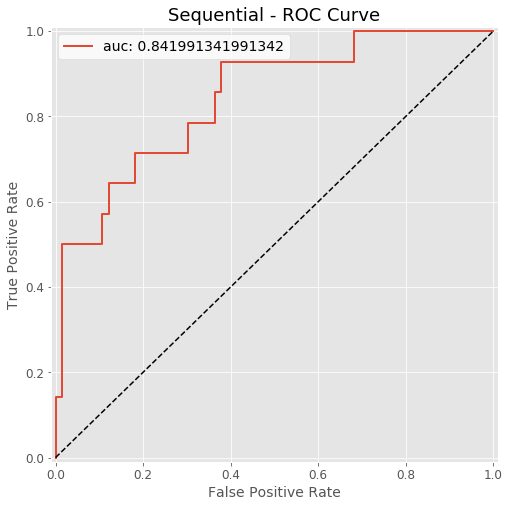

In [120]:
plot_roc_curve(fpr, tpr, auc_NL, model)

In [121]:
test_probability=model.predict_classes(test_Features)

In [122]:
scores=model.evaluate(test_Features, test_Label, verbose=0)
from sklearn.metrics import accuracy_score
accu_NL=accuracy_score(test_Label, test_probability)

In [123]:
accu_NL

0.8375

In [124]:
test_reshape=np.reshape(test_probability, 80)

In [125]:
pd.crosstab(test_Label, test_reshape,
           rownames=['lable'], colnames=['prediction'])

prediction   0  1
lable            
0.0         60  6
1.0          7  7

f1=0.519 auc_NL=0.623 ap=0.636


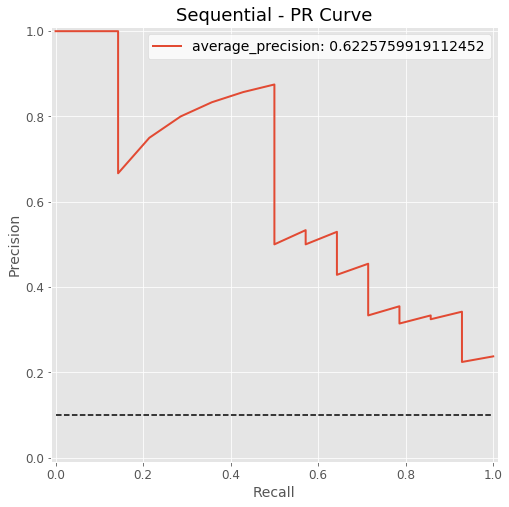

In [126]:
# predict probabilities
test_probability=model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability, 80)
# keep probabilities for the positive outcome only
#pred_proba_NL = pred_proba_NL[:, 1]
# predict class values
yhat = model.predict_classes(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_NL)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_NL_pr=auc(recall, precision)
# calculate average precision score
ap_NL_pr = average_precision_score(test_Label, pred_proba_NL)
print('f1=%.3f auc_NL=%.3f ap=%.3f' % (f1, auc_NL_pr, ap_NL_pr))

plot_precision_recall_curve(recall, precision, auc_NL_pr, model)

# 10 fold cross-validation

In [166]:
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
import numpy

In [167]:
seed = 7
numpy.random.seed(seed)

In [168]:
X, Y=PreprocessData(df)

# Deep learning 10-fold cross validation test

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_NL=[]
roc_auc_NL=[]
f1_NL=[]
auc_NL_pr_all=[]
ap_NL_pr_all=[]
for train, test in kfold.split(X, Y):
   # create model
     model = keras.Sequential([
      keras.layers.Dense(200, activation='relu',input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

     model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
    )
    # Fit the model
     model.fit(X[train],Y[train], 
          epochs=300, batch_size=100, verbose=0)
    
    
     scores = model.evaluate(X[test], Y[test], verbose=0)[1]
    test_probability=model.predict(X[test])
     pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
     yhat = model.predict_classes(X[test])
    
    auc_NL = roc_auc_score(Y[test],  pred_proba_NL)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_NL)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_NL_pr=auc(recall, precision)
    # calculate average precision score
    ap_NL_pr= average_precision_score(Y[test], pred_proba_NL)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_NL.append( scores)
    roc_auc_NL.append(auc_NL)
    f1_NL.append( f1)
    auc_NL_pr_all.append(auc_NL_pr)
    ap_NL_pr_all.append(ap_NL_pr)

In [197]:
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_NL)*100, numpy.std(scores_NL)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_NL)*100, numpy.std(roc_auc_NL)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_NL)*100, numpy.std(f1_NL)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_NL_pr_all)*100, numpy.std(auc_NL_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_NL_pr_all)*100, numpy.std(ap_NL_pr_all)*100))

scores=82.75% (+/- 5.20%)
roc_auc=82.76% (+/- 5.12%)
f1=38.93% (+/- 11.06%)
auc=53.92% (+/- 11.12%)
ap=56.12% (+/- 10.04%)


# Logistic regression 10-fold cross validation test

In [191]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_lr=[]
roc_auc_lr=[]
f1_lr=[]
auc_lr_pr_all=[]
ap_lr_pr_all=[]
for train, test in kfold.split(X, Y):
    # Import model and retrain
    #with open('model/20190314-roc_auc/lr_clf_final_round.pkl', 'rb') as f:
    #    lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])
    #class_weight
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    class_weights={
    1: 1 / severe,
    0: 1 / mild}
    
    accu_lr = accuracy_score(Y[test], lr_clf.predict(X[test]))
   # create model
    pred_proba_lr = lr_clf.predict_proba(X[test])
    pred_proba_lr = pred_proba_lr[:, 1]
    yhat = lr_clf.predict(X[test])
    
    auc_lr = roc_auc_score(Y[test],  pred_proba_lr)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_lr)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_lr_pr=auc(recall, precision)
    # calculate average precision score
    ap_lr_pr= average_precision_score(Y[test], pred_proba_lr)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_lr.append( accu_lr )
    roc_auc_lr.append( auc_lr )
    f1_lr.append( f1)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr_pr_all.append(ap_lr_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_lr)*100, numpy.std(scores_lr)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_lr)*100, numpy.std(roc_auc_lr)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_lr)*100, numpy.std(f1_lr)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_lr_pr_all)*100, numpy.std(auc_lr_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_lr_pr_all)*100, numpy.std(ap_lr_pr_all)*100))

scores=83.46% (+/- 1.20%)
roc_auc=81.46% (+/- 3.54%)
f1=19.12% (+/- 12.02%)
auc=50.53% (+/- 10.15%)
ap=52.97% (+/- 8.98%)


# Random forest 10-fold cross validation test

In [198]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_rf=[]
roc_auc_rf=[]
f1_rf=[]
auc_rf_pr_all=[]
ap_rf_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   #with open('model/20190314-roc_auc/rf_clf_final_round.pkl', 'rb') as f:
   #     rf_clf = pickle.load(f)
        rf_clf.fit(X[train], Y[train])
    
        accu_rf = accuracy_score(Y[test], rf_clf.predict(X[test]))
   # create model
        pred_proba_rf = rf_clf.predict_proba(X[test])
        pred_proba_rf = pred_proba_rf[:, 1]
        yhat = rf_clf.predict(X[test])
        auc_rf = roc_auc_score(Y[test],  pred_proba_rf)
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_rf)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_rf_pr=auc(recall, precision)
    # calculate average precision score
        ap_rf_pr= average_precision_score(Y[test], pred_proba_rf)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_rf.append( accu_rf )
        roc_auc_rf.append(auc_rf)
        f1_rf.append( f1)
        auc_rf_pr_all.append(auc_rf_pr)
        ap_rf_pr_all.append(ap_rf_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_rf)*100, numpy.std(roc_auc_rf)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=76.33% (+/- 4.37%)
roc_auc=81.74% (+/- 3.99%)
f1=51.77% (+/- 5.60%)
auc=47.21% (+/- 9.05%)
ap=49.96% (+/- 8.37%)


# Gradient boosting machine learning model

In [199]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_gbm=[]
roc_auc_gbm=[]
f1_gbm=[]
auc_gbm_pr_all=[]
ap_gbm_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   #with open('model/20190314-roc_auc/gbm_clf_final_round.pkl', 'rb') as f:
   #     gbm_clf = pickle.load(f)
        gbm_clf.fit(X[train], Y[train])
    
        accu_gbm = accuracy_score(Y[test], gbm_clf.predict(X[test]))
   # create model
        pred_proba_gbm = gbm_clf.predict_proba(X[test])
        pred_proba_gbm = pred_proba_gbm[:, 1]
        yhat = gbm_clf.predict(X[test])
        
        auc_gbm = roc_auc_score(Y[test],  pred_proba_gbm)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_gbm)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_gbm_pr=auc(recall, precision)
    # calculate average precision score
        ap_gbm_pr= average_precision_score(Y[test], pred_proba_gbm)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_gbm.append( accu_gbm )
        roc_auc_gbm.append(auc_gbm)
        f1_gbm.append( f1)
        auc_gbm_pr_all.append(auc_gbm_pr)
        ap_gbm_pr_all.append(ap_gbm_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_gbm)*100, numpy.std(roc_auc_gbm)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=76.33% (+/- 4.37%)
roc_auc=80.83% (+/- 2.74%)
f1=51.77% (+/- 5.60%)
auc=47.21% (+/- 9.05%)
ap=49.96% (+/- 8.37%)


# SVC

In [200]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_svc=[]
roc_auc_svc=[]
f1_svc=[]
auc_svc_pr_all=[]
ap_svc_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   #with open('model/20190314-roc_auc/svc_clf_final_round.pkl', 'rb') as f:
   #     svc_clf = pickle.load(f)
        svc_clf.fit(X[train], Y[train])
    
        accu_svc = accuracy_score(Y[test], svc_clf.predict(X[test]))
   # create model
        pred_proba_svc = svc_clf.predict_proba(X[test])
        pred_proba_svc = pred_proba_svc[:, 1]
        yhat = svc_clf.predict(X[test])
        
        auc_svc = roc_auc_score(Y[test],  pred_proba_svc)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_svc)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_svc_pr=auc(recall, precision)
    # calculate average precision score
        ap_svc_pr= average_precision_score(Y[test], pred_proba_svc)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_svc.append( accu_svc )
        roc_auc_svc.append(auc_svc)
        f1_svc.append( f1)
        auc_svc_pr_all.append(auc_svc_pr)
        ap_svc_pr_all.append(ap_svc_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_svc)*100, numpy.std(scores_svc)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_svc)*100, numpy.std(roc_auc_svc)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_svc)*100, numpy.std(f1_svc)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_svc_pr_all)*100, numpy.std(auc_svc_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_svc_pr_all)*100, numpy.std(ap_svc_pr_all)*100))

scores=73.82% (+/- 5.38%)
roc_auc=81.99% (+/- 4.07%)
f1=50.85% (+/- 6.69%)
auc=50.90% (+/- 10.20%)
ap=53.31% (+/- 9.16%)


## Summary
Support vector machine, random forests and gradient boosting classifiers are better than Apache 3 and ANZROD in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The Deep learner performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

There are also composite scores that attempt to summarize the precision and recall; three examples include:

F score or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

Average precision: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

Area Under Curve: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

In [207]:
pd.DataFrame([[numpy.mean(scores_lr), numpy.mean(scores_svc), numpy.mean(scores_rf), numpy.mean(scores_gbm), numpy.mean(scores_NL)],
              [numpy.mean(roc_auc_lr), numpy.mean(roc_auc_svc), numpy.mean(roc_auc_rf),numpy.mean(roc_auc_gbm), numpy.mean(roc_auc_NL)],
              [numpy.mean(auc_lr_pr_all), numpy.mean(auc_svc_pr_all), numpy.mean(auc_rf_pr_all), numpy.mean(auc_gbm_pr_all),  numpy.mean(auc_NL_pr_all)],
              [numpy.mean(ap_lr_pr_all), numpy.mean(ap_svc_pr_all), numpy.mean(ap_rf_pr_all), numpy.mean(ap_gbm_pr_all),  numpy.mean(ap_NL_pr_all)]],
              index=['Accuracy(>=.5)', 'Area Under (ROC) Curve', 'Area Under (Precision-recall) Curve', 'Average precision score' ],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine',  'Deep Learner'])

Logistic Regression  \
Accuracy(>=.5)                                  0.834604   
Area Under (ROC) Curve                          0.814644   
Area Under (Precision-recall) Curve             0.505263   
Average precision score                         0.529737   

                                     Support vector machine  Random forests  \
Accuracy(>=.5)                                     0.738165        0.763259   
Area Under (ROC) Curve                             0.819947        0.817370   
Area Under (Precision-recall) Curve                0.509034        0.472081   
Average precision score                            0.533142        0.499566   

                                     Gradient boosting machine  Deep Learner  
Accuracy(>=.5)                                        0.847152      0.827473  
Area Under (ROC) Curve                                0.808279      0.827622  
Area Under (Precision-recall) Curve                   0.476272      0.539163  
Average precision score                               0.503327      0.561166

### Concat prediction_proba for each model to test set, save test set

In [240]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]
data_test['rf_pred_proba'] = pred_proba_rf[:, 1]
data_test['svc_pred_proba'] = pred_proba_svc[:, 1]
data_test['gbm_pred_proba'] = pred_proba_gbm[:, 1]
data_test['ensemble_pred_proba'] = pred_proba_ensemble[:, 1]
data_test['h2o_deep_pred_proba'] = h2o_deep_pred

In [241]:
data_test.to_csv('../data/test_set_with_predictions.csv'.format(len(data_train)), index=False)

## Class breakdown per model

In [258]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.died_hosp == 0].hist(alpha=.5, label='Survived', color = "green", **histkwargs)
    df[var][df.died_hosp == 1].hist(alpha=.5, label='Died', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.ylim(ymax=250, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

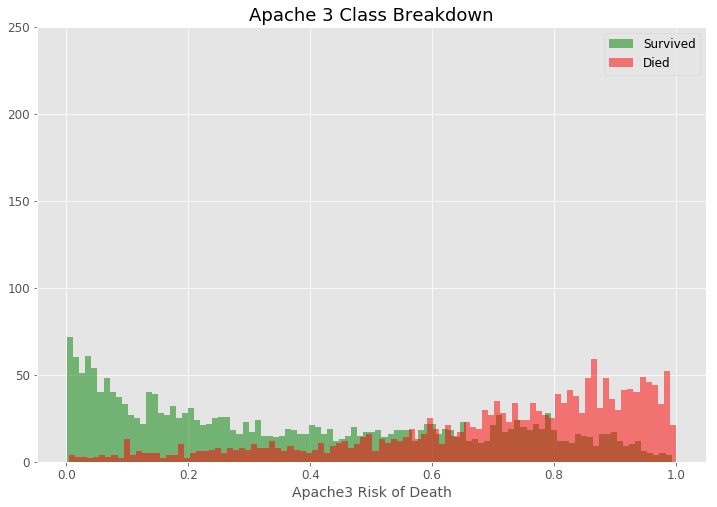

In [259]:
plot_class_breakdown_hist(data_test, 'apache3riskofdeath', var_name='Apache3 Risk of Death', 
                          plot_title='Apache 3 Class Breakdown', bins=100)

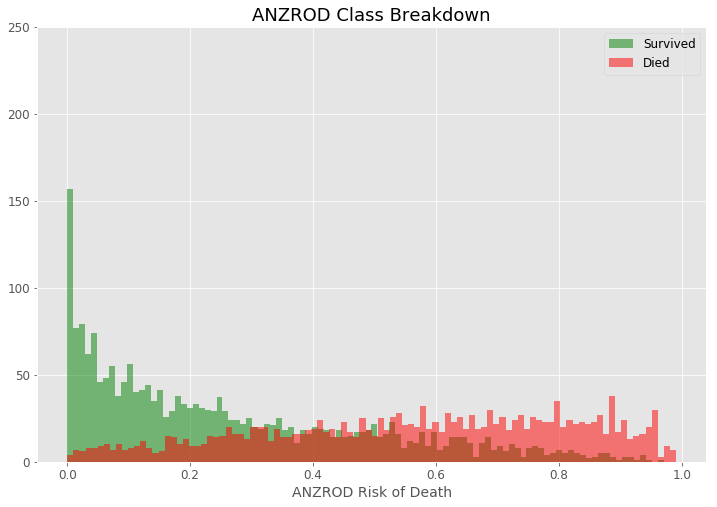

In [260]:
plot_class_breakdown_hist(data_test, 'anzrodriskofdeath', var_name='ANZROD Risk of Death', 
                          plot_title='ANZROD Class Breakdown', bins=100)

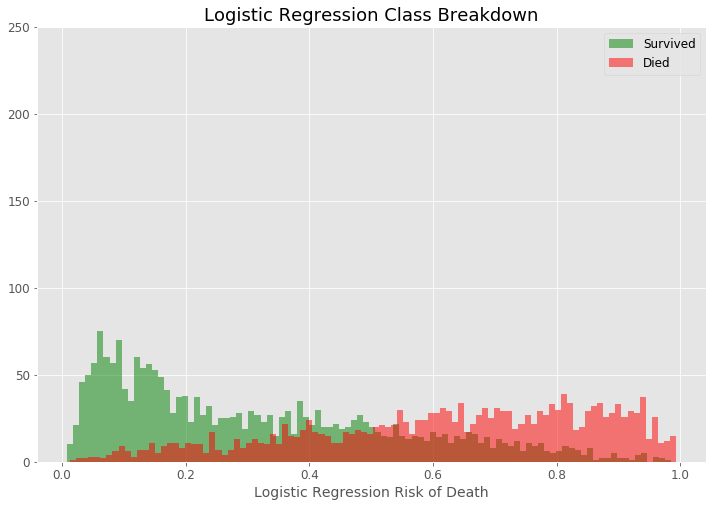

In [261]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='Logistic Regression Risk of Death', 
                          plot_title='Logistic Regression Class Breakdown', bins=100)

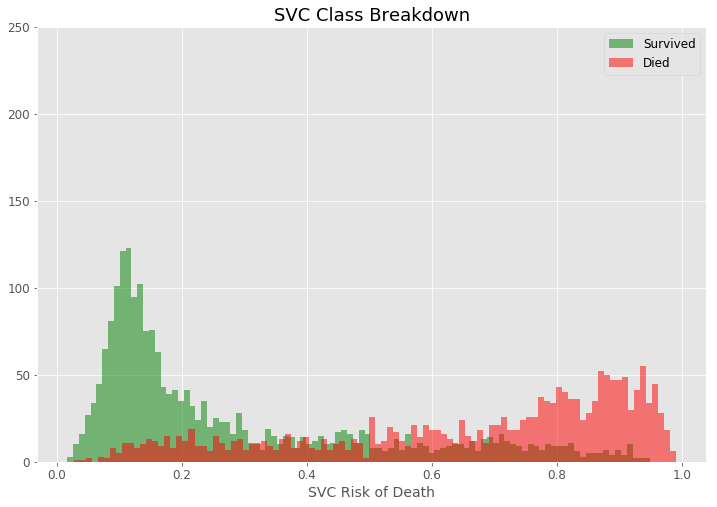

In [262]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC Risk of Death', 
                          plot_title='SVC Class Breakdown', bins=100)

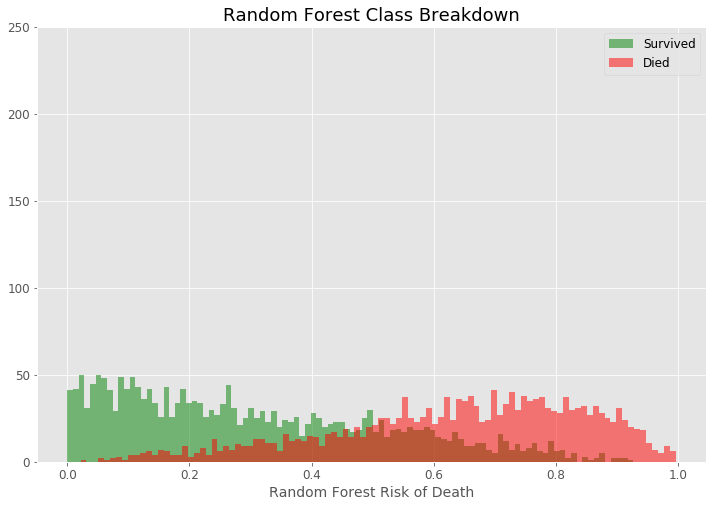

In [263]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='Random Forest Risk of Death', 
                          plot_title='Random Forest Class Breakdown', bins=100)

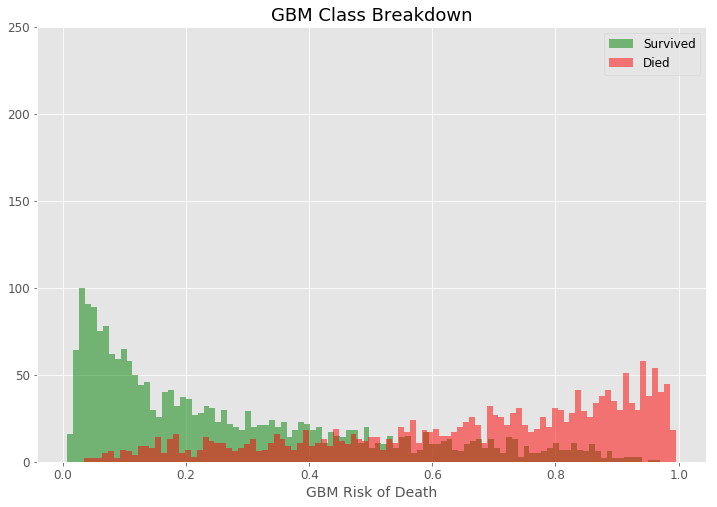

In [264]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM Risk of Death', 
                          plot_title='GBM Class Breakdown', bins=100)

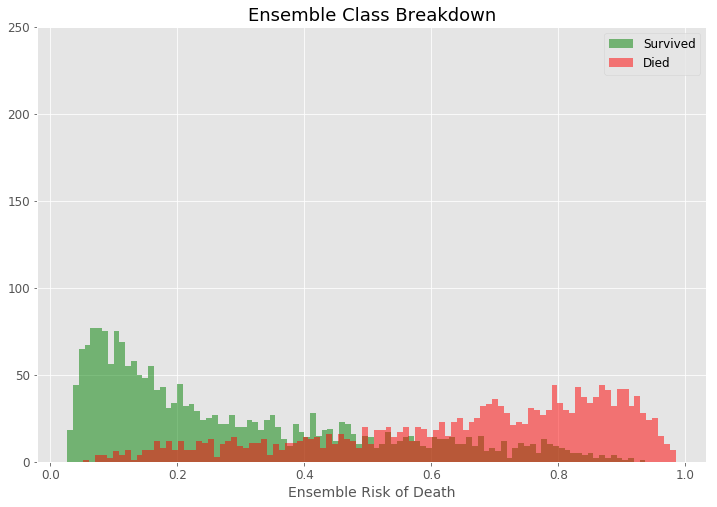

In [265]:
plot_class_breakdown_hist(data_test, 'ensemble_pred_proba', var_name='Ensemble Risk of Death', 
                          plot_title='Ensemble Class Breakdown', bins=100)

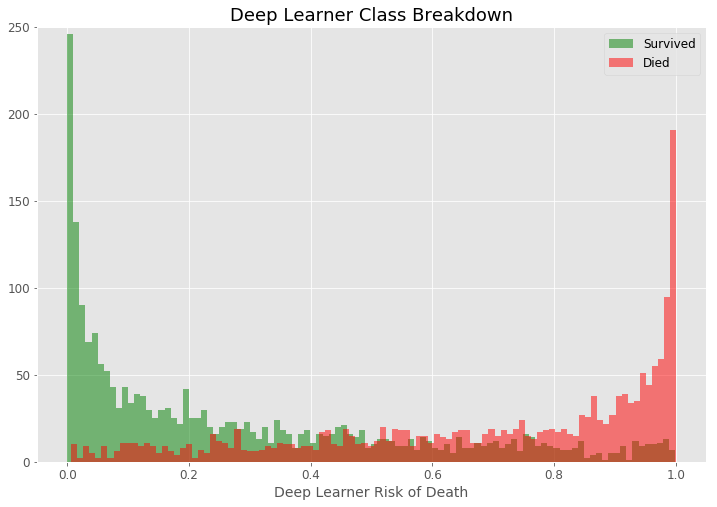

In [266]:
plot_class_breakdown_hist(data_test, 'h2o_deep_pred_proba', var_name='Deep Learner Risk of Death', 
                          plot_title='Deep Learner Class Breakdown', bins=100)

In [267]:
import numpy as np
from sklearn import metrics

model = dict()
actual = dict()
predict = dict()
color = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

model[0] = 'Apache 3'
actual[0] = data_test[~data_test.apache3riskofdeath.isna()].died_hosp
predict[0] = data_test[~data_test.apache3riskofdeath.isna()].apache3score
color[0] = 'blue'

model[1] = 'ANZROD'
actual[1] = data_test[~data_test.anzrodriskofdeath.isna()].died_hosp
predict[1] = data_test[~data_test.anzrodriskofdeath.isna()].anzrodriskofdeath
color[1] = 'orange'

model[2] = 'Soft-voter Ensemble'
actual[2] = data_test.died_hosp
predict[2] = data_test.ensemble_pred_proba
color[2] = 'red'

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = metrics.roc_curve(actual[i], predict[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

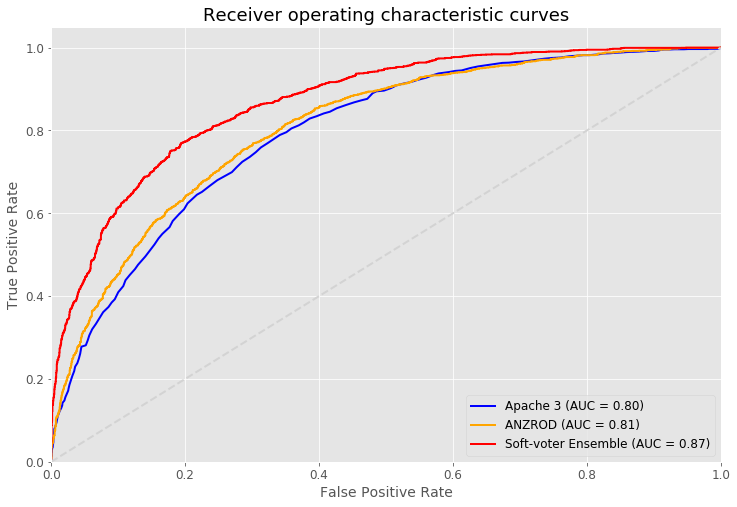

In [268]:
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=lw, label=model[i]+' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()

In [269]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
data_test['died_hosp'].sum() / len(data_test['died_hosp'])

# calculate per age group
age_groups = ['[0, 30)','[30, 40)','[40, 50)','[50, 60)','[60, 70)','[70, 80)','[80,)']
predicted_mortality = []
for group in age_groups:
    predicted_mortality.append(data_test[(data_test.age_group == group) & (~data_test.died_hosp.isna())]['died_hosp'].sum() / len(data_test[(data_test.age_group == group) & (~data_test.died_hosp.isna())]['died_hosp']))
predicted_mortality

# create list per model
models = ['apache3riskofdeath','anzrodriskofdeath','lr_pred_proba','rf_pred_proba','svc_pred_proba',
          'gbm_pred_proba','h2o_deep_pred_proba','ensemble_pred_proba','died_hosp']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.age_group == group) & (~data_test[model].isna())][model].sum() / len(data_test[(data_test.age_group == group) & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_mortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'died_hosp':'True Ratio',
                                                  'apache3riskofdeath':'Apache 3',
                                                  'anzrodriskofdeath':'ANZROD',
                                                 'lr_pred_proba':'Logistic Regression',
                                                 'rf_pred_proba':'Random Forest Classifier',
                                                 'svc_pred_proba':'Support Vector Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'h2o_deep_pred_proba':'Deep Learner',
                                                 'ensemble_pred_proba':'Ensemble Classifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'[0, 30)':'0-29',
                                               '[30, 40)':'30-39',
                                               '[40, 50)':'40-49',
                                               '[50, 60)':'50-59',
                                               '[60, 70)':'60-69',
                                               '[70, 80)':'70-79',
                                               '[80,)':'80+'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

Apache 3  ANZROD  Logistic Regression  Random Forest Classifier  \
Age group                                                                    
0-29          0.412   0.287                0.366                     0.433   
30-39         0.405   0.293                0.388                     0.425   
40-49         0.463   0.343                0.442                     0.443   
50-59         0.477   0.350                0.436                     0.419   
60-69         0.566   0.439                0.469                     0.450   
70-79         0.589   0.449                0.479                     0.486   
80+           0.594   0.454                0.491                     0.502   

           Support Vector Classifier  Gradient Boosted Machine  Deep Learner  \
Age group                                                                      
0-29                           0.435                     0.420         0.392   
30-39                          0.394                     0.402         0.385   
40-49                          0.426                     0.426         0.427   
50-59                          0.410                     0.398         0.423   
60-69                          0.450                     0.443         0.472   
70-79                          0.496                     0.498         0.512   
80+                            0.512                     0.529         0.543   

           Ensemble Classifier  True Ratio  
Age group                                   
0-29                     0.429       0.394  
30-39                    0.407       0.426  
40-49                    0.432       0.428  
50-59                    0.409       0.396  
60-69                    0.448       0.445  
70-79                    0.493       0.508  
80+                      0.514       0.521

In [270]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted Mortality by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted Mortality by Age Group (Rounded).csv')

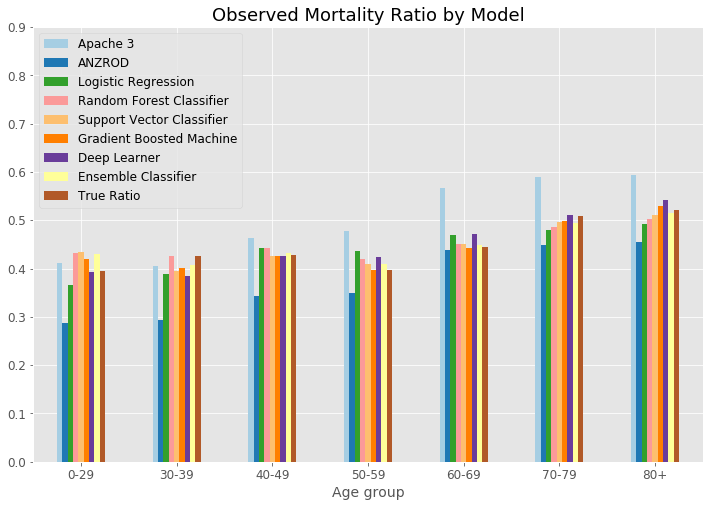

In [271]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Observed Mortality Ratio by Model',
                                       colormap='Paired')

## List of all features used

In [272]:
data_train_X.columns.to_frame().to_csv('Final features for model.csv') # Save to CSV
data_train_X.columns.to_frame()

0
sex                  sex
chr_resp        chr_resp
chr_cvs          chr_cvs
chr_liv          chr_liv
chr_ren          chr_ren
immundis        immundis
immunrx          immunrx
hepfail          hepfail
lymphoma        lymphoma
metast            metast
leukaem          leukaem
immunsup        immunsup
cirrhos          cirrhos
iddm                iddm
arf                  arf
gcsverb          gcsverb
gcsmotor        gcsmotor
gcseye            gcseye
intubated      intubated
ventilated    ventilated
elect              elect
age                  age
urineop          urineop
temphi            temphi
templo            templo
hrhi                hrhi
hrlo                hrlo
rrhi                rrhi
rrlo                rrlo
systolichi    systolichi
systoliclo    systoliclo
diastolichi  diastolichi
diastoliclo  diastoliclo
maphi              maphi
maplo              maplo
nahi                nahi
nalo                nalo
khi                  khi
klo                  klo
hco3hi            hco3hi
hco3lo            hco3lo
creathi          creathi
creatlo          creatlo
hcthi              hcthi
hctlo              hctlo
hmgnhi            hmgnhi
hmgnlo            hmgnlo
wcchi              wcchi
wcclo              wcclo
plathi            plathi
platlo            platlo
gluchi            gluchi
gluclo            gluclo
pre_icu_hrs  pre_icu_hrs